In [1]:
import pandas as pd
import numpy as np
import itertools as it

import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

plt.rc('axes', axisbelow=True)

%matplotlib inline

# Daily COVID-19 plots

https://d14wlfuexuxgcm.cloudfront.net/covid/rt.csv

https://covidtracking.com/api/v1/states/daily.csv

https://docs.google.com/spreadsheets/d/e/2PACX-1vS8SzaERcKJOD_EzrtCDK1dX1zkoMochlA9iHoHg_RSw3V8bkpfk1mpw4pfL5RdtSOyx_oScsUtyXyk/pub?gid=43720681&single=true&output=csv

In [2]:
all_state_names = {'ak': 'Alaska', 'al': 'Alabama', 'ar': 'Arkansas',
                   'as': 'American Samoa',  'az': 'Arizona',
                   'ca': 'California', 'co': 'Colorado',
                   'ct': 'Connecticut', 'dc': 'District of Columbia',
                   'de': 'Delaware', 'fl': 'Florida', 'ga': 'Georgia',
                   'gu': 'Guam', 'hi': 'Hawaii', 'ia': 'Iowa',
                   'id': 'Idaho', 'il': 'Illinois', 'in': 'Indiana',
                   'ks': 'Kansas', 'ky': 'Kentucky', 'la': 'Louisiana',
                   'ma': 'Massachusetts', 'md': 'Maryland', 'me': 'Maine',
                   'mi': 'Michigan', 'mn': 'Minnesota', 'mo': 'Missouri',
                   'mp': 'Northern Mariana Islands', 'ms': 'Mississippi',
                   'mt': 'Montana', 'nc': 'North Carolina',
                   'nd': 'North Dakota', 'ne': 'Nebraska',
                   'nh': 'New Hampshire', 'nj': 'New Jersey',
                   'nm': 'New Mexico', 'nv': 'Nevada', 'ny': 'New York',
                   'oh': 'Ohio', 'ok': 'Oklahoma', 'or': 'Oregon',
                   'pa': 'Pennsylvania', 'pr': 'Puerto Rico',
                   'ri': 'Rhode Island', 'sc': 'South Carolina',
                   'sd': 'South Dakota', 'tn': 'Tennessee', 'tx': 'Texas',
                   'ut': 'Utah', 'va': 'Virginia',
                   'vi': 'Virgin Islands', 'vt': 'Vermont',
                   'wa': 'Washington', 'wi': 'Wisconsin',
                   'wv': 'West Virginia', 'wy': 'Wyoming'}

all_state_ids = {'01': 'al', '02': 'ak', '04': 'az', '05': 'ar',
                 '06': 'ca', '08': 'co', '09': 'ct', '10': 'de',
                 '11': 'dc', '12': 'fl', '13': 'ga', '15': 'hi',
                 '16': 'id', '17': 'il', '18': 'in', '19': 'ia',
                 '20': 'ks', '21': 'ky', '22': 'la', '23': 'me',
                 '24': 'md', '25': 'ma', '26': 'mi', '27': 'mn',
                 '28': 'ms', '29': 'mo', '30': 'mt', '31': 'ne',
                 '32': 'nv', '33': 'nh', '34': 'nj', '35': 'nm',
                 '36': 'ny', '37': 'nc', '38': 'nd', '39': 'oh',
                 '40': 'ok', '41': 'or', '42': 'pa', '44': 'ri',
                 '45': 'sc', '46': 'sd', '47': 'tn', '48': 'tx',
                 '49': 'ut', '50': 'vt', '51': 'va', '53': 'wa',
                 '54': 'wv', '55': 'wi', '56': 'wy', "60": 'as',
                 "66": 'gu', "72": 'pr', '78': 'vi', '69': 'mp'}

all_ids_state = {j:i for i,j in all_state_ids.items()}

state_posx = {'ak': (0, 0), 'me': (0, 10),'gu': (7, 0), 'vi': (7, 9), 'pr': (7, 8), 'mp': (7, 1),
              'vt': (1, 9), 'nh': (1, 10),'wa': (2, 0), 'id': (2, 1), 'mt': (2, 2), 'nd': (2, 3), 'mn': (2, 4),
              'il': (2, 5), 'wi': (2, 6), 'mi': (2, 7), 'ny': (2, 8), 'ri': (2, 9), 'ma': (2, 10),'or': (3, 0),
              'nv': (3, 1), 'wy': (3, 2), 'sd': (3, 3), 'ia': (3, 4), 'in': (3, 5), 'oh': (3, 6), 'pa': (3, 7),
              'nj': (3, 8), 'ct': (3, 9), 'ca': (4, 0), 'ut': (4, 1), 'co': (4, 2), 'ne': (4, 3), 'mo': (4, 4),
              'ky': (4, 5), 'wv': (4, 6), 'va': (4, 7), 'md': (4, 8), 'de': (4, 9), 'az': (5, 1), 'nm': (5, 2), 
              'ks': (5, 3), 'ar': (5, 4), 'tn': (5, 5), 'nc': (5, 6), 'sc': (5, 7), 'dc': (5, 8), 'ok': (6, 3),
              'la': (6, 4), 'ms': (6, 5), 'al': (6, 6), 'ga': (6, 7), 'hi': (6, 0), 'tx': (7, 3), 'fl': (7, 7)}

month_dict = {'01':'January','02':'February','03':'March','04':'April','05':'May','06':'June',
              '07':'July','08':'August','09':'September','10':'October','11':'November','12':'December'}

In [3]:
today = str(dt.datetime.date(dt.datetime.now()))

# make DATE_DF, a simple dataframe with dates, weekdays, and weeknums
weekday_mapping = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}

alldates = pd.date_range(start='2020-01-01', end='2021-12-31').tolist()
datelist = [str(i.date()) for i in alldates]
weekdays = [weekday_mapping[i.date().weekday()] for i in alldates]
weeklist = [i//7 for i in range(len(alldates))]
DATE_DF = pd.DataFrame({'date':datelist,'day':weekdays,'week':weeklist})
DATE_DF = DATE_DF.loc[DATE_DF['date']<=today].copy()
DATERANGE = DATE_DF['date'].tolist()
dates = DATERANGE.copy()

In [4]:
up_col = 'darkslategrey'
down_col = 'lightseagreen'
vdown_col = 'skyblue'
low_col = 'tan'

# Estimated $r_t$

In [5]:
# rt_df = pd.read_csv('https://d14wlfuexuxgcm.cloudfront.net/covid/rt.csv')
# rt_df['region'] = rt_df['region'].str.lower()
# rt_df['fips'] = [all_ids_state[i] for i in rt_df['region']]
# rt_df['state'] = [all_state_names[st] for st in rt_df['region'].values]

# rt_df = rt_df.sort_values('date').reset_index().iloc[:,1:]

In [6]:
# fdate = '2020-03-05'
# days_since = 7
# min_c = 50

# dates = rt_df.date.unique().tolist()
# date_dict = dict(zip(dates, list(range(len(dates)))))

# xtx = ['2020-03-01','2020-04-01','2020-05-01','2020-06-01','2020-07-01','2020-08-01',
#        '2020-09-01','2020-10-01','2020-11-01','2020-12-01','2021-01-01','2021-02-01']
# xtxl = ['Mar.','','May','','Jul.','','Sep.','','Nov.','','Jan.','']
# col_co = '.2'

# w = 3.0; h = 2.3
# ncols = 11; nrows = 8
# tups = list(it.product(range(nrows), range(ncols)))
# fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100)#, sharex=True)
# plt.subplots_adjust(wspace=0.05,hspace=0.05)

# for st, po in state_posx.items():
#     stlab = all_state_names[st]
#     if stlab not in rt_df['state'].unique().tolist():
#         ax[po].set_axis_off()
#         continue
#     ll_st = rt_df.loc[rt_df['state']==stlab].copy()

#     xvals = np.array([date_dict[i] for i in sorted(ll_st['date'].tolist())])
#     inds = np.where(xvals >= date_dict[fdate])[0]
#     yvals = ll_st['mean'].values[inds]
#     yvals_u = ll_st['upper_80'].values[inds]
#     yvals_l = ll_st['lower_80'].values[inds]
#     xvals = xvals[inds]

#     if yvals[-1] < 1.0:
#         col_co = down_col
#     if yvals[-1] >= 1.0:
#         col_co = up_col

#     cols_co = [up_col if i>1 else down_col for i in yvals]
#     ax[po].scatter(xvals, yvals, c=cols_co, lw=0, alpha=0.9, zorder=5, s=4)
#     ax[po].vlines(xvals, yvals_l, yvals_u, color=cols_co, alpha=0.9, linewidth=0.85)
#     ax[po].hlines(1, -1, xvals[-1]+2, color='.4', linestyle='--', linewidth=2, alpha=9)
#     ax[po].hlines(2, -1, xvals[-1]+2, color='.4', linestyle='--', linewidth=2, alpha=9)

#     if stlab == 'District of Columbia':
#         stlab = 'D.C.'

#     ax[po].text(0.02,0.98,stlab,fontsize='xx-large',va='top',ha='left',
#                 color='.3',fontweight='bold',transform=ax[po].transAxes, zorder=6,
#                 path_effects=[path_effects.Stroke(linewidth=2, foreground='w'),
#                               path_effects.Normal()])
#     ax[po].text(0.02,0.84,r'most recent $R_t\approx %.2f$'%(yvals[-1]),
#                 fontsize='x-large',va='top',ha='left',zorder=7,
#                 color='.3',fontweight='medium',transform=ax[po].transAxes,
#                 path_effects=[path_effects.Stroke(linewidth=0.9, foreground='w'),
#                               path_effects.Normal()])
#     ax[po].text(date_dict[fdate]+1,1.015,r'$R_t=1$',zorder=6,
#                 fontsize='large',va='bottom',ha='left', color='.3',
#                 path_effects=[path_effects.Stroke(linewidth=0.9, foreground='w'),
#                               path_effects.Normal()])
#     ax[po].text(date_dict[fdate]+1,2.015,r'$R_t=2$', zorder=6,
#                 fontsize='large',va='bottom',ha='left', color='.3',
#                 path_effects=[path_effects.Stroke(linewidth=0.9, foreground='w'),
#                               path_effects.Normal()])

#     ax[po].set_xticks([date_dict[i] for i in xtx])
#     ax[po].set_xticklabels(xtxl,fontsize='small',color='.4')
#     ytx = [0.5,1.0,1.5,2.0,2.5,3.0]
#     ax[po].set_yticks(ytx)
#     ax[po].set_yticklabels(['']*len(ytx))
#     ax[po].grid(linewidth=1.5,color='.985',alpha=0.8)
#     ax[po].tick_params(axis="x",direction="in", pad=-15)
#     ax[po].tick_params(axis="y",direction="in", pad=-5)

#     ylim_st = ax[po].get_ylim()
#     xlim_st = ax[po].get_xlim()
#     ydiff = ylim_st[1]-ylim_st[0]
#     ylim_st = (0.01, 3.51)

#     ax[po].fill_between([date_dict[fdate]-1,xvals[-1]+1],0-ydiff*0.02,ylim_st[1]*1.3,
#                         color=col_co,alpha=0.08,zorder=0)
#     ax[po].fill_between([xvals[-days_since],xvals[-1]+1],0-ydiff*0.02,ylim_st[1]*1.3,
#                         color='.7',alpha=0.3,zorder=0, linewidth=0)

    
#     ax[po].set_ylim(ylim_st[0], ylim_st[1])
#     ax[po].set_xlim(date_dict[fdate]-1,xvals[-1]+1)

# for tup in tups:
#     if tup not in state_posx.values():
#         ax[tup].set_axis_off()

# ax[tups[-1]].text(0.99,0.01,'source:\nrt.live',color='.5',fontsize='xx-large',
#                 va='bottom', ha='right', transform=ax[tups[-1]].transAxes)
# ax[(0,1)].text(0.05,0.99,r'United States COVID-19 estimated $R_t$'+\
#                '\n(%s — %s)'%(fdate,sorted(ll_st['date'].tolist())[-1]),
#                color='.3', fontsize=30, va='top', ha='left', transform=ax[(0,1)].transAxes)

# ax[(1,1)].text(0.075,1.25,r'Most recent estimates of $R_t$:',
#                 color='.2',fontsize=20, va='bottom', ha='left', transform=ax[(1,1)].transAxes)
# ax[(1,1)].text(0.2,1.05,r'- $R_t \geq 1.0$',
#                 color=up_col,fontsize=20, va='bottom', ha='left', transform=ax[(1,1)].transAxes)
# ax[(1,1)].text(0.9,1.05,r'- $R_t < 1.0$',
#                 color=down_col,fontsize=20, va='bottom', ha='left', transform=ax[(1,1)].transAxes)

# gs = ax[1, 8].get_gridspec()
# for a in ax[0:1, 5:9].flatten():
#     a.remove()
# axbig = fig.add_subplot(gs[0:1, 5:9])

# curr_df = rt_df.loc[rt_df['date']==rt_df['date'].max()].sort_values('mean')
# xvals = np.linspace(0.5,curr_df.shape[0]-0.5,curr_df.shape[0])
# yvals = curr_df['mean'].values
# yvals_u = curr_df['upper_80'].values
# yvals_l = curr_df['lower_80'].values

# cols_co = [up_col if i>1 else down_col for i in yvals]
# axbig.scatter(xvals, yvals, c=cols_co, alpha=0.9, zorder=5,s=50,marker='o',lw=1,edgecolors='w')
# axbig.vlines(xvals, yvals_l, yvals_u, color=cols_co, alpha=0.7, linewidth=1.5)
# axbig.hlines(1, -1, xvals[-1]+2, color='.4', linestyle='--', linewidth=2, alpha=9)

# axbig.set_xticks([])
# axbig.set_yticks([0.5,0.75,1.0,1.25,1.5,1.75])
# axbig.set_yticklabels(['0.50','0.75','1.00','1.25','1.50','1.75'],fontsize='large',color='.4')
# axbig.set_ylabel(r'Estimated $R_t$ value'+'\n(as of %s)'%curr_df['date'].values[0],fontsize='large',color='.3')
# axbig.set_xlim(-0.5,curr_df.shape[0]+0.5)
# axbig.set_ylim(0.425,1.825)
# axbig.grid(linewidth=1.5,color='.7',alpha=0.4)

# x = 0
# for i, l in enumerate(curr_df['region'].values):
#     ytxt = yvals_u[i] + 0.025
#     xtxt = i+0.5
#     va_l = 'bottom'
#     ha_l = 'center'
#     mm_l = curr_df['mean'].values[i]
#     if mm_l >= 1.0:
#         co_l = up_col
#     else:
#         co_l = down_col
#     if x%2==0:
#         ytxt = yvals_l[i] - 0.025
#         va_l = 'top'
#     axbig.text(xtxt, ytxt, l.upper(), va=va_l, ha=ha_l, fontweight='bold', color=co_l, fontsize='large',
#                path_effects=[path_effects.Stroke(linewidth=2, foreground='w'),
#                              path_effects.Normal()])
#     x += 1

# plt.savefig('../figs/pngs/state_subplot_rt_trends.png', dpi=300, bbox_inches='tight')
# plt.show()

# Hospitalizations

In [7]:
hosp = pd.read_csv('https://covidtracking.com/api/v1/states/daily.csv',dtype={'fips':str})

hosp = hosp[['date', 'state', 'hospitalizedCurrently', 'hospitalizedCumulative', 'hospitalizedIncrease',
             'inIcuCurrently', 'inIcuCumulative', 'onVentilatorCurrently', 'onVentilatorCumulative']].copy()
hosp['date'] = hosp.date.astype(str).str[:4] + '-' +\
               hosp.date.astype(str).str[4:6] + '-' + hosp.date.astype(str).str[-2:]
hosp = hosp.sort_values('date').reset_index().iloc[:,1:]

hosp.loc[(hosp['state']=='MN')&(hosp['date'].isin(['2020-10-03',
                                                   '2020-10-04'])),'hospitalizedCurrently'] = [340,367]
hosp.loc[(hosp['state']=='OR')&(hosp['date'].isin(['2020-04-04',
                       '2020-04-05', '2020-04-06', '2020-04-07'])),
         'hospitalizedCurrently'] = np.round(np.linspace(188,156,4,dtype=float))
hosp.loc[(hosp['state']=='OK')&(hosp['date'].isin(['2020-04-04','2020-04-05',
                                                   '2020-05-25'])), 'hospitalizedCurrently'] = [171,161,174]
hosp.loc[(hosp['state']=='DC')&(hosp['date'].isin(['2020-04-28','2020-04-29','2020-04-30','2020-05-01',
                                                   '2020-05-02','2020-05-03'])),
         'hospitalizedCurrently'] = np.round(np.linspace(402,447,6,dtype=float))
dates = sorted(hosp['date'].unique())

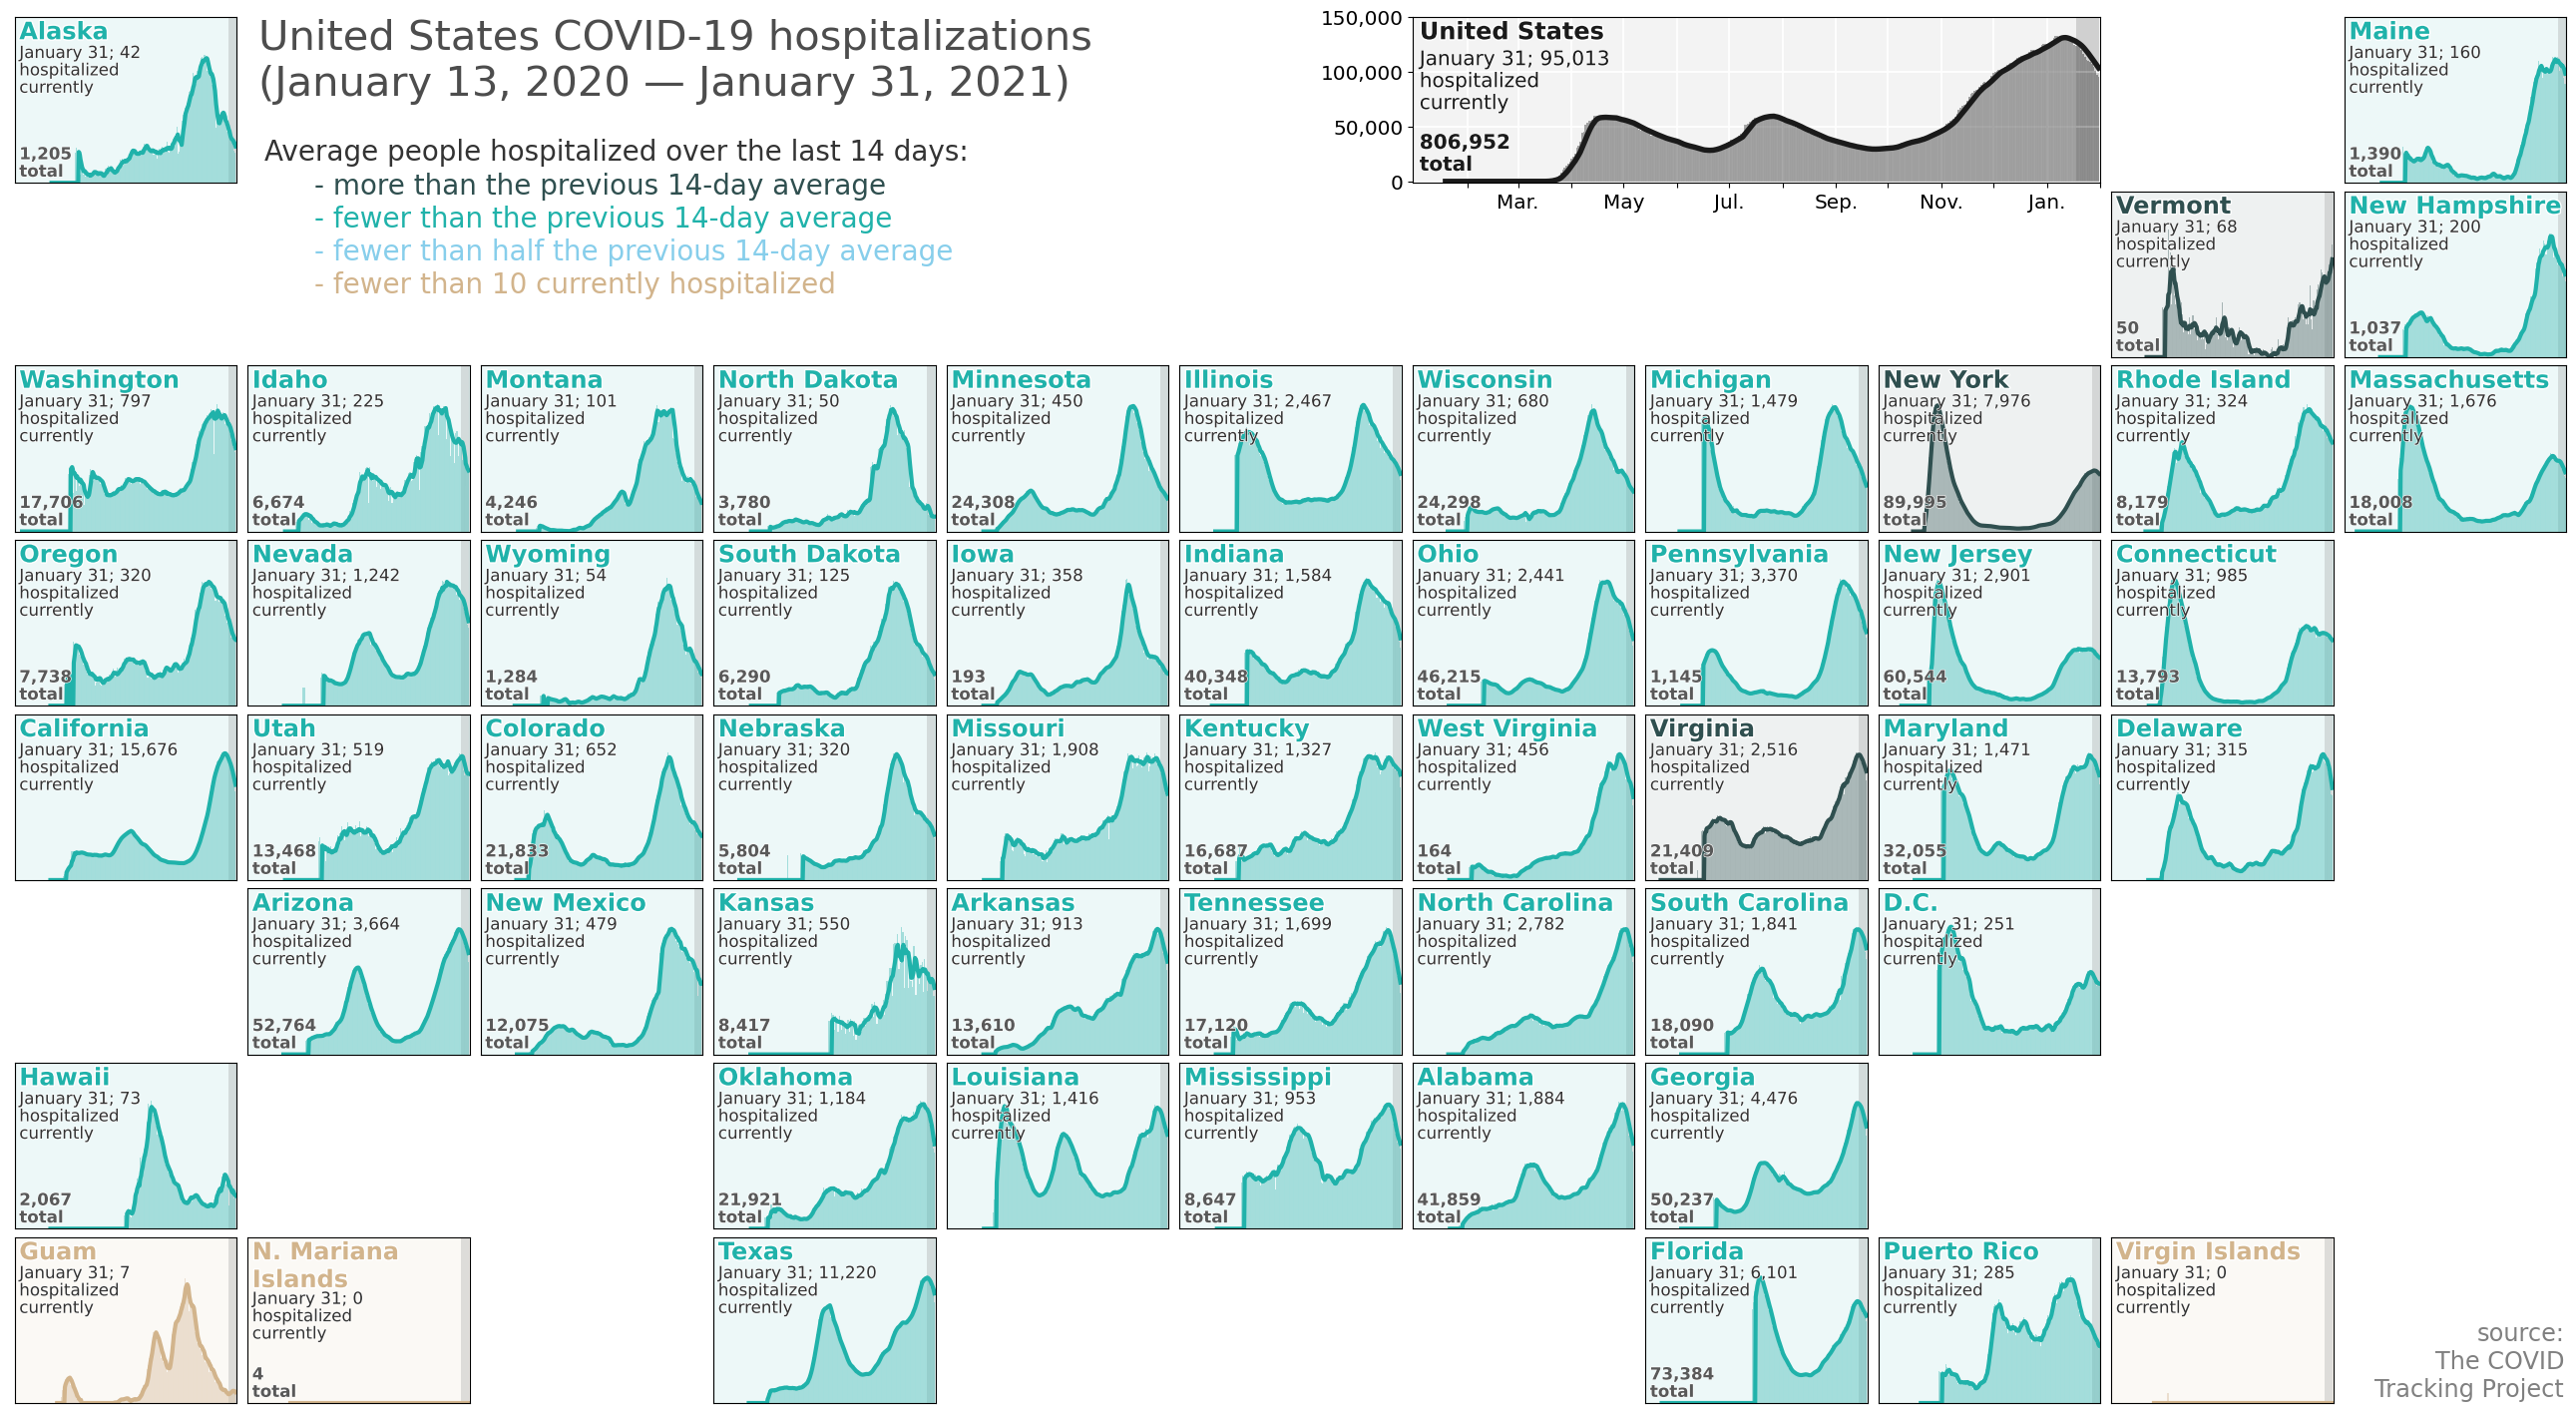

In [8]:
lw = 3
days_since = 14
min_c = 10

date_dict = dict(zip(DATE_DF['date'].values,list(range(DATE_DF.shape[0]))))

fd = dates[0]
fd = month_dict[fd[5:7]]+" "+fd[-2:]+", "+fd[:4]
ld = dates[-1]
ld = month_dict[ld[5:7]]+" "+ld[-2:]+", "+ld[:4]

w = 3.0; h = 2.3
ncols = 11; nrows = 8
tups = list(it.product(range(nrows), range(ncols)))
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100)#, sharex=True)
plt.subplots_adjust(wspace=0.05,hspace=0.05)

for st, po in state_posx.items():
    stlab = all_state_names[st]
    st = st.upper()
    ll_st = hosp.loc[hosp['state']==st].copy()

    xvals_st = [date_dict[i] for i in sorted(ll_st['date'].tolist())]
    yvals_st = np.nan_to_num(np.array(ll_st['hospitalizedCurrently'].rolling(window=7).mean().tolist()))
    yvals_st[yvals_st<0] = 0
    yvals_st_raw = np.nan_to_num(ll_st['hospitalizedCurrently'].values)
    total_cases_st = int(max(np.nan_to_num(ll_st['hospitalizedCumulative'].values)))
    if total_cases_st != 0:
        ax[po].text(0.02,0.02,'%s\ntotal'%("{:,}".format(total_cases_st)),
                    fontsize='large',va='bottom',ha='left',
                    color='.35',fontweight='bold',transform=ax[po].transAxes,
                    path_effects=[path_effects.Stroke(linewidth=0.9, foreground='w'),
                                  path_effects.Normal()])
        
    most_recent_cases_st = int(yvals_st_raw[-1])

    recent_average_curr = np.nanmean(yvals_st[(-days_since):])
    recent_average_prev = np.nanmean(yvals_st[(-2*days_since):(-days_since)])

    if recent_average_prev >= recent_average_curr:
        col_co = down_col
    if recent_average_prev <= recent_average_curr:
        col_co = up_col
    if recent_average_prev >= 2*recent_average_curr:
        col_co = vdown_col
    if recent_average_curr < min_c:
        col_co = low_col

    ax[po].plot(xvals_st, yvals_st, color=col_co, linewidth=lw)
    ax[po].bar(xvals_st, yvals_st_raw, color=col_co, alpha=0.4, width=1, linewidth=0.1, ec='w')

    if stlab == 'District of Columbia':
        stlab = 'D.C.'
    if stlab == 'Northern Mariana Islands':
        stlab = 'N. Mariana\nIslands'

    ax[po].text(0.02,0.98,stlab,fontsize='xx-large',va='top',ha='left',
                color=col_co,fontweight='bold',transform=ax[po].transAxes,
                path_effects=[path_effects.Stroke(linewidth=2, foreground='w'),
                              path_effects.Normal()])
    
    casey = 0.67 if '\n' in stlab else 0.825
    ax[po].text(0.02,casey,'%s; %s\nhospitalized\ncurrently'%(ld[:-6],"{:,}".format(most_recent_cases_st)),
            fontsize='large',va='top',ha='left', color='.2',transform=ax[po].transAxes,
                path_effects=[path_effects.Stroke(linewidth=0.9, foreground='w'),
                              path_effects.Normal()])

    ylim_st = ax[po].get_ylim()
    xlim_st = ax[po].get_xlim()
    ydiff = ylim_st[1]-ylim_st[0]
    ylim_st = (0-ydiff*0.001, np.nanmax(yvals_st_raw)*1.3)
    mtot = max(np.diff(np.nan_to_num(ll_st['hospitalizedCumulative'])))
    if mtot == 0:
        mtot = max(np.nan_to_num(ll_st['hospitalizedCurrently']))
    if mtot < 11:
        ylim_st = (-0.1, 51)
        
    ax[po].set_ylim(ylim_st[0], ylim_st[1])
    ax[po].set_xlim(-1,xvals_st[-1]+2)
    ax[po].fill_between([-1,xvals_st[-1]+1],0-ydiff*0.02,ylim_st[1]*1.3,
                        color=col_co,alpha=0.08,zorder=0)
    ax[po].fill_between([xvals_st[-days_since],xvals_st[-1]+1],0-ydiff*0.02,ylim_st[1]*1.3,
                        color='.6',alpha=0.3,zorder=0, linewidth=0)

for tup in tups:
    if tup not in state_posx.values():
        ax[tup].set_axis_off()
    else:
        ax[tup].set_xticks([])
        ax[tup].set_yticks([])


stlab = 'United States'
usa_tots = hosp.groupby('date').agg({'hospitalizedCurrently':np.nansum,
                                     'hospitalizedCumulative':np.nansum, 
                                     'inIcuCurrently':np.nansum,
                                     'inIcuCumulative':np.nansum,
                                     'onVentilatorCurrently':np.nansum, 
                                     'onVentilatorCumulative':np.nansum}).reset_index()
col_co = '.1'

xvals_st = [date_dict[i] for i in sorted(usa_tots['date'].tolist())]
yvals_st = usa_tots['hospitalizedCurrently'].rolling(window=7).mean().values
yvals_st_raw = usa_tots['hospitalizedCurrently'].values
total_cases_st = int(max(usa_tots['hospitalizedCumulative'].values))
most_recent_cases_st = usa_tots['hospitalizedCurrently'].values[-1]

gs = ax[1, 8].get_gridspec()
for a in ax[0:1, 6:9].flatten():
    a.remove()
axbig = fig.add_subplot(gs[0:1, 6:9])

axbig.plot(xvals_st, yvals_st, color=col_co, linewidth=lw*1.3)
axbig.bar(xvals_st, yvals_st_raw, color=col_co, alpha=0.4, width=1, linewidth=0.1, ec='w')

axbig.text(0.01, 0.98, stlab, fontsize='xx-large', va='top', ha='left', color=col_co,
           fontweight='bold',transform=axbig.transAxes,
                path_effects=[path_effects.Stroke(linewidth=2.0, foreground='w'),
                              path_effects.Normal()])
axbig.text(0.01, 0.05, '%s\ntotal'%("{:,}".format(int(total_cases_st))),
                  va='bottom', ha='left', color=col_co,
           fontweight='bold', fontsize='x-large', transform=axbig.transAxes,
                path_effects=[path_effects.Stroke(linewidth=0.9, foreground='w'),
                              path_effects.Normal()])
axbig.text(0.01, 0.8, '%s; %s\nhospitalized\ncurrently'%(ld[:-6],"{:,}".format(int(most_recent_cases_st))),
           color=col_co, va='top',ha='left', fontsize='x-large', transform=axbig.transAxes,
                path_effects=[path_effects.Stroke(linewidth=0.9, foreground='w'),
                              path_effects.Normal()])

ylim_st = axbig.get_ylim()
xlim_st = axbig.get_xlim()
ydiff = ylim_st[1] - ylim_st[0]
axbig.set_ylim(0-ydiff*0.01, ylim_st[1])
axbig.set_xlim(-1, xvals_st[-1]+1)

xtx = ['2020-02-01','2020-03-01','2020-04-01','2020-05-01','2020-06-01','2020-07-01','2020-08-01',
       '2020-09-01','2020-10-01','2020-11-01','2020-12-01','2021-01-01','2021-02-01']
xtxl = ['','Mar.','','May','','Jul.','','Sep.','','Nov.','','Jan.','']
ytx = [0, 50000, 100000,150000]
axbig.set_xticks([date_dict[i] for i in xtx])
axbig.set_yticks(ytx)
axbig.set_xticklabels([i for i in xtxl],fontsize='x-large')
axbig.set_yticklabels(['%s'%("{:,}".format(i)) for i in ytx], fontsize='x-large')
axbig.grid(linewidth=1.5,color='w',alpha=0.9)

axbig.fill_between([-1, xvals_st[-1]+1], 0-ydiff*0.02, ylim_st[1]*1.3,
                   color=col_co,alpha=0.05,zorder=0)
axbig.fill_between([xvals_st[-days_since], xvals_st[-1]+1], 0-ydiff*0.02, ylim_st[1]*1.3,
                   color='.5',alpha=0.3,zorder=0, linewidth=0)

ax[tups[-1]].text(0.99,0.01,'source:\nThe COVID\nTracking Project',color='.5',fontsize='xx-large',
                va='bottom', ha='right', transform=ax[tups[-1]].transAxes)
ax[(0,1)].text(0.05,0.99,'United States COVID-19 hospitalizations\n(%s — %s)'%(fd,ld),
               color='.3', fontsize=30, va='top', ha='left', transform=ax[(0,1)].transAxes)

ax[(1,1)].text(0.075,1.15,'Average people hospitalized over the last %i days:'%(days_since),
                color='.2',fontsize=20, va='bottom', ha='left', transform=ax[(1,1)].transAxes)
ax[(1,1)].text(0.3,0.95,'- more than the previous %i-day average'%(days_since),
                color=up_col,fontsize=20, va='bottom', ha='left', transform=ax[(1,1)].transAxes)
ax[(1,1)].text(0.3,0.75,'- fewer than the previous %i-day average'%(days_since),
                color=down_col,fontsize=20, va='bottom', ha='left', transform=ax[(1,1)].transAxes)
ax[(1,1)].text(0.3,0.55,'- fewer than half the previous %i-day average'%(days_since),
                color=vdown_col,fontsize=20, va='bottom', ha='left', transform=ax[(1,1)].transAxes)
ax[(1,1)].text(0.3,0.35,'- fewer than %i currently hospitalized'%(min_c),
                color=low_col,fontsize=20, va='bottom', ha='left', transform=ax[(1,1)].transAxes)

plt.savefig('../figs/pngs/state_subplot_hospitalizationcounts_trends_inset.png', dpi=300, bbox_inches='tight')
plt.show()

# NYT Data

In [9]:
nyt_data_url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv'
ll = pd.read_csv(nyt_data_url, delimiter=',', dtype={'fips':str, 'cases':int, 'deaths':int})
ll = ll.sort_values(['date','state'])
ll = ll.dropna().reset_index().iloc[:,1:]

states = ll.state.unique().tolist()
dates = ll.date.unique().tolist()
ld = ll.date.unique().tolist()[-1]
fd = ll.date.unique().tolist()[0]
ld = month_dict[ld[5:7]]+" "+ld[-2:]+", "+ld[:4]
fd = month_dict[fd[5:7]]+" "+fd[-2:]+", "+fd[:4]

state_pop = pd.read_csv('https://raw.githubusercontent.com/CivilServiceUSA/us-states/master/data/states.csv')
state_pop = state_pop[['state','population']].copy()
extra_states = ['District of Columbia','United States','Puerto Rico','Virgin Islands',
                'Guam','Northern Mariana Islands']
extra_populs = [692683,330854067,3193694,106631,167294,57216]
state_pop = pd.concat([state_pop,
                       pd.DataFrame({'state':extra_states,
                                     'population':extra_populs})]).reset_index().iloc[:,1:]

ll = ll.merge(state_pop, how='left', on='state')

usa_ll = ll.groupby(['date']).agg({'cases':'sum','deaths':'sum','population':'sum'}).reset_index()
usa_ll['state'] = 'United States'
usa_ll['fips'] = '00'
usa_ll = usa_ll[['date', 'state', 'fips', 'cases', 'deaths', 'population']]
usa_ll['population'] = np.nanmax(usa_ll['population'])
ll = pd.concat([usa_ll,ll]).sort_values(['date','state']).reset_index().iloc[:,1:]

ll_df = ll.copy()

anomalous_deaths = {'New Jersey':{'date':'2020-06-24','deaths':1854},
                    'Delaware':{'date':'2020-06-22','deaths':69},
                    'Colorado':{'date':'2020-04-24','deaths':85},
                    'Massachusetts':{'date':'2020-06-01','deaths':100},
                    'New York':{'date':'2020-06-30','deaths':600},
                    'Michigan':{'date':'2020-06-05','deaths':225},
                    'United States':{'date':'2020-06-24','deaths':1923}}

anomalous_cases = {'New Jersey':{'date':'2020-06-24','cases':1798},
                   'Colorado':{'date':'2020-04-24','cases':609},
                   'Massachusetts':{'date':'2020-06-01','cases':3176},
                   'Texas':{'date':'2020-09-21','cases':16000},
                   'Michigan':{'date':'2020-06-05','cases':4000},
                   'Georgia':{'date':'2020-10-05','cases':20000},
                   'Wisconsin':{'date':'2020-06-10','cases':2426}}

state_df = []
for st in ll.state.unique():
    ll_st = ll.loc[ll['state']==st].copy()
    total_deaths_st = ll_st['deaths'].values[-1]
    total_cases_st = ll_st['cases'].values[-1]

    if st in list(anomalous_deaths.keys()):
        curr = ll_st.loc[ll_st['date'] >= anomalous_deaths[st]['date'], 'deaths'].values -\
                                          anomalous_deaths[st]['deaths']
        ll_st.loc[ll_st['date'] >= anomalous_deaths[st]['date'], 'deaths'] = curr
        prev = ll_st.loc[ll_st['date'] <= anomalous_deaths[st]['date'], 'deaths'].values
        tmp_prev = np.diff(sorted(prev),prepend=[0])
        p_vals = tmp_prev / tmp_prev.sum()
        add_vals = np.random.multinomial(anomalous_deaths[st]['deaths'], p_vals)
        prev = list(tmp_prev + add_vals)
        tots = list(np.cumsum(prev))+list(curr+anomalous_deaths[st]['deaths'])[1:]
        ll_st['deaths'] = tots
        if st == 'Delaware':
            anomalous_deaths = {'New Jersey':{'date':'2020-06-24','deaths':1854},
                                'Delaware':{'date':'2020-07-24','deaths':45},
                                'Colorado':{'date':'2020-04-24','deaths':85},
                                'Massachusetts':{'date':'2020-06-01','deaths':100},
                                'New York':{'date':'2020-06-30','deaths':600},
                                'Michigan':{'date':'2020-06-05','deaths':225},
                                'United States':{'date':'2020-06-24','deaths':1923}}
            curr = ll_st.loc[ll_st['date'] >= anomalous_deaths[st]['date'], 'deaths'].values -\
                                              anomalous_deaths[st]['deaths']
            ll_st.loc[ll_st['date'] >= anomalous_deaths[st]['date'], 'deaths'] = curr
            prev = ll_st.loc[ll_st['date'] <= anomalous_deaths[st]['date'], 'deaths'].values
            tmp_prev = np.diff(sorted(prev),prepend=[0])
            p_vals = tmp_prev / tmp_prev.sum()
            add_vals = np.random.multinomial(anomalous_deaths[st]['deaths'], p_vals)
            prev = list(tmp_prev + add_vals)
            tots = list(np.cumsum(prev))+list(curr+anomalous_deaths[st]['deaths'])[1:]
            ll_st['deaths'] = tots
            
    
    if st in list(anomalous_cases.keys()):
        curr = ll_st.loc[ll_st['date'] >= anomalous_cases[st]['date'], 'cases'].values -\
                                          anomalous_cases[st]['cases']
        ll_st.loc[ll_st['date'] >= anomalous_cases[st]['date'], 'cases'] = curr
        prev = ll_st.loc[ll_st['date'] <= anomalous_cases[st]['date'], 'cases'].values
        tmp_prev = np.diff(sorted(prev),prepend=[0])
        p_vals = tmp_prev / tmp_prev.sum()
        add_vals = np.random.multinomial(anomalous_cases[st]['cases'], p_vals)
        prev = list(tmp_prev + add_vals)
        tots = list(np.cumsum(prev))+list(curr+anomalous_cases[st]['cases'])[1:]
        ll_st['cases'] = tots

    ll_st['new_cases'] = list(np.nan_to_num(ll_st['cases'].diff().tolist()).astype(int))
    ll_st['new_deaths'] = list(np.nan_to_num(ll_st['deaths'].diff().tolist()).astype(int))

    ll_st.loc[ll_st['new_cases']<0,'new_cases'] = 0
    ll_st.loc[ll_st['new_deaths']<0,'new_deaths'] = 0
    state_df.append(ll_st)

ll = pd.concat(state_df).sort_values(['date','state']).reset_index().iloc[:,1:]

ll['new_cases_per_1000'] = (ll['new_cases'] / ll['population'] * 1000).round(7)
ll['new_deaths_per_1000'] = (ll['new_deaths'] / ll['population'] * 1000).round(7)
ll['cases_per_1000'] = (ll['cases'] / ll['population'] * 1000).round(7)
ll['deaths_per_1000'] = (ll['deaths'] / ll['population'] * 1000).round(7)

ll.tail()

date          state fips   cases  deaths  population  new_cases  \
18811  2021-01-31       Virginia   51  504779    6464     8260405       2558   
18812  2021-01-31     Washington   53  315769    4369     6971406        321   
18813  2021-01-31  West Virginia   54  121001    2024     1854304        661   
18814  2021-01-31      Wisconsin   55  592140    6437     5742713       1143   
18815  2021-01-31        Wyoming   56   51912     596      582658        208   

       new_deaths  new_cases_per_1000  new_deaths_per_1000  cases_per_1000  \
18811          15            0.309670             0.001816       61.108263   
18812           1            0.046045             0.000143       45.294880   
18813           9            0.356468             0.004854       65.254133   
18814           4            0.199035             0.000696      103.111543   
18815           0            0.356985             0.000000       89.095147   

       deaths_per_1000  
18811         0.782528  
18812         0.626703  
18813         1.091515  
18814         1.120899  
18815         1.022898

In [10]:
states = ll.state.unique().tolist()
dates = ll.date.unique().tolist()
ld = ll.date.unique().tolist()[-1]
fd = ll.date.unique().tolist()[0]
ld = month_dict[ld[5:7]]+" "+ld[-2:]+", "+ld[:4]
fd = month_dict[fd[5:7]]+" "+fd[-2:]+", "+fd[:4]

# Grid cartogram of new cases

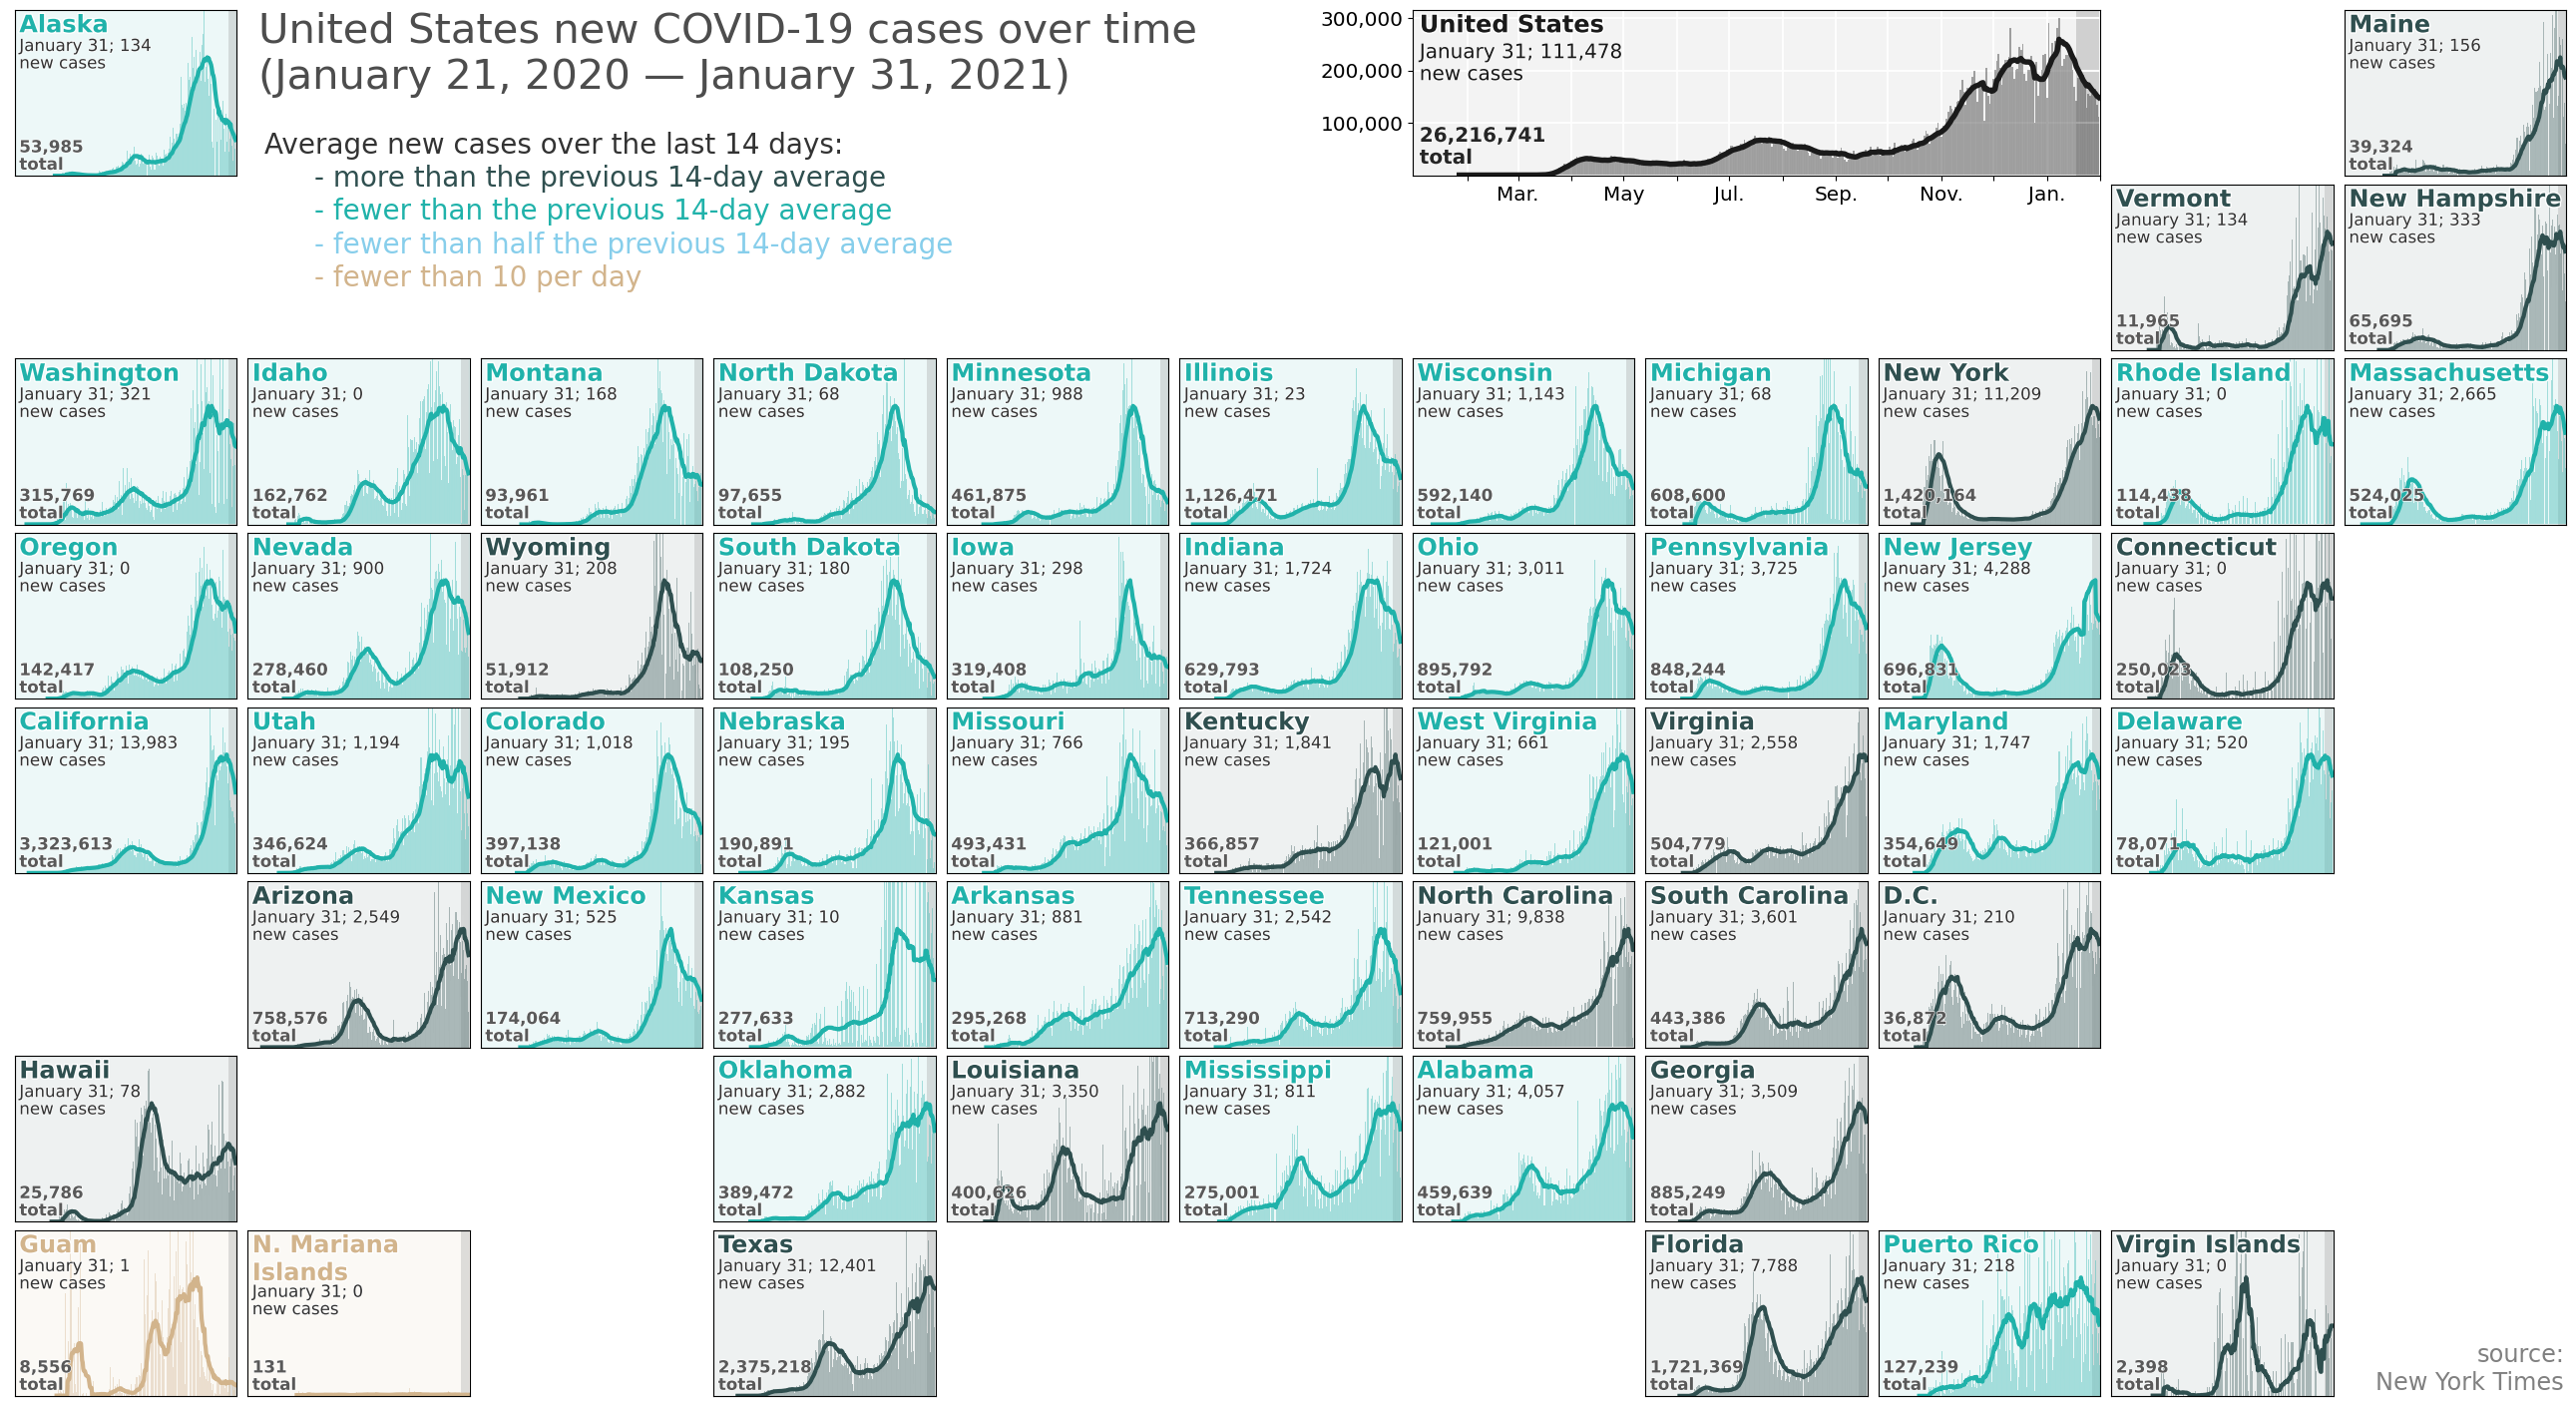

In [11]:
lw = 3
wid = 21
days_since = 14
min_c = 10

w = 3.0; h = 2.3
ncols = 11; nrows = 8
tups = list(it.product(range(nrows), range(ncols)))
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100)#, sharex=True)
plt.subplots_adjust(wspace=0.05,hspace=0.05)

for st, po in state_posx.items():
    stlab = all_state_names[st]
    ll_st = ll.loc[ll['state']==stlab].copy()

    xvals_st = [date_dict[i] for i in sorted(ll_st['date'].tolist())]
    yvals_st = np.nan_to_num(np.array(ll_st['new_cases'].rolling(window=wid).mean().tolist()))
    yvals_st[yvals_st<0] = 0
    yvals_st_raw = ll_st['new_cases'].tolist()
    total_cases_st = int(ll_st['cases'].values[-1])
    most_recent_cases_st = int(ll_st['new_cases'].values[-1])

    recent_average_curr = np.nanmean(yvals_st[(-days_since):])
    recent_average_prev = np.nanmean(yvals_st[(-2*days_since):(-days_since)])

    if recent_average_prev >= recent_average_curr:
        col_co = down_col
    if recent_average_prev <= recent_average_curr:
        col_co = up_col
    if recent_average_prev >= 2*recent_average_curr:
        col_co = vdown_col
    if recent_average_curr < min_c:
        col_co = low_col

    ax[po].plot(xvals_st, yvals_st, color=col_co, linewidth=lw)
    ax[po].bar(xvals_st, yvals_st_raw, color=col_co, alpha=0.4, width=1, linewidth=0.1, ec='w')

    if stlab == 'District of Columbia':
        stlab = 'D.C.'
    if stlab == 'Northern Mariana Islands':
        stlab = 'N. Mariana\nIslands'

    ax[po].text(0.02,0.98,stlab,fontsize='xx-large',va='top',ha='left',
                color=col_co,fontweight='bold',transform=ax[po].transAxes,
                path_effects=[path_effects.Stroke(linewidth=2, foreground='w'),
                              path_effects.Normal()])
    ax[po].text(0.02,0.02,'%s\ntotal'%("{:,}".format(total_cases_st)),
                fontsize='large',va='bottom',ha='left',
                color='.35',fontweight='bold',transform=ax[po].transAxes,
                path_effects=[path_effects.Stroke(linewidth=0.9, foreground='w'),
                              path_effects.Normal()])

    casey = 0.67 if '\n' in stlab else 0.825

    ax[po].text(0.02,casey,'%s; %s\nnew cases'%(ld[:-6], "{:,}".format(most_recent_cases_st)),
                fontsize='large',va='top',ha='left', color='.2',transform=ax[po].transAxes,
                path_effects=[path_effects.Stroke(linewidth=0.9, foreground='w'),
                              path_effects.Normal()])

    ylim_st = ax[po].get_ylim()
    xlim_st = ax[po].get_xlim()
    ydiff = ylim_st[1]-ylim_st[0]
    ylim_st = (0-ydiff*0.001, np.nanmax(yvals_st)*1.4)
    if np.nanmax(ll_st['cases'].diff()) < 110:
        ylim_st = (-1, 150)
        
    ax[po].set_ylim(ylim_st[0], ylim_st[1])
    ax[po].set_xlim(-1,xvals_st[-1]+2)
    ax[po].fill_between([-1,xvals_st[-1]+1],0-ydiff*0.02,ylim_st[1]*1.3,
                        color=col_co,alpha=0.08,zorder=0)
    ax[po].fill_between([xvals_st[-days_since],xvals_st[-1]+1],0-ydiff*0.02,ylim_st[1]*1.3,
                        color='.6',alpha=0.3,zorder=0, linewidth=0)

for tup in tups:
    if tup not in state_posx.values():
        ax[tup].set_axis_off()
    else:
        ax[tup].set_xticks([])
        ax[tup].set_yticks([])


stlab = 'United States'
usa_tots = ll.loc[ll['state']==stlab]
col_co = '.1'

xvals_st = [date_dict[i] for i in sorted(usa_tots['date'].tolist())]
yvals_st = usa_tots['new_cases'].rolling(window=7).mean().tolist()
yvals_st_raw = usa_tots['new_cases'].tolist()
total_cases_st = int(usa_tots['cases'].values[-1])
most_recent_cases_st = int(usa_tots['new_cases'].values[-1])

gs = ax[1, 8].get_gridspec()
for a in ax[0:1, 6:9].flatten():
    a.remove()
axbig = fig.add_subplot(gs[0:1, 6:9])

axbig.plot(xvals_st, yvals_st, color=col_co, linewidth=lw*1.3)
axbig.bar(xvals_st, yvals_st_raw, color=col_co, alpha=0.4, width=1, linewidth=0.1, ec='w')

axbig.text(0.01, 0.98, stlab, fontsize='xx-large', va='top', ha='left', color=col_co,
           fontweight='bold',transform=axbig.transAxes,
                path_effects=[path_effects.Stroke(linewidth=2, foreground='w'),
                              path_effects.Normal()])
axbig.text(0.01, 0.05, '%s\ntotal'%("{:,}".format(total_cases_st)), va='bottom', ha='left', color='.15',
           fontweight='bold', fontsize='x-large', transform=axbig.transAxes,
                path_effects=[path_effects.Stroke(linewidth=0.9, foreground='w'),
                              path_effects.Normal()])
axbig.text(0.01, 0.8, '%s; %s\nnew cases'%(ld[:-6], "{:,}".format(most_recent_cases_st)), color=col_co,
           va='top',ha='left', fontsize='x-large', transform=axbig.transAxes,
                path_effects=[path_effects.Stroke(linewidth=0.9, foreground='w'),
                              path_effects.Normal()])

ylim_st = axbig.get_ylim()
xlim_st = axbig.get_xlim()
ydiff = ylim_st[1] - ylim_st[0]
axbig.set_ylim(0-ydiff*0.005, ylim_st[1])
axbig.set_xlim(-1, xvals_st[-1]+1)

xtx = ['2020-02-01','2020-03-01','2020-04-01','2020-05-01','2020-06-01','2020-07-01','2020-08-01',
       '2020-09-01','2020-10-01','2020-11-01','2020-12-01','2021-01-01','2021-02-01']
xtxl = ['','Mar.','','May','','Jul.','','Sep.','','Nov.','','Jan.','']
ytx = [100000, 200000, 300000]
axbig.set_xticks([date_dict[i] for i in xtx])
axbig.set_yticks(ytx)
axbig.set_xticklabels([i for i in xtxl],fontsize='x-large')
axbig.set_yticklabels(["{:,}".format(i) for i in ytx],fontsize='x-large')
axbig.grid(linewidth=1.5,color='w',alpha=0.9)

axbig.fill_between([-1, xvals_st[-1]+1], 0-ydiff*0.02, ylim_st[1]*1.3,
                   color=col_co,alpha=0.05,zorder=0)
axbig.fill_between([xvals_st[-days_since], xvals_st[-1]+1], 0-ydiff*0.02, ylim_st[1]*1.3,
                   color='.5',alpha=0.3,zorder=0, linewidth=0)

ax[tups[-1]].text(0.99,0.01,'source:\nNew York Times',color='.5',fontsize='xx-large',
                va='bottom', ha='right', transform=ax[tups[-1]].transAxes)
ax[(0,1)].text(0.05,0.99,'United States new COVID-19 cases over time\n(%s — %s)'%(fd,ld),
               color='.3', fontsize=30, va='top', ha='left', transform=ax[(0,1)].transAxes)

ax[(1,1)].text(0.075,1.15,'Average new cases over the last %i days:'%(days_since),
                color='.2',fontsize=20, va='bottom', ha='left', transform=ax[(1,1)].transAxes)
ax[(1,1)].text(0.3,0.95,'- more than the previous %i-day average'%(days_since),
                color=up_col,fontsize=20, va='bottom', ha='left', transform=ax[(1,1)].transAxes)
ax[(1,1)].text(0.3,0.75,'- fewer than the previous %i-day average'%(days_since),
                color=down_col,fontsize=20, va='bottom', ha='left', transform=ax[(1,1)].transAxes)
ax[(1,1)].text(0.3,0.55,'- fewer than half the previous %i-day average'%(days_since),
                color=vdown_col,fontsize=20, va='bottom', ha='left', transform=ax[(1,1)].transAxes)
ax[(1,1)].text(0.3,0.35,'- fewer than %i per day'%(min_c),
                color=low_col,fontsize=20, va='bottom', ha='left', transform=ax[(1,1)].transAxes)

plt.savefig('../figs/pngs/state_subplot_casecounts_trends_inset.png', dpi=300, bbox_inches='tight')
plt.show()

# Grid cartogram of new deaths

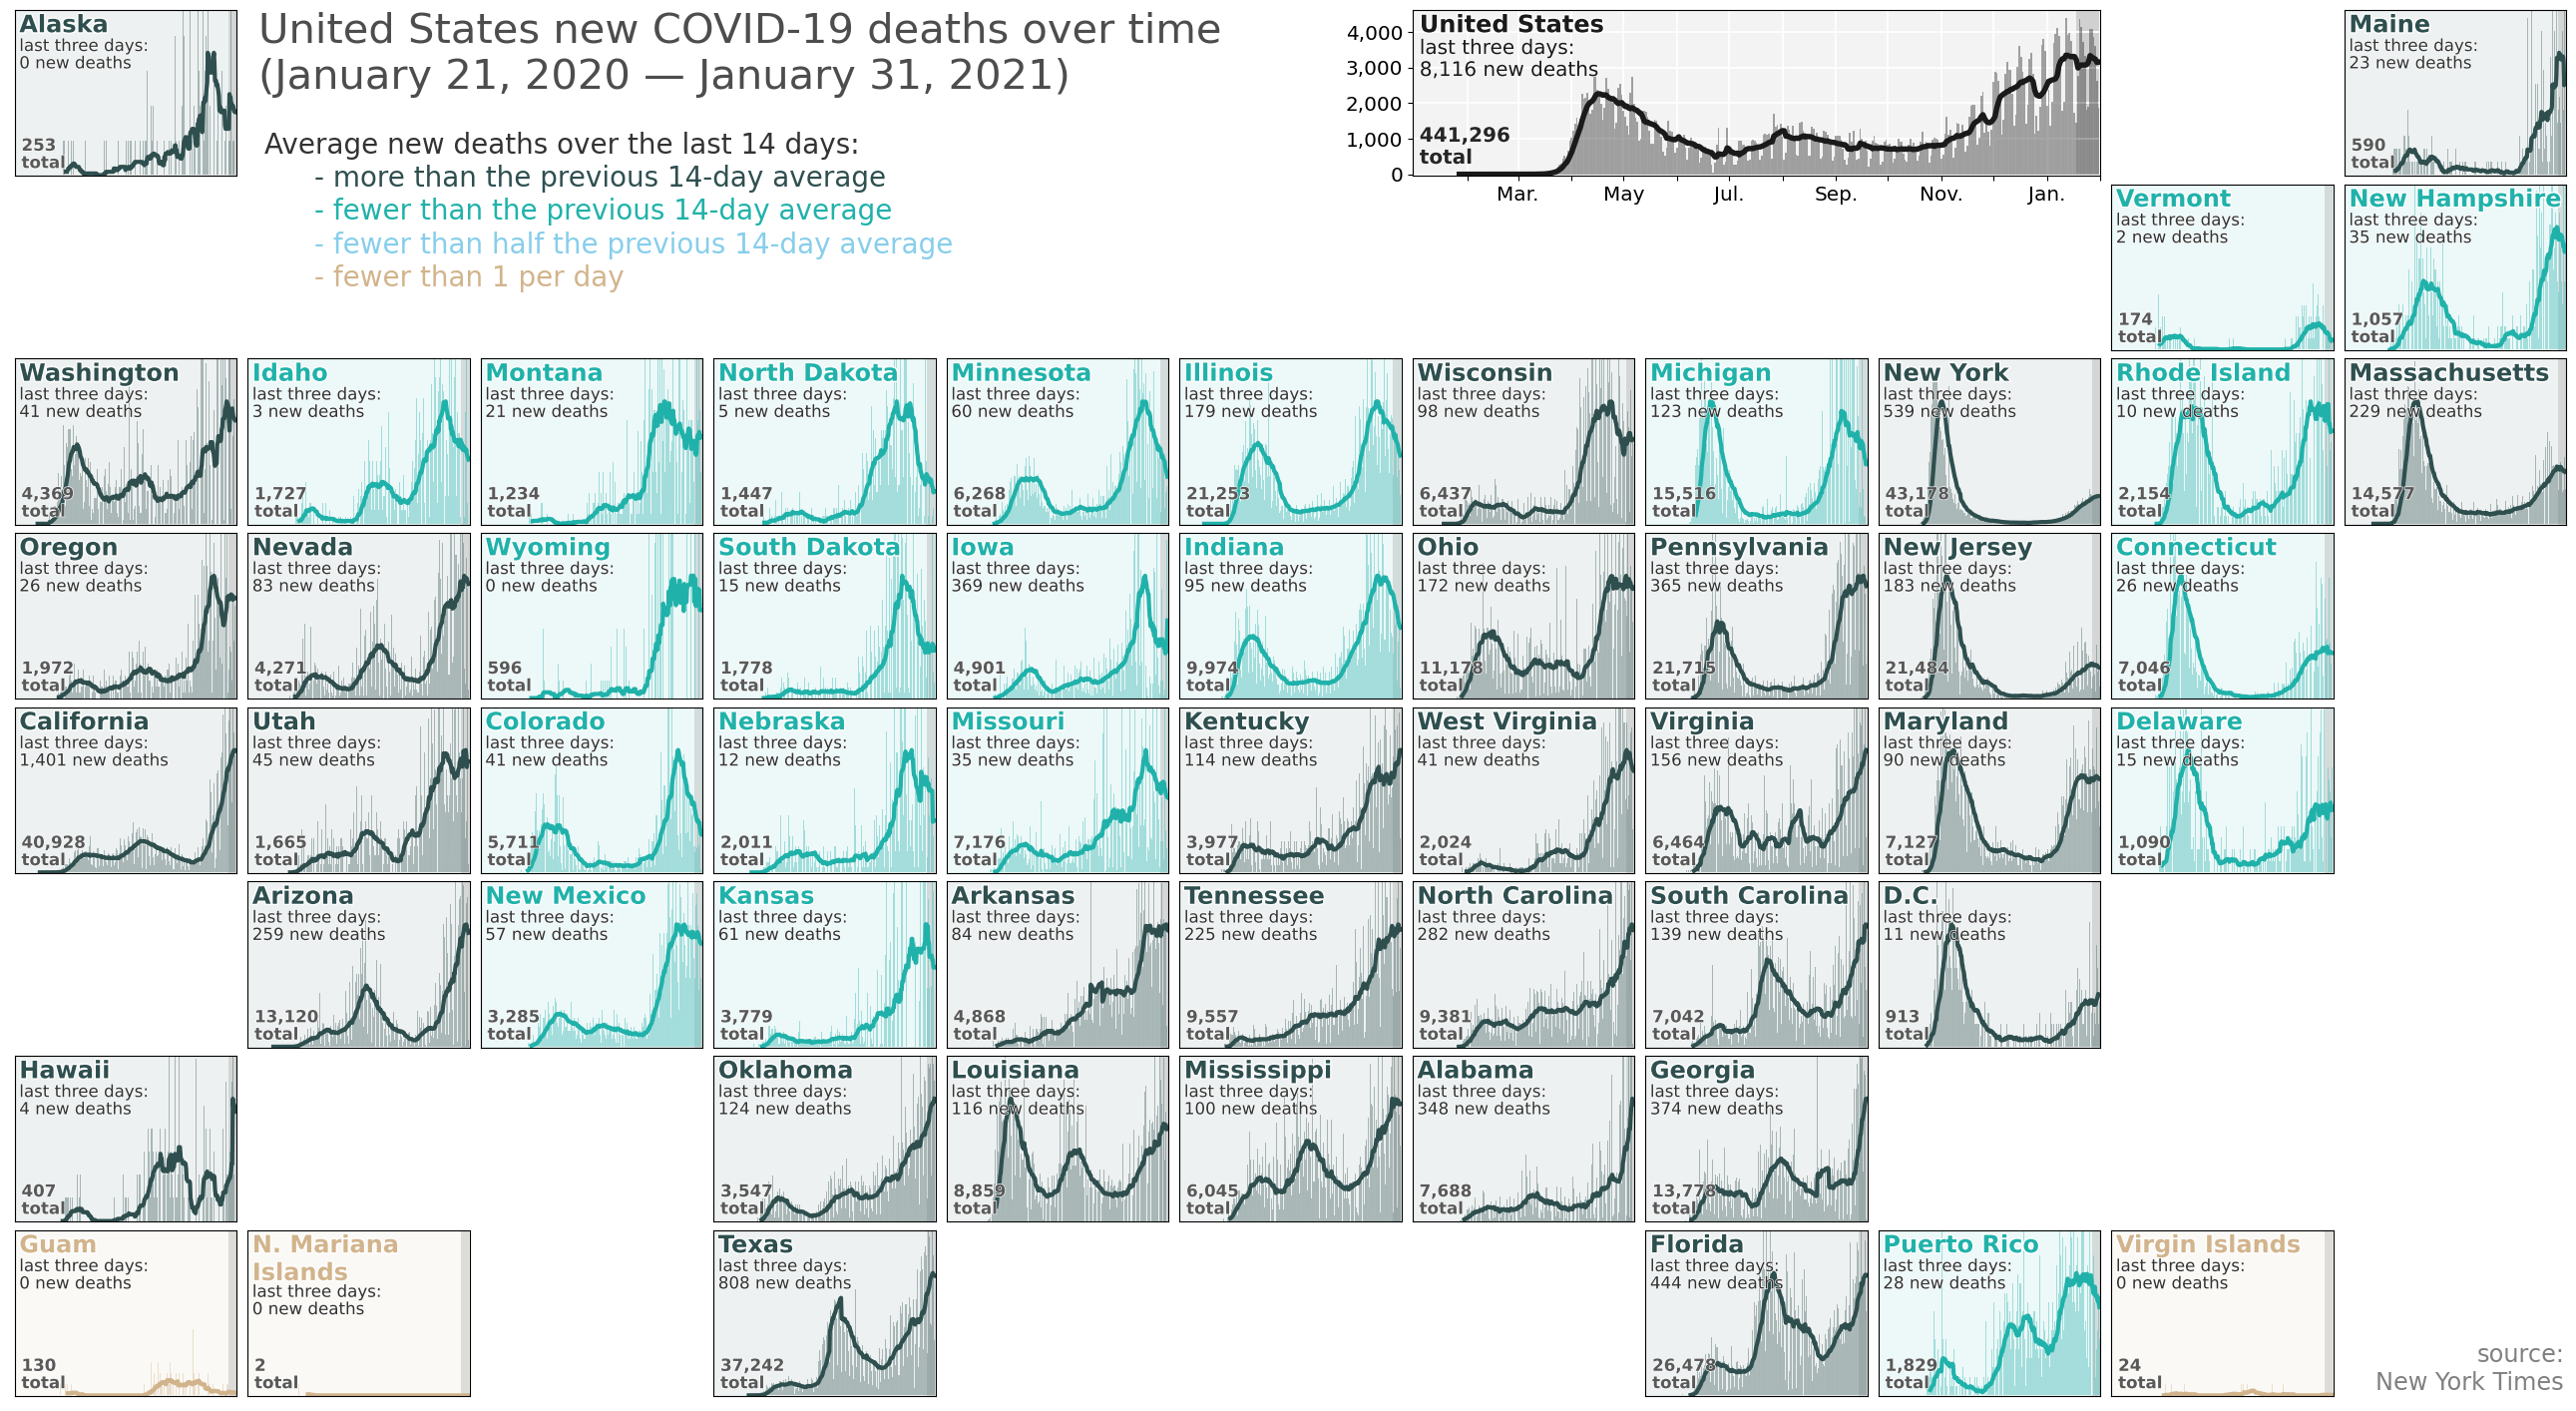

In [12]:
lw = 3
wid = 21
days_since = 14
min_c = 1

w = 3.0; h = 2.3
ncols = 11; nrows = 8
tups = list(it.product(range(nrows), range(ncols)))
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100)#, sharex=True)
plt.subplots_adjust(wspace=0.05,hspace=0.05)

for st, po in state_posx.items():
    stlab = all_state_names[st]
    ll_st = ll.loc[ll['state']==stlab].copy()
    total_deaths_st = int(ll_st['deaths'].tolist()[-1])

    xvals_st = [date_dict[i] for i in sorted(ll_st['date'].tolist())]
    yvals_st = ll_st['new_deaths'].rolling(window=wid).mean().tolist()
    yvals_st_raw = ll_st['new_deaths'].tolist()
    most_recent_deaths_st = int(ll_st['new_deaths'].values[-1])
    
    recent_average_curr = np.mean(yvals_st[(-days_since):])
    recent_average_prev = np.mean(yvals_st[(-2*days_since):(-days_since)])

    if recent_average_prev >= recent_average_curr:
        col_co = down_col
    if recent_average_prev <= recent_average_curr:
        col_co = up_col
    if recent_average_prev >= 2*recent_average_curr:
        col_co = vdown_col
    if recent_average_curr < min_c:
        col_co = low_col

    ax[po].plot(xvals_st, yvals_st, color=col_co, linewidth=lw)
    ax[po].bar(xvals_st, yvals_st_raw, color=col_co, alpha=0.4, width=1, linewidth=0.1, ec='w')

    if stlab == 'District of Columbia':
        stlab = 'D.C.'
    if stlab == 'Northern Mariana Islands':
        stlab = 'N. Mariana\nIslands'

    ax[po].text(0.02, 0.98, stlab, fontsize='xx-large', va='top', ha='left',
                color=col_co, fontweight='bold', transform=ax[po].transAxes,
                path_effects=[path_effects.Stroke(linewidth=2, foreground='w'),
                              path_effects.Normal()])
    ax[po].text(0.03, 0.03, '%s\ntotal'%("{:,}".format(total_deaths_st)), fontsize='large',
                va='bottom', ha='left', color='.35',fontweight='bold',transform=ax[po].transAxes,
                path_effects=[path_effects.Stroke(linewidth=0.9, foreground='w'),
                              path_effects.Normal()])

    casey = 0.67 if '\n' in stlab else 0.825
    newd_i = int(sum(yvals_st_raw[-3:])) if sum(yvals_st_raw[-3:]) >= 0 else 0
    death_str = 'deaths' if newd_i != 1 else 'death'

    ax[po].text(0.02, casey, '%s\n%s new %s'%('last three days:', "{:,}".format(newd_i), death_str),
                fontsize='large', va='top', ha='left', color='.2', transform=ax[po].transAxes,
                path_effects=[path_effects.Stroke(linewidth=0.9, foreground='w'),
                              path_effects.Normal()])

    ylim_st = ax[po].get_ylim()
    xlim_st = ax[po].get_xlim()
    ylim_st = (0, np.nanmax(yvals_st)*1.35) if np.nanmax(ll_st['deaths'].diff()) >= 15 else (0, 15)
    ydiff = ylim_st[1] - ylim_st[0]

    ax[po].set_ylim(0-ydiff*0.005, ylim_st[1])
    ax[po].set_xlim(-1, xvals_st[-1]+2)
    ax[po].fill_between([-1, xvals_st[-1]+1], 0-ydiff*0.02, ylim_st[1]*1.3,
                        color=col_co, alpha=0.08, zorder=0)
    ax[po].fill_between([xvals_st[-days_since], xvals_st[-1]+1], 0-ydiff*0.02, ylim_st[1]*1.3,
                        color='.6', alpha=0.3, zorder=0, linewidth=0)

for tup in tups:
    if tup not in state_posx.values():
        ax[tup].set_axis_off()
    else:
        ax[tup].set_xticks([])
        ax[tup].set_yticks([])

ax[tups[-1]].text(0.99,0.01,'source:\nNew York Times',color='.5',fontsize='xx-large',
                va='bottom', ha='right', transform=ax[tups[-1]].transAxes)
ax[(0,1)].text(0.05,0.99,'United States new COVID-19 deaths over time\n(%s — %s)'%(fd,ld),
               color='.3', fontsize=30, va='top', ha='left', transform=ax[(0,1)].transAxes)

ax[(1,1)].text(0.075,1.15,'Average new deaths over the last %i days:'%(days_since),
                color='.2',fontsize=20, va='bottom', ha='left', transform=ax[(1,1)].transAxes)
ax[(1,1)].text(0.3,0.95,'- more than the previous %i-day average'%(days_since),
                color=up_col,fontsize=20, va='bottom', ha='left', transform=ax[(1,1)].transAxes)
ax[(1,1)].text(0.3,0.75,'- fewer than the previous %i-day average'%(days_since),
                color=down_col,fontsize=20, va='bottom', ha='left', transform=ax[(1,1)].transAxes)
ax[(1,1)].text(0.3,0.55,'- fewer than half the previous %i-day average'%(days_since),
                color=vdown_col,fontsize=20, va='bottom', ha='left', transform=ax[(1,1)].transAxes)
ax[(1,1)].text(0.3,0.35,'- fewer than %i per day'%(min_c),
                color=low_col,fontsize=20, va='bottom', ha='left', transform=ax[(1,1)].transAxes)

col_co = '.1'
stlab = 'United States'
usa_tots = ll.loc[ll['state']==stlab].copy()
total_deaths_st = int(usa_tots['deaths'].tolist()[-1])

xvals_st = [date_dict[i] for i in sorted(usa_tots['date'].tolist())]
yvals_st = usa_tots['new_deaths'].rolling(window=7).mean().tolist()
yvals_st_raw = usa_tots['new_deaths'].tolist()
most_recent_deaths_st = int(usa_tots['new_deaths'].values[-1])

gs = ax[1, 8].get_gridspec()
for a in ax[0:1, 6:9].flatten():
    a.remove()
axbig = fig.add_subplot(gs[0:1, 6:9])

axbig.plot(xvals_st, yvals_st, color=col_co, linewidth=lw*1.3)
axbig.bar(xvals_st, yvals_st_raw, color=col_co, alpha=0.4, width=1, linewidth=0.1, ec='w')

newd_i = int(sum(yvals_st_raw[-3:]))
death_str = 'deaths'
casey = 0.825

axbig.text(0.01, 0.98, stlab, fontsize='xx-large', va='top', ha='left', 
           color=col_co, fontweight='bold', transform=axbig.transAxes,
           path_effects=[path_effects.Stroke(linewidth=2, foreground='w'),
                         path_effects.Normal()])
axbig.text(0.01, 0.05, '%s\ntotal'%("{:,}".format(total_deaths_st)), fontsize='x-large',
           va='bottom', ha='left', color='.15', fontweight='bold', transform=axbig.transAxes,
           path_effects=[path_effects.Stroke(linewidth=0.9, foreground='w'),
                         path_effects.Normal()])
axbig.text(0.01, casey, '%s\n%s new %s'%('last three days:', "{:,}".format(newd_i), death_str),
           fontsize='x-large', va='top', ha='left', color=col_co, transform=axbig.transAxes,
           path_effects=[path_effects.Stroke(linewidth=0.9, foreground='w'),
                         path_effects.Normal()])

ylim_st = axbig.get_ylim()
xlim_st = axbig.get_xlim()
ydiff = ylim_st[1] - ylim_st[0]

axbig.set_ylim(0-ydiff*0.01, ylim_st[1])
axbig.set_xlim(-1, xvals_st[-1]+1)

xtx = ['2020-02-01','2020-03-01','2020-04-01','2020-05-01','2020-06-01','2020-07-01','2020-08-01',
       '2020-09-01','2020-10-01','2020-11-01','2020-12-01','2021-01-01','2021-02-01']
xtxl = ['','Mar.','','May','','Jul.','','Sep.','','Nov.','','Jan.','']
ytx = [0, 1000, 2000, 3000, 4000]
axbig.set_xticks([date_dict[i] for i in xtx])
axbig.set_xticklabels([i for i in xtxl],fontsize='x-large')
axbig.set_yticks(ytx)
axbig.set_yticklabels(["{:,}".format(i) for i in ytx],fontsize='x-large')
axbig.grid(linewidth=1.5,color='w',alpha=0.9)

axbig.fill_between([-1,xvals_st[-1]+1],0-ydiff*0.02,ylim_st[1]*1.3,
                    color=col_co,alpha=0.05,zorder=0)
axbig.fill_between([xvals_st[-days_since],xvals_st[-1]+1],0-ydiff*0.02,ylim_st[1]*1.3,
                    color='.5',alpha=0.3,zorder=0, linewidth=0)

plt.savefig('../figs/pngs/state_subplot_deathcounts_trends_inset.png', dpi=300, bbox_inches='tight')
plt.show()

__________________

# Ridge plots

In [13]:
wid = 21
ordered_states = ll['state'].unique()
ordered_dict = {}
for st in ordered_states:
    if st in ['United States','Guam','Northern Mariana Islands','Virgin Islands']:
        continue
    ll_st = ll.loc[(ll['state']==st)].copy()
    temp = dict(zip(ll_st['date'],ll_st['new_cases']))
    padx = date_dict[ll_st['date'].values[0]]-date_dict['2020-01-21']
    xvals = [date_dict[i] for i in temp.keys()]
    yvals_st = np.nan_to_num(ll_st['new_cases'].rolling(window=wid).mean().values)
    if list(temp.keys())[0]>'2020-01-21':
        xvals = [0]*padx + list(xvals)
        yvals_st = [0]*padx + list(yvals_st)
    else:
        xvals = np.array(xvals)
    ordered_dict[st] = np.argmax(yvals_st)

ordered_dict = dict(sorted(ordered_dict.items(), key=lambda x: x[1]))
ordered_states = list(ordered_dict.keys())

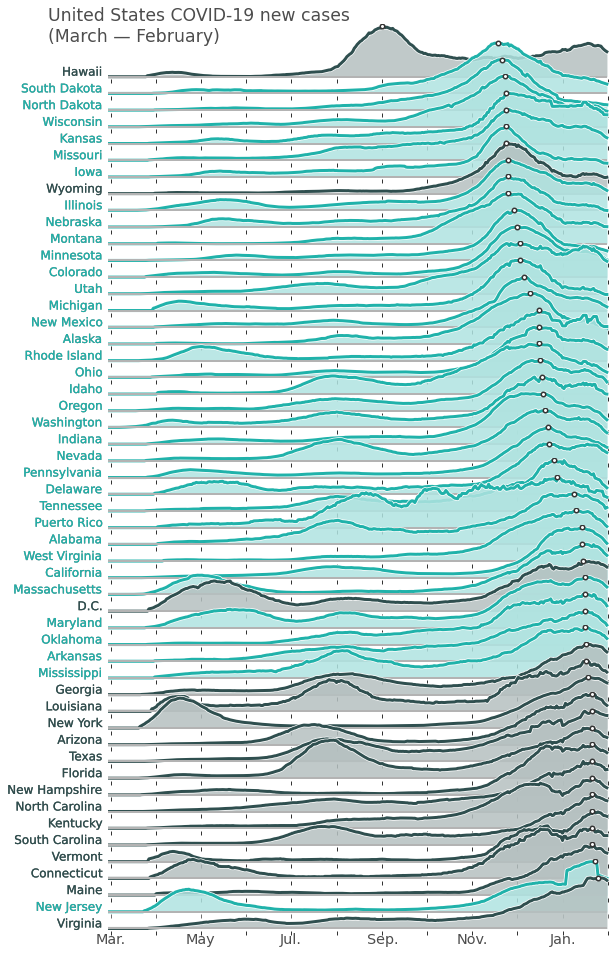

In [14]:
lw = 3
min_c = 10
xtx = ['2020-02-01','2020-03-01','2020-04-01','2020-05-01','2020-06-01','2020-07-01','2020-08-01',
       '2020-09-01','2020-10-01','2020-11-01','2020-12-01','2021-01-01','2021-02-01']
xtxl = ['','Mar.','','May','','Jul.','','Sep.','','Nov.','','Jan.','']

days_since = 14
from matplotlib import gridspec
nrows = 52
cols = plt.cm.gnuplot_r(np.linspace(0.1,0.9,nrows))
scatter_col = '.2'

np.random.shuffle(cols)
gs = gridspec.GridSpec(nrows+1, 1)
fig = plt.figure(figsize=(9, 17))

i = 1

ax_objs = []
for tup in range(1,nrows+1):
    st = ordered_states[tup-1]
    stlab = st

    ll_st = ll.loc[(ll['state']==st)].copy()
    temp = dict(zip(ll_st['date'],ll_st['new_cases']))
    padx = date_dict[ll_st['date'].values[0]]-date_dict['2020-01-21']
    xvals = [date_dict[i] for i in temp.keys()]
    yvals_st = np.nan_to_num(ll_st['new_cases'].rolling(window=wid).mean().values)
    if list(temp.keys())[0]>'2020-01-21':
        xvals = [0]*padx + list(xvals)
        yvals_st = [0]*padx + list(yvals_st)
    else:
        xvals = np.array(xvals)

    ax_objs.append(fig.add_subplot(gs[i:i+1, 0:]))
    recent_average_curr = np.nanmean(yvals_st[(-days_since):])
    recent_average_prev = np.nanmean(yvals_st[(-2*days_since):(-days_since)])

    if recent_average_prev >= recent_average_curr:
        col_co = down_col
    if recent_average_prev <= recent_average_curr:
        col_co = up_col
    if stlab == 'District of Columbia':
        stlab = 'D.C.'
    if stlab == 'Northern Mariana Islands':
        stlab = 'N. Mariana Islands'

    ymax_i = np.argmax(yvals_st)
    ymax = yvals_st[ymax_i]
    ax_objs[-1].plot(xvals, yvals_st, color=col_co, linewidth=lw,
                     path_effects=[path_effects.Stroke(linewidth=lw*1.5, foreground='w'),
                                   path_effects.Normal()])
    ax_objs[-1].scatter([ymax_i-1+date_dict['2020-01-21']], [ymax], c='w',
                        lw=lw/2, edgecolors=scatter_col,zorder=4, s=20)
    ax_objs[-1].fill_between(xvals, yvals_st, [0]*len(xvals), color='w', alpha=0.8,
                             linewidth=0.1, edgecolors='w')
    ax_objs[-1].fill_between(xvals, yvals_st, [0]*len(xvals), color=col_co, alpha=0.3,
                             linewidth=0.1, edgecolors='w')
    ax_objs[-1].hlines(0, date_dict['2020-02-28'], xvals[-1], color='.7', alpha=1, lw=2, zorder=5)

    rect = ax_objs[-1].patch
    rect.set_alpha(0)

    ax_objs[-1].set_yticks([])
    ax_objs[-1].set_yticklabels([])

    if i == nrows-1:
        ax_objs[-1].set_xticks([date_dict[i] for i in xtx])
        ax_objs[-1].set_xticklabels([i for i in xtxl],fontsize='x-large')
        ax_objs[-1].tick_params(axis="x", pad=15, colors='.3')

    else:
        ax_objs[-1].set_xticks([date_dict[i] for i in xtx])
        ax_objs[-1].set_xticklabels(['' for i in xtx])

    spines = ["top","right","left","bottom"]
    for s in spines:
        ax_objs[-1].spines[s].set_visible(False)

    ax_objs[-1].text(-0.01,0.01,stlab,transform=ax_objs[-1].transAxes,
                     fontsize='large',va='bottom',ha="right",color=col_co,alpha=0.99,
                     path_effects=[path_effects.Stroke(linewidth=0.2, foreground='.2'),
                                   path_effects.Normal()])
    ax_objs[-1].set_xlim(date_dict['2020-02-28'],xvals[-1]+2)

    i += 1

gs.update(hspace=-0.7)

fig.text(0.0325,0.88,'United States COVID-19 new cases\n(March — %s)'%month_dict[today.split('-')[1]],
               color='.3', fontsize='xx-large', va='top', ha='left')

plt.savefig('../figs/pngs/ridgeplot_cases.png', dpi=300, bbox_inches='tight')
plt.show()

# Ridge plot of cases per 1,000

In [15]:
regions_dict = {'Plains':['Iowa', 'Kansas', 'Minnesota', 'Missouri',
                          'Nebraska', 'North Dakota', 'South Dakota'],
                'Rocky Mountains':['Colorado', 'Idaho', 'Montana', 'Utah', 'Wyoming'],
                'Far West':['Alaska', 'California', 'Hawaii', 'Nevada', 'Oregon', 'Washington'],
                'Southwest':['Arizona', 'New Mexico', 'Oklahoma', 'Texas'],
                'Great Lakes':['Illinois', 'Indiana', 'Michigan', 'Ohio', 'Wisconsin'],
                'Southeast':['Alabama', 'Arkansas', 'Florida', 'Georgia', 'Kentucky', 'Louisiana',
                             'Mississippi', 'North Carolina', 'South Carolina', 'Tennessee',
                             'Virginia', 'West Virginia'],
                'New England':['Connecticut', 'Maine', 'Massachusetts', 'New Hampshire',
                               'Rhode Island', 'Vermont'],
                'Mid East':['Delaware', 'District of Columbia', 'Maryland', 'New Jersey',
                            'New York', 'Pennsylvania']}

reg_names = [[list(regions_dict.keys())[i]]*len(list(regions_dict.values())[i]) for i in range(len(regions_dict))]
reg_state = list(regions_dict.values())

flat_names = [item for sublist in reg_names for item in sublist]
flat_state = [item for sublist in reg_state for item in sublist]
region_df = pd.DataFrame({'region':flat_names,'state':flat_state})

In [16]:
ll = ll.merge(region_df, how='left', on='state')
ll.loc[ll.region.isna(),'region'] = 'other'

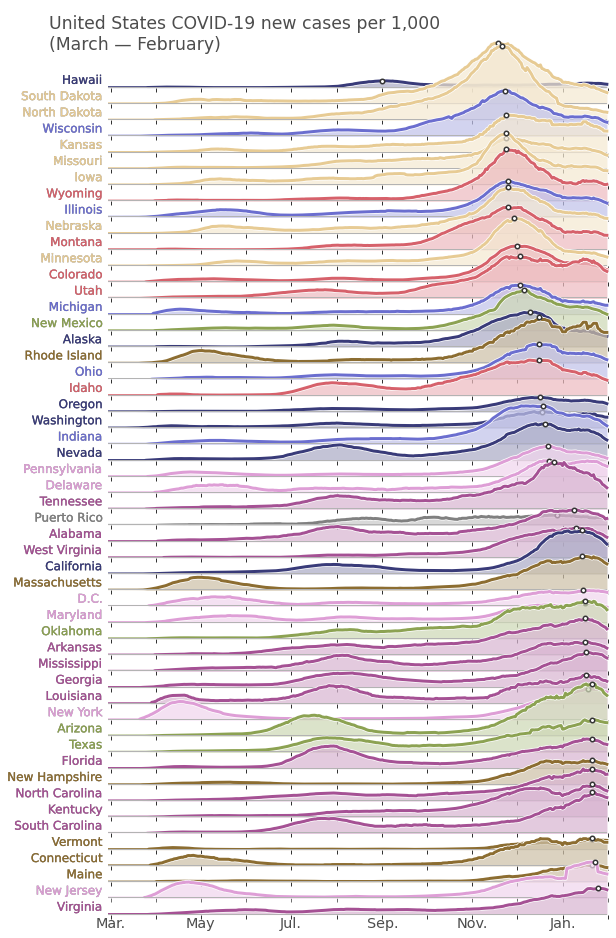

In [17]:
lw = 3
min_c = 10
xtx = ['2020-02-01','2020-03-01','2020-04-01','2020-05-01','2020-06-01','2020-07-01','2020-08-01',
       '2020-09-01','2020-10-01','2020-11-01','2020-12-01','2021-01-01','2021-02-01']
xtxl = ['','Mar.','','May','','Jul.','','Sep.','','Nov.','','Jan.','']


days_since = 14
from matplotlib import gridspec
nrows = 52
cols = plt.cm.tab20b(np.linspace(0,1,ll.region.nunique()-1))
cols = dict(zip(ll.region.unique()[1:],cols))
cols['other'] = '.5'
scatter_col = '.2'

gs = gridspec.GridSpec(nrows+1, 1)
fig = plt.figure(figsize=(9, 17))

i = 1

ax_objs = []
for tup in range(1,nrows+1):
    st = ordered_states[tup-1]
    stlab = st

    ll_st = ll.loc[(ll['state']==st)].copy()
    temp = dict(zip(ll_st['date'],ll_st['new_cases_per_1000']))
    padx = date_dict[ll_st['date'].values[0]]-date_dict['2020-01-21']
    xvals = [date_dict[i] for i in temp.keys()]
    yvals_st = np.nan_to_num(ll_st['new_cases_per_1000'].rolling(window=wid).mean().values)
    if list(temp.keys())[0]>'2020-01-21':
        xvals = [0]*padx + list(xvals)
        yvals_st = [0]*padx + list(yvals_st)
    else:
        xvals = np.array(xvals)

    ax_objs.append(fig.add_subplot(gs[i:i+1, 0:]))
    recent_average_curr = np.nanmean(yvals_st[(-days_since):])
    recent_average_prev = np.nanmean(yvals_st[(-2*days_since):(-days_since)])

    if recent_average_prev >= recent_average_curr:
        col_co = down_col
    if recent_average_prev <= recent_average_curr:
        col_co = up_col
    if stlab == 'District of Columbia':
        stlab = 'D.C.'
    if stlab == 'Northern Mariana Islands':
        stlab = 'N. Mariana Islands'

    ymax_i = np.argmax(yvals_st)
    ymax = yvals_st[ymax_i]
    col_co = cols[ll_st['region'].unique()[0]]
    ax_objs[-1].plot(xvals, yvals_st, color=col_co, linewidth=lw,
                     path_effects=[path_effects.Stroke(linewidth=lw*1.5, foreground='w'),
                                   path_effects.Normal()])
    ax_objs[-1].scatter([ymax_i-1+date_dict['2020-01-21']], [ymax], c='w',
                        lw=lw/2, edgecolors=scatter_col,zorder=4, s=20)
    ax_objs[-1].fill_between(xvals, yvals_st, [0]*len(xvals), color='w', alpha=0.6,
                             linewidth=0.1, edgecolors='w')
    ax_objs[-1].fill_between(xvals, yvals_st, [0]*len(xvals), color=col_co, alpha=0.3,
                             linewidth=0.1, edgecolors='w')
    ax_objs[-1].hlines(0, date_dict['2020-02-28'], xvals[-1], color='.7', alpha=1, lw=2, zorder=5)

    rect = ax_objs[-1].patch
    rect.set_alpha(0)

    ax_objs[-1].set_yticks([])
    ax_objs[-1].set_yticklabels([])

    if i == nrows-1:
        ax_objs[-1].set_xticks([date_dict[i] for i in xtx])
        ax_objs[-1].set_xticklabels([i for i in xtxl],fontsize='x-large')
        ax_objs[-1].tick_params(axis="x", pad=15, colors='.3')

    else:
        ax_objs[-1].set_xticks([date_dict[i] for i in xtx])
        ax_objs[-1].set_xticklabels(['' for i in xtx])

    spines = ["top","right","left","bottom"]
    for s in spines:
        ax_objs[-1].spines[s].set_visible(False)

    ax_objs[-1].text(-0.01,0.01,stlab,transform=ax_objs[-1].transAxes,
                     fontsize='large',va='bottom',ha="right",color=col_co,alpha=0.99,
                     path_effects=[path_effects.Stroke(linewidth=0.2, foreground='.2'),
                                   path_effects.Normal()])
    ax_objs[-1].set_xlim(date_dict['2020-02-28'],xvals[-1]+2)
    ax_objs[-1].set_ylim(0,2.0)

    i += 1

gs.update(hspace=-0.8)

fig.text(0.035,0.86,'United States COVID-19 new cases per 1,000\n(March — %s)'%month_dict[today.split('-')[1]],
               color='.3', fontsize='xx-large', va='top', ha='left')

plt.savefig('../figs/pngs/ridgeplot_cases_per_1000.png', dpi=300, bbox_inches='tight')
plt.show()

# Ridge plot of cases all on the same scale

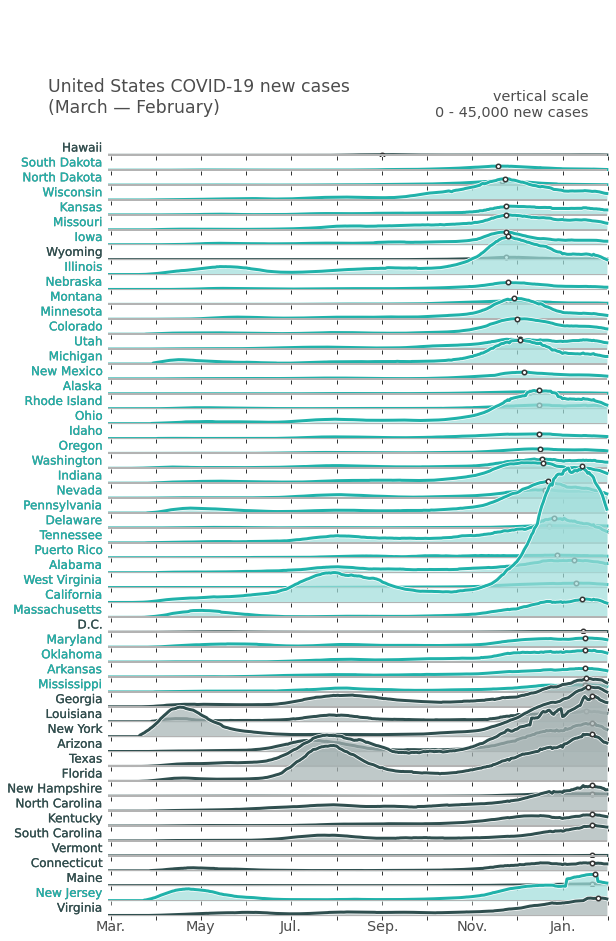

In [18]:
min_c = 10
xtx = ['2020-02-01','2020-03-01','2020-04-01','2020-05-01','2020-06-01','2020-07-01','2020-08-01',
       '2020-09-01','2020-10-01','2020-11-01','2020-12-01','2021-01-01','2021-02-01']
xtxl = ['','Mar.','','May','','Jul.','','Sep.','','Nov.','','Jan.','']


days_since = 14
from matplotlib import gridspec
nrows = 52

gs = gridspec.GridSpec(nrows+1, 1)
fig = plt.figure(figsize=(9, 17))
scatter_col = '.2'

i = 1

ax_objs = []
for tup in range(1,nrows+1):
    st = ordered_states[tup-1]
    stlab = st

    ll_st = ll.loc[(ll['state']==st)].copy()
    temp = dict(zip(ll_st['date'],ll_st['new_cases']))
    padx = date_dict[ll_st['date'].values[0]]-date_dict['2020-01-21']
    xvals = [date_dict[i] for i in temp.keys()]
    yvals_st = np.nan_to_num(ll_st['new_cases'].rolling(window=wid).mean().values)
    if list(temp.keys())[0]>'2020-01-21':
        xvals = [0]*padx + list(xvals)
        yvals_st = [0]*padx + list(yvals_st)
    else:
        xvals = np.array(xvals)

    ax_objs.append(fig.add_subplot(gs[i:i+1, 0:]))
    recent_average_curr = np.nanmean(yvals_st[(-days_since):])
    recent_average_prev = np.nanmean(yvals_st[(-2*days_since):(-days_since)])

    if recent_average_prev >= recent_average_curr:
        col_co = down_col
    if recent_average_prev <= recent_average_curr:
        col_co = up_col
    if stlab == 'District of Columbia':
        stlab = 'D.C.'
    if stlab == 'Northern Mariana Islands':
        stlab = 'N. Mariana Islands'
    
    ymax_i = np.argmax(yvals_st)
    ymax = yvals_st[ymax_i]
    ax_objs[-1].plot(xvals, yvals_st, color=col_co, linewidth=lw,
                     path_effects=[path_effects.Stroke(linewidth=lw*1.5, foreground='w'),
                                   path_effects.Normal()])
    ax_objs[-1].scatter([ymax_i-1+date_dict['2020-01-21']], [ymax], c='w',
                        lw=lw/2, edgecolors=scatter_col,zorder=4, s=20)
    ax_objs[-1].fill_between(xvals, yvals_st, [0]*len(xvals), color='w', alpha=0.6,
                             linewidth=0.1, edgecolors='w')
    ax_objs[-1].fill_between(xvals, yvals_st, [0]*len(xvals), color=col_co, alpha=0.3,
                             linewidth=0.1, edgecolors='w')
    ax_objs[-1].hlines(0, date_dict['2020-02-28'], xvals[-1], color='.7', alpha=1, lw=2, zorder=5)

    rect = ax_objs[-1].patch
    rect.set_alpha(0)

    ax_objs[-1].set_yticks([])
    ax_objs[-1].set_yticklabels([])

    if i == nrows-1:
        ax_objs[-1].set_xticks([date_dict[i] for i in xtx])
        ax_objs[-1].set_xticklabels([i for i in xtxl],fontsize='x-large')
        ax_objs[-1].tick_params(axis="x", pad=15, colors='.3')
        
    else:
        ax_objs[-1].set_xticks([date_dict[i] for i in xtx])
        ax_objs[-1].set_xticklabels(['' for i in xtx])

    spines = ["top","right","left","bottom"]
    for s in spines:
        ax_objs[-1].spines[s].set_visible(False)

    ax_objs[-1].text(-0.01,0.01,stlab,transform=ax_objs[-1].transAxes,
                     fontsize='large',va='bottom',ha="right",color=col_co,alpha=0.99,
                     path_effects=[path_effects.Stroke(linewidth=0.2, foreground='.2'),
                                   path_effects.Normal()])
    ax_objs[-1].set_xlim(date_dict['2020-02-28'],xvals[-1]+2)
    ax_objs[-1].set_ylim(-200,45000)
    ax_objs[-1].spines['bottom'].set_color('.5')
    ax_objs[-1].spines['bottom'].set_color('.5')

    i += 1

gs.update(hspace=-0.9)

fig.text(0.0325,0.81,'United States COVID-19 new cases\n(March — %s)'%month_dict[today.split('-')[1]],
               color='.3', fontsize='xx-large', va='top', ha='left')
fig.text(0.8675,0.80,'vertical scale\n0 - 45,000 new cases',
               color='.3', fontsize='x-large', va='top', ha='right')

plt.savefig('../figs/pngs/ridgeplot_cases_samescale.png', dpi=300, bbox_inches='tight')
plt.show()

___________

# Correlations

In [19]:
from scipy.stats import linregress

In [20]:
# Define function for string formatting of scientific notation
def sci_notation(num, decimal_digits=1, precision=None, exponent=None):
    """
    Returns a string representation of the scientific
    notation of the given number formatted for use with
    LaTeX or Mathtext, with specified number of significant
    decimal digits and precision (number of decimal digits
    to show). The exponent to be used can also be specified
    explicitly.
    """
    if exponent is None:
        exponent = int(np.floor(np.log10(abs(num))))
    coeff = round(num / float(10**exponent), decimal_digits)
    if precision is None:
        precision = decimal_digits

    return r"${0:.{2}f}\cdot10^{{{1:d}}}$".format(coeff, exponent, precision)


In [21]:
state_posx_lim = state_posx.copy()
del state_posx_lim['gu']
del state_posx_lim['pr']
del state_posx_lim['vi']
del state_posx_lim['mp']

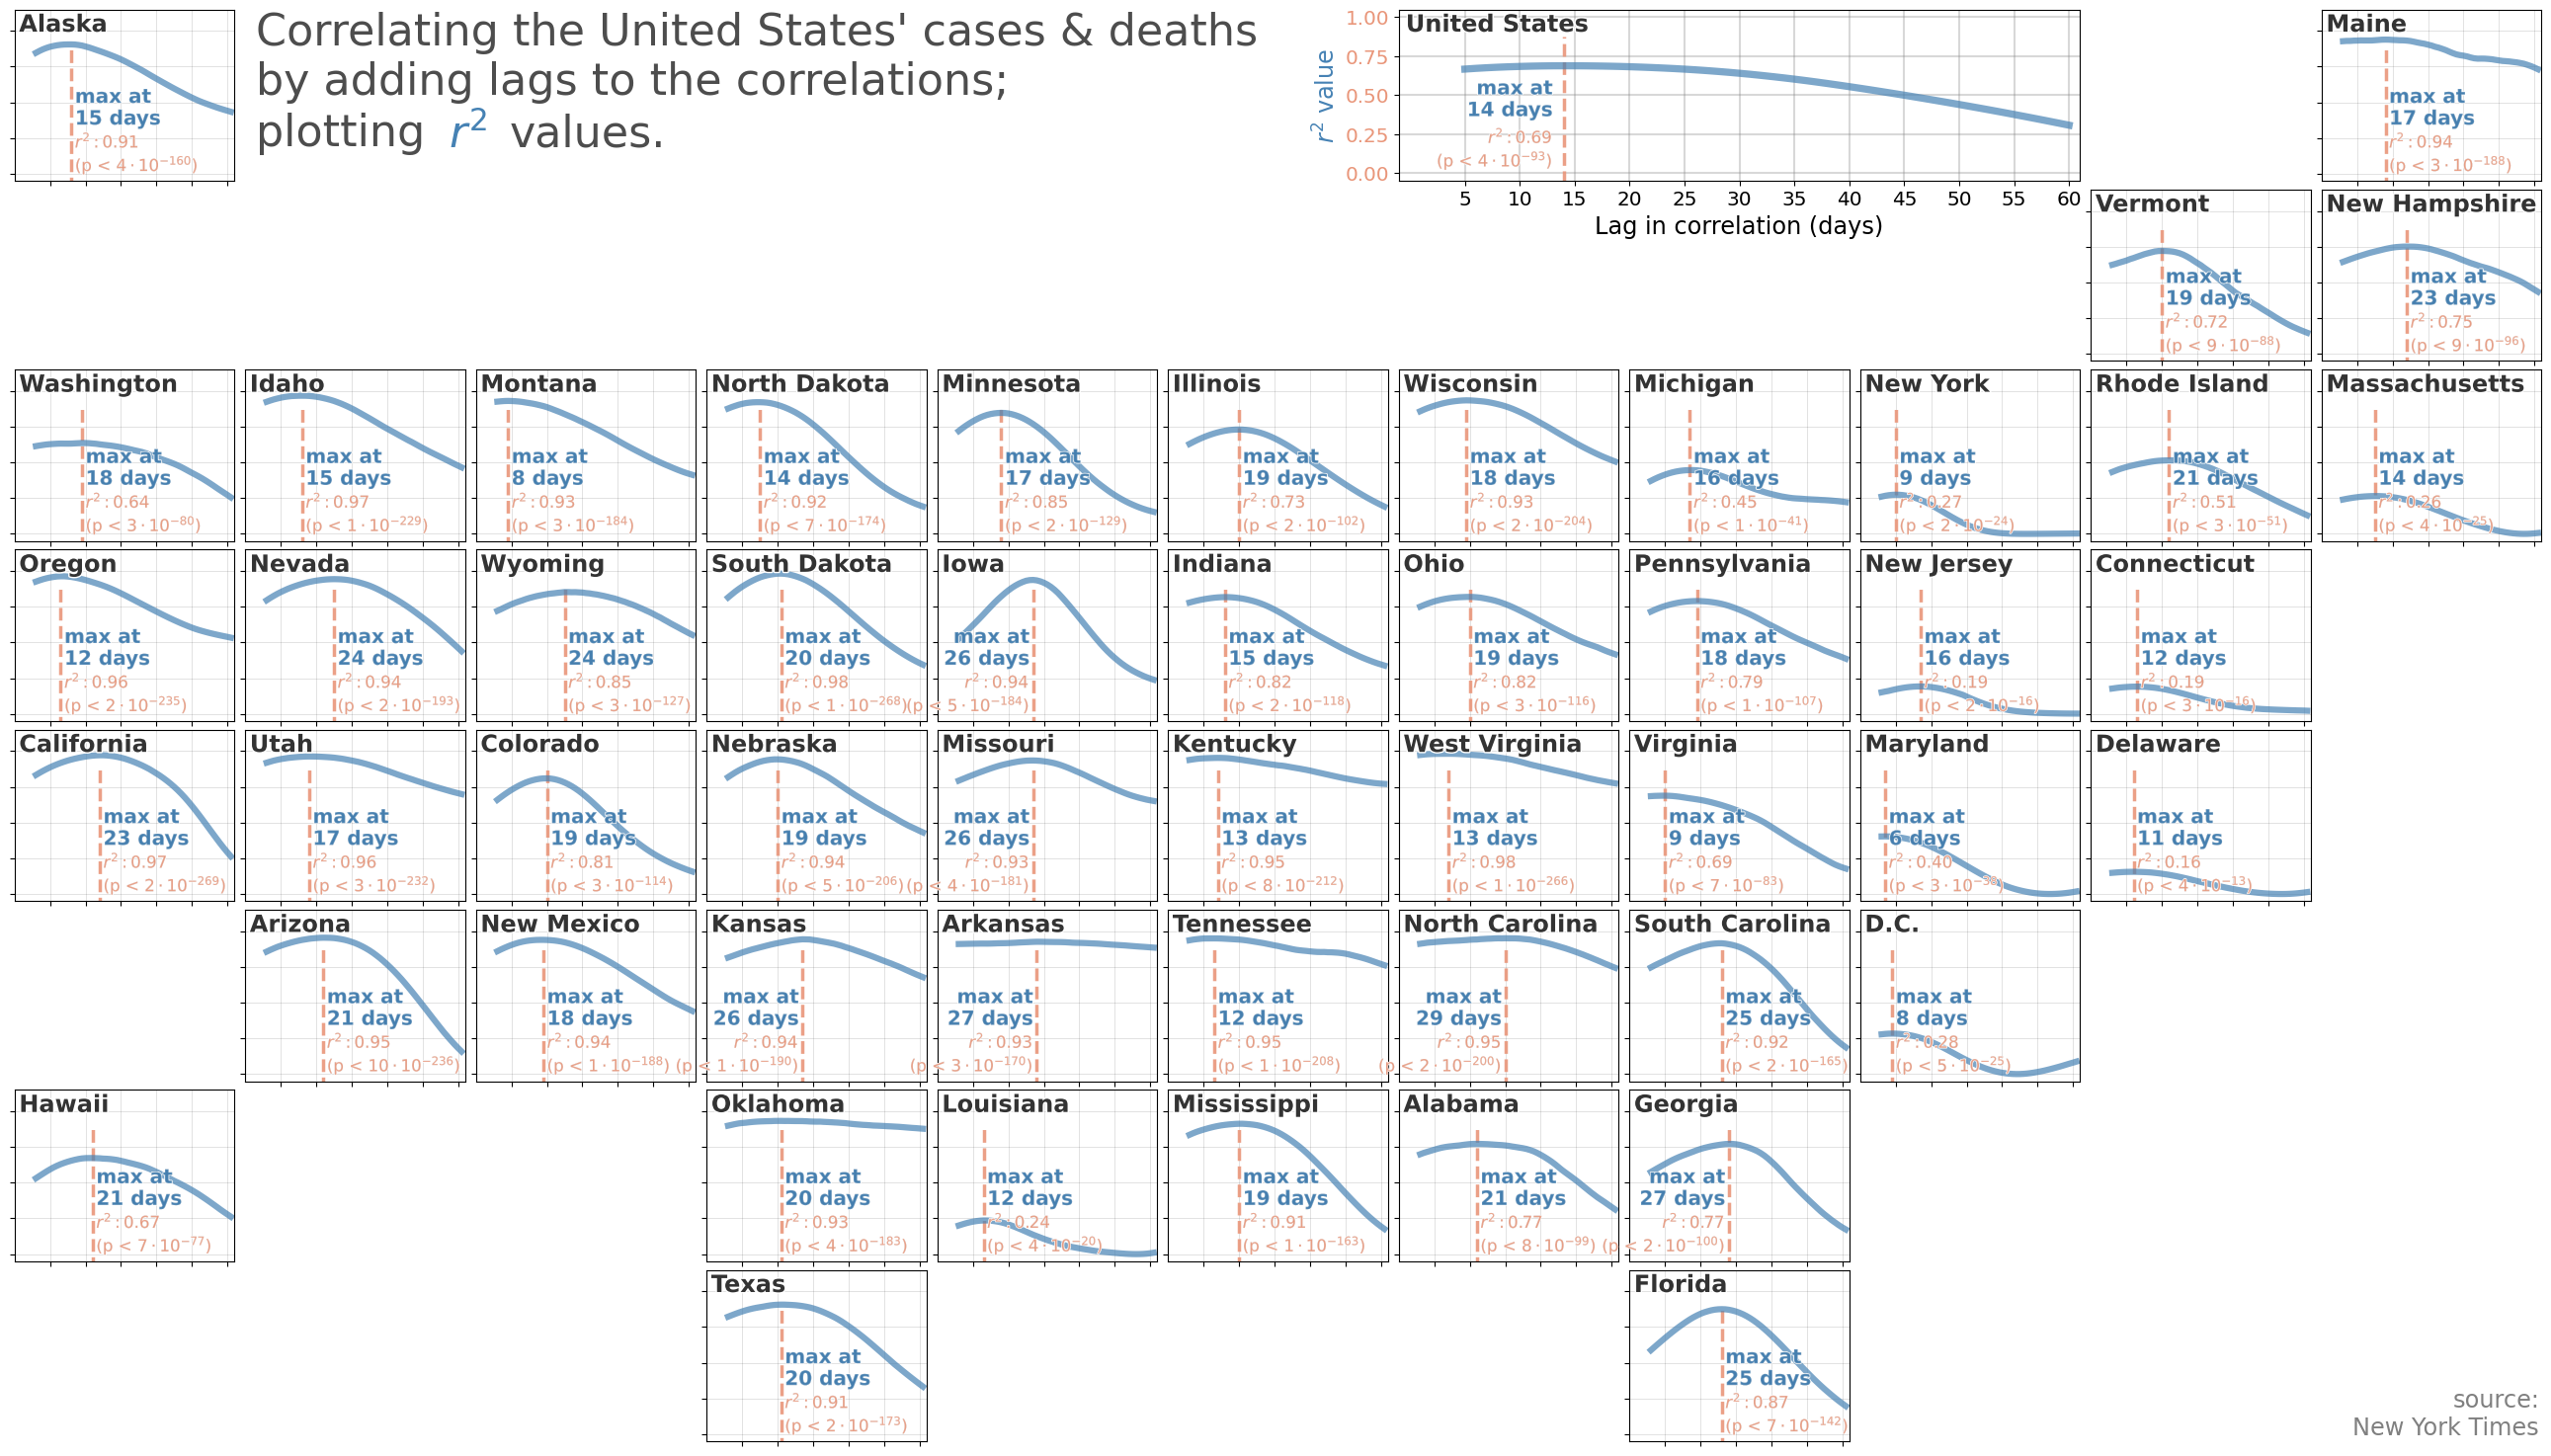

In [22]:
w = 3.0
h = 2.4
ncols = 11
nrows = 8
tups = list(it.product(range(nrows), range(ncols)))

col_co = '.2'
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100, sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.05,hspace=0.05)

test_st = {}

for st, po in state_posx_lim.items():
    stlab = all_state_names[st]
    ll_st = ll.loc[(ll['state']==stlab)].copy()
    
    delays = list(range(5,61))
    r_delays = {}
    p_delays = {}
    for d in delays:
        xcases = np.nan_to_num(ll_st['new_cases'].rolling(window=wid).mean().values)[:-d]
        ydeaths = np.nan_to_num(ll_st['new_deaths'].rolling(window=wid).mean().values)[d:]
        sl_d, int_d, rva_d, pva_d, _ = linregress(xcases,ydeaths)
        r_delays[d] = rva_d**2
        p_delays[d] = pva_d

    xvals_st = list(r_delays.keys())
    yvals_st_r = list(r_delays.values())

    ax[po].plot(xvals_st, yvals_st_r, color='steelblue', linewidth=lw*1.5, alpha=0.7)
    ax[po].vlines(np.array(xvals_st)[np.argmax(np.nan_to_num(yvals_st_r))], -1, 0.875,
                  linestyle='--', color='darksalmon', linewidth=2.5, alpha=0.9)
    test_st[stlab] = np.array(xvals_st)[np.argmax(np.nan_to_num(yvals_st_r))]
    if stlab == 'District of Columbia':
        stlab = 'D.C.'
    if stlab == 'Northern Mariana Islands':
        stlab = 'N. Mariana\nIslands'

    ax[po].text(0.02,0.98,stlab,fontsize='xx-large',va='top',ha='left',
                color=col_co,fontweight='bold',transform=ax[po].transAxes,
                path_effects=[path_effects.Stroke(linewidth=2, foreground='w'),
                              path_effects.Normal()])

    x1 = np.array(xvals_st)[np.argmax(np.nan_to_num(yvals_st_r))]+1
    lr1 = 'left' if x1 < xvals_st[-1]*0.45 else 'right'
    if lr1 == 'right':
        x1 -= 2

    ax[po].text(x1, 0.6, 'max at\n%i days'%max(r_delays, key=r_delays.get),
           fontsize='x-large',va='top',ha=lr1, color='.2', fontweight='bold',
                path_effects=[path_effects.Stroke(linewidth=0.9, foreground='w'),
                              path_effects.Normal()])
    ax[po].text(x1, 0.6, 'max at\n%i days'%max(r_delays, key=r_delays.get),
           fontsize='x-large',va='top',ha=lr1, color='steelblue', alpha=0.8, fontweight='bold',
                path_effects=[path_effects.Stroke(linewidth=0.9, foreground='w'),
                              path_effects.Normal()])
    ax[po].text(x1, 0.3, r'$r^2: %.2f$'%max(list(r_delays.values()))+\
           '\n(p < %s)'%sci_notation(p_delays[max(r_delays, key=r_delays.get)],decimal_digits=0),
           fontsize='large',va='top',ha=lr1, color='.2',
                path_effects=[path_effects.Stroke(linewidth=0.9, foreground='w'),
                              path_effects.Normal()])
    ax[po].text(x1, 0.3, r'$r^2: %.2f$'%max(list(r_delays.values()))+\
           '\n(p < %s)'%sci_notation(p_delays[max(r_delays, key=r_delays.get)],decimal_digits=0),
           fontsize='large',va='top',ha=lr1, color='darksalmon', alpha=0.8,
                path_effects=[path_effects.Stroke(linewidth=0.9, foreground='w'),
                              path_effects.Normal()])

    ax[po].set_ylim(-0.05, 1.15)
    ax[po].set_xlim(np.nonzero(np.nan_to_num(yvals_st_r))[0][0]-1,xvals_st[-1]+1)
    xtx = delays[4::10]
    ytx = [0.0,0.25,0.5,0.75,1.0]
    ax[po].set_xticks(xtx)
    ax[po].set_xticklabels(['' for i in xtx])
    ax[po].set_yticks(ytx)
    ax[po].set_yticklabels(['' for i in ytx])   
    ax[po].grid(linewidth=0.5,color='.2',alpha=0.2)

    
for tup in tups:
    if tup not in state_posx_lim.values():
        ax[tup].set_axis_off()

ax[tups[-1]].text(0.99,0.01,'source:\nNew York Times',color='.5',fontsize='xx-large',
                va='bottom', ha='right', transform=ax[tups[-1]].transAxes)
ax[(0,1)].text(0.05,0.99,
   "Correlating the United States' cases & deaths\nby adding lags to the correlations;\n",
               color='.3', fontsize=32, va='top', ha='left', transform=ax[(0,1)].transAxes)
ax[(0,1)].text(0.05,0.4, "plotting", color='.3', fontsize=32,
               va='top', ha='left', transform=ax[(0,1)].transAxes)
ax[(0,1)].text(0.925,0.4, r"$r^2$", color='steelblue', fontsize=32,
               va='top', ha='left', transform=ax[(0,1)].transAxes)
ax[(0,1)].text(1.2,0.4, "values.", color='.3', fontsize=32,
               va='top', ha='left', transform=ax[(0,1)].transAxes)

usa_tots = ll.groupby(['date']).agg({'new_cases':np.nansum,'new_deaths':np.nansum,
                                     'population':'sum'}).reset_index()

r_delays = {}
p_delays = {}
for d in delays:
    xcases = np.nan_to_num(usa_tots['new_cases'].rolling(window=wid).mean().values)[:-d]
    ydeaths = np.nan_to_num(usa_tots['new_deaths'].rolling(window=wid).mean().values)[d:]
    sl_d, int_d, rva_d, pva_d, _ = linregress(xcases, ydeaths)
    r_delays[d] = rva_d**2
    p_delays[d] = pva_d

xvals_st = list(r_delays.keys())
yvals_st_r = list(r_delays.values())

gs = ax[1, 8].get_gridspec()
for a in ax[0:1, 6:9].flatten():
    a.remove()
axbig = fig.add_subplot(gs[0:1, 6:9])

stlab = 'United States'
axbig.plot(xvals_st, yvals_st_r, color='steelblue', linewidth=lw*1.75, alpha=0.7)
axbig.vlines(np.array(xvals_st)[np.argmax(np.nan_to_num(yvals_st_r))], -1, 0.875,
              linestyle='--', color='darksalmon', linewidth=2.5, alpha=0.9)
test_st[stlab] = np.array(xvals_st)[np.argmax(np.nan_to_num(yvals_st_r))]

axbig.text(0.01,0.98,stlab,fontsize='xx-large',va='top',ha='left',
           color=col_co,fontweight='bold',transform=axbig.transAxes,
           path_effects=[path_effects.Stroke(linewidth=2, foreground='w'), path_effects.Normal()])

ydiff = np.nanmax(yvals_st_r)-np.nanmin(yvals_st_r)
axbig.text(np.array(xvals_st)[np.argmax(np.nan_to_num(yvals_st_r))]-1, 0.6,
           'max at\n%i days'%np.array(xvals_st)[np.argmax(np.nan_to_num(yvals_st_r))],
           fontsize='x-large',va='top',ha='right', color='.2', fontweight='bold',
           path_effects=[path_effects.Stroke(linewidth=0.9, foreground='w'), path_effects.Normal()])
axbig.text(np.array(xvals_st)[np.argmax(np.nan_to_num(yvals_st_r))]-1, 0.6,
           'max at\n%i days'%np.array(xvals_st)[np.argmax(np.nan_to_num(yvals_st_r))],
           fontsize='x-large',va='top',ha='right', color='steelblue', alpha=0.8, fontweight='bold',
           path_effects=[path_effects.Stroke(linewidth=0.9, foreground='w'),  path_effects.Normal()])
axbig.text(np.array(xvals_st)[np.argmax(np.nan_to_num(yvals_st_r))]-1, 0.3,
           r'$r^2: %.2f$'%np.nanmax(yvals_st_r)+\
           '\n(p < %s)'%sci_notation(p_delays[np.argmax(np.nan_to_num(yvals_st_r))],decimal_digits=0),
           fontsize='large',va='top',ha='right', color='.2',
           path_effects=[path_effects.Stroke(linewidth=0.9, foreground='w'), path_effects.Normal()])
axbig.text(np.array(xvals_st)[np.argmax(np.nan_to_num(yvals_st_r))]-1, 0.3,
           r'$r^2: %.2f$'%np.nanmax(yvals_st_r)+\
           '\n(p < %s)'%sci_notation(p_delays[np.argmax(np.nan_to_num(yvals_st_r))],decimal_digits=0),
           fontsize='large',va='top',ha='right', color='darksalmon', alpha=0.8,
           path_effects=[path_effects.Stroke(linewidth=0.9, foreground='w'), path_effects.Normal()])

axbig.set_ylim(-0.05, 1.05)

xtx = delays[0::5]
axbig.set_xticks(xtx)
axbig.set_xticklabels(xtx,fontsize='x-large')
axbig.set_yticks([0.0,0.25,0.5,0.75,1.0])
axbig.set_yticklabels(["%.2f"%i for i in [0.0,0.25,0.5,0.75,1.0]],fontsize='x-large')
axbig.set_ylabel(r"$r^2$ value",fontsize='xx-large', color='steelblue')
axbig.set_xlabel("Lag in correlation (days)",fontsize='xx-large')
axbig.tick_params(axis='y', labelcolor='darksalmon')

axbig.grid(linewidth=1.5,color='.5',alpha=0.3)
axbig.set_xlim(np.nonzero(np.nan_to_num(yvals_st_r))[0][0]-1,xvals_st[-1]+1)

plt.savefig('../figs/pngs/state_subplot_correlations_casedeath.png', dpi=300, bbox_inches='tight')
plt.show()

In [23]:
test_da = {}
for st in test_st.keys():
    test_da[st] = date_dict[ll.loc[ll['state'] == st]['date'].values[0]]
    
labs = list(test_st.keys())
firstdays = [test_da[i] for i in labs]
peakcorrs = [test_st[i] for i in labs]

In [24]:
import networkx as nx

def repel_labels(ax, x, y, labels, k=0.01):
    G = nx.DiGraph()
    data_nodes = []
    init_pos = {}
    for xi, yi, label in zip(x, y, labels):
        data_str = 'data_{0}'.format(label)
        G.add_node(data_str)
        G.add_node(label)
        G.add_edge(label, data_str)
        data_nodes.append(data_str)
        init_pos[data_str] = (xi, yi)
        init_pos[label] = (xi, yi)

    pos = nx.spring_layout(G, pos=init_pos, fixed=data_nodes, k=k)

    # undo spring_layout's rescaling
    pos_after = np.vstack([pos[d] for d in data_nodes])
    pos_before = np.vstack([init_pos[d] for d in data_nodes])
    scale, shift_x = np.polyfit(pos_after[:,0], pos_before[:,0], 1)
    scale, shift_y = np.polyfit(pos_after[:,1], pos_before[:,1], 1)
    shift = np.array([shift_x, shift_y])
    for key, val in pos.items():
        pos[key] = (val*scale) + shift

    for label, data_str in G.edges():
        ax.annotate(label,
                    xy=pos[data_str], xycoords='data',
                    xytext=pos[label], textcoords='data',
                    arrowprops=dict(arrowstyle="->",
                                    shrinkA=0, shrinkB=0,
                                    connectionstyle="arc3", 
                                    color='red'), )
    # expand limits
    all_pos = np.vstack(pos.values())
    x_span, y_span = np.ptp(all_pos, axis=0)
    mins = np.min(all_pos-x_span*0.15, 0)
    maxs = np.max(all_pos+y_span*0.15, 0)
    ax.set_xlim([mins[0], maxs[0]])
    ax.set_ylim([mins[1], maxs[1]])
    
def get_text_positions(x_data, y_data, txt_width, txt_height):
    a = list(zip(y_data, x_data))
    text_positions = y_data.copy()
    for index, (y, x) in enumerate(a):
        local_text_positions = [i for i in a if i[0] > (y - txt_height)
                            and (abs(i[1] - x) < txt_width * 2) and i != (y,x)]
        if local_text_positions:
            sorted_ltp = sorted(local_text_positions)
            if abs(sorted_ltp[0][0] - y) < txt_height: #True == collision
                differ = np.diff(sorted_ltp, axis=0)
                a[index] = (sorted_ltp[-1][0] + txt_height, a[index][1])
                text_positions[index] = sorted_ltp[-1][0] + txt_height
                for k, (j, m) in enumerate(differ):
                    #j is the vertical distance between words
                    if j > txt_height * 1.5: #if True then room to fit a word in
                        a[index] = (sorted_ltp[k][0] + txt_height, a[index][1])
                        text_positions[index] = sorted_ltp[k][0] + txt_height
                        break
    return text_positions    

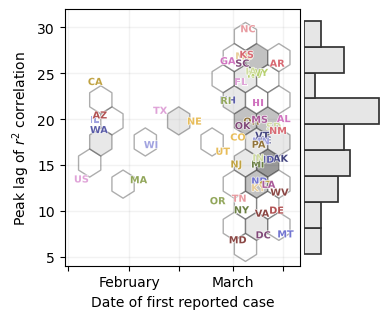

In [25]:
cols = plt.cm.tab20b(np.linspace(0,1,len(firstdays)))

x_data = firstdays
y_data = peakcorrs
st_abbrev_names = {j:i for i,j in all_state_names.items()}
st_abbrev_names['United States'] = 'us'

fig, ax = plt.subplots(1,2,figsize=(4.1,3.4),dpi=100,gridspec_kw={'width_ratios':[3,1]})
plt.subplots_adjust(wspace=0.025)
ax[0].scatter(firstdays, peakcorrs, c=cols, edgecolors='.2', s=40, alpha=0.0)
txt_height = 0.02*(ax[0].get_ylim()[1] - ax[0].get_ylim()[0])
txt_width = 0.02*(ax[0].get_xlim()[1] - ax[0].get_xlim()[0])
text_positions = get_text_positions(x_data, y_data, txt_width, txt_height)

fs = 7
i = 0
vaha = [('bottom','left'),('bottom','right'),('top','left'),('top','right')]
tlis = [(1,1), (-1,1), (1,-1), (-1,-1)]

for x, y, t in zip(x_data, y_data, text_positions):
    lab_i = st_abbrev_names[labs[i]].upper()
    va_i = vaha[i%4][0]
    ha_i = vaha[i%4][1]
    tp_x = tlis[i%4][0]*np.random.uniform(0,0.5)
    tp_y = tlis[i%4][1]*np.random.uniform(0,0.5)

    ax[0].text(x+tp_x, y+tp_y, '%s'%lab_i, rotation=0, color=cols[i], fontsize=fs,
               va=va_i, ha=ha_i, fontweight='bold', alpha=0.9,
               path_effects=[path_effects.Stroke(linewidth=0.9, foreground='w'),
                             path_effects.Normal()])

    i += 1

ax[0].set_ylim(4,32)
ax[0].set_xlim(date_dict['2020-01-21']-7)

ax[0].set_ylabel(r'Peak lag of $r^2$ correlation')
ax[0].set_xlabel('Date of first reported case')

xtx = ['2020-01-15','2020-02-01','2020-02-15','2020-03-01','2020-03-15']
xtxl = ['','February','','March','']
ax[0].set_xticks([date_dict[i] for i in xtx])
ax[0].set_xticklabels(xtxl)

ax[0].grid(linewidth=1,alpha=0.1,color='.5')
ax[0].hexbin(firstdays, peakcorrs, cmap='Greys', alpha=0.4, gridsize=9, mincnt=1, lw=1, edgecolors='.2')

ax[1].hist(peakcorrs,bins=9,ec='.2',fc='.9',orientation='horizontal',lw=1.25)
ax[1].set_yticklabels([])
ax[1].set_axis_off()

plt.savefig('../figs/pngs/peak_correlations_casedeath.png', dpi=300, bbox_inches='tight')
plt.show()

# Race

In [26]:
fn = '../data/census_tract_data.csv.gz'
df = pd.read_csv(fn, dtype={'census_tract':str,'geo_id':str,})
df['frac_pop'] = df.num_users / df.total_pop
vars_of_interest = ['census_tract','num_users','total_pop','frac_pop','male_pop','female_pop',
                    'median_age', 'black_pop', 'asian_pop', 'hispanic_pop', 'amerindian_pop','white_pop',
                    'other_race_pop', 'two_or_more_races_pop', 'hispanic_any_race', 'not_hispanic_pop',
                    'median_income', 'income_per_capita', 'gini_index', 'poverty', 'median_rent', 
                    'commute_less_10_mins', 'commute_10_14_mins', 'commute_15_19_mins',
                    'commute_20_24_mins', 'commute_25_29_mins', 'commute_30_34_mins', 'commute_35_44_mins',
                    'commute_60_more_mins', 'commute_45_59_mins', 'aggregate_travel_time_to_work',
                    'associates_degree', 'bachelors_degree', 'high_school_diploma', 'less_one_year_college',
                    'masters_degree', 'one_year_more_college', 'less_than_high_school_graduate',
                    'high_school_including_ged', 'bachelors_degree_2', 'bachelors_degree_or_higher_25_64',
                    'graduate_professional_degree', 'some_college_and_associates_degree']
df = df.loc[df.total_pop > 0]
df['state_fips'] = df['census_tract'].str[:2]

test_race = df.groupby('state_fips').agg({'black_pop':np.nansum, 'asian_pop':np.nansum,
            'hispanic_pop':np.nansum, 'amerindian_pop':np.nansum,'other_race_pop':np.nansum,
            'white_pop':np.nansum, 'two_or_more_races_pop':np.nansum,
            'hispanic_any_race':np.nansum,'num_users':np.nansum, 'total_pop':np.nansum}).reset_index()
test_race['state'] = [all_state_ids[i] for i in test_race['state_fips'].values]

test_race = test_race.rename(columns={'black_pop':'pop_black','hispanic_any_race':'pop_latinx',
                                      'asian_pop':'pop_asian','white_pop':'pop_white',
                                      'amerindian_pop':'pop_aian','two_or_more_races_pop':'pop_multiracial',
                                      'other_race_pop':'pop_other','total_pop':'pop_total'})
test_race.head()

state_fips  pop_black  pop_asian  hispanic_pop  pop_aian  pop_other  \
0         01    1285737      63936        203146     23243       7503   
1         02      22815      45560         51136    103282       1459   
2         04     286614     222477       2163312    271946       9177   
3         05     458536      43441        219052     17342       4641   
4         06    2162558    5525199      15217336    138225      97757   

   pop_white  pop_multiracial  pop_latinx  num_users  pop_total state  
0    3196730            82864      203146     324247    4864680    al  
1     450441            54544       51136      13584     737765    ak  
2    3825886           154750     2163312     219251    6946685    az  
3    2173849            65933      219052     165993    2990671    ar  
4   14692677          1165738    15217336    1010649   39138313    ca

In [27]:
race = pd.read_csv('https://docs.google.com/spreadsheets/d/e/'+\
                   '2PACX-1vS8SzaERcKJOD_EzrtCDK1dX1zkoMochlA9iHoHg_'+\
                   'RSw3V8bkpfk1mpw4pfL5RdtSOyx_oScsUtyXyk/pub?'+\
                   'gid=43720681&single=true&output=csv',dtype={'fips':str})
race = race.rename(columns={i:i.lower() for i in race.columns})
race['date'] = race.date.astype(str).str[:4] + '-' +\
               race.date.astype(str).str[4:6] + '-' + race.date.astype(str).str[-2:]
race['state'] = race.state.str.lower()
race = race.sort_values('date').reset_index().iloc[:,1:]

race['cases_aian'] = race[['cases_aian','cases_nhpi']].sum(axis=1)
race['hosp_aian'] = race[['hosp_aian','hosp_nhpi']].sum(axis=1)
race['deaths_aian'] = race[['deaths_aian','deaths_nhpi']].sum(axis=1)
race['cases_latinx'] = race['cases_ethnicity_hispanic']
race['hosp_latinx'] = race['hosp_ethnicity_hispanic']
race['deaths_latinx'] = race['deaths_ethnicity_hispanic']
race = race[['date', 'state', 'cases_total', 'cases_white', 'cases_black',
             'cases_latinx', 'cases_asian', 'cases_aian', #'cases_nhpi',
             'cases_multiracial', 'cases_other', 'cases_unknown',
             'hosp_total', 'hosp_white', 'hosp_black', 'hosp_latinx',
             'hosp_asian',  'hosp_aian', #'hosp_nhpi',
             'hosp_multiracial', 'hosp_other', 'hosp_unknown',
             'deaths_total', 'deaths_white',
             'deaths_black', 'deaths_latinx', 'deaths_asian', 'deaths_aian', #'deaths_nhpi',
             'deaths_multiracial', 'deaths_other', 'deaths_unknown']]
case_cols = ['cases_aian', 'cases_asian', 'cases_black', 'cases_latinx',
             'cases_multiracial', 'cases_other', 'cases_unknown', 'cases_white', 'cases_total']
death_cols = ['deaths_aian', 'deaths_asian', 'deaths_black', 'deaths_latinx',
              'deaths_multiracial', 'deaths_other', 'deaths_unknown', 'deaths_white', 'deaths_total']
hosp_cols = ['hosp_aian', 'hosp_asian', 'hosp_black', 'hosp_latinx',
             'hosp_multiracial', 'hosp_other', 'hosp_unknown', 'hosp_white', 'hosp_total']

race = race.replace(',','', regex=True)
race[case_cols] = race[case_cols].astype(float)
race[death_cols] = race[death_cols].astype(float)
race[hosp_cols] = race[hosp_cols].astype(float)
race_data_cols = case_cols + death_cols + hosp_cols

race = race.merge(DATE_DF,how='left',on='date')
race = race.merge(test_race,how='left',on='state')
race.head()

date state  cases_total  cases_white  cases_black  cases_latinx  \
0  2020-04-12    wy          NaN          NaN          NaN           NaN   
1  2020-04-12    mi      24635.0       6652.0       8130.0         492.0   
2  2020-04-12    me          NaN          NaN          NaN           NaN   
3  2020-04-12    md       8251.0       2300.0       3200.0           NaN   
4  2020-04-12    ma      25475.0       4271.0       1358.0        1885.0   

   cases_asian  cases_aian  cases_multiracial  cases_other  ...  pop_black  \
0          NaN         0.0                NaN          NaN  ...     5149.0   
1        246.0       246.0              985.0        739.0  ...  1357480.0   
2          NaN         0.0                NaN          NaN  ...    16990.0   
3        190.0         0.0                NaN        861.0  ...  1755504.0   
4        331.0         0.0                NaN        733.0  ...   463668.0   

   pop_asian  hispanic_pop  pop_aian  pop_other  pop_white  pop_multiracial  \
0     4660.0       56966.0   12717.0      227.0   489559.0          12124.0   
1   302036.0      497441.0   45718.0    14334.0  7487145.0         243984.0   
2    14814.0       21421.0    7722.0      843.0  1244525.0          26240.0   
3   371974.0      588620.0   10921.0    19368.0  3083168.0         165541.0   
4   440326.0      788955.0    8890.0    53268.0  4930100.0         142601.0   

   pop_latinx  num_users  pop_total  
0     56966.0    15150.0   581836.0  
1    497441.0   345868.0  9950602.0  
2     21421.0    29621.0  1332813.0  
3    588620.0   168098.0  5997361.0  
4    788955.0   151854.0  6829506.0  

[5 rows x 42 columns]

In [28]:
grace = race.groupby(['week','state']).agg({c:np.nansum for c in race_data_cols}).reset_index()
grace['day'] = 'Sunday'
grace = grace.merge(DATE_DF[['day','week','date']], how='left', on=['day','week'])
grace = grace.merge(test_race,how='left',on='state')

In [29]:
race_cols = ['aian', 'asian', 'black', 'latinx', 'multiracial', 'other', 'unknown', 'white', 'total']
state_df = []
for st in grace.state.unique():
    ll_st = grace.loc[grace['state']==st].copy()
    ll_st['new_deaths'] = list(np.nan_to_num(ll_st['deaths_total'].diff().tolist()).astype(int))
    ll_st['new_cases'] = list(np.nan_to_num(ll_st['cases_total'].diff().tolist()).astype(int))
    ll_st['new_hosp'] = list(np.nan_to_num(ll_st['hosp_total'].diff().tolist()).astype(int))
    ll_st.loc[ll_st['new_cases']<0,'new_cases'] = 0
    ll_st.loc[ll_st['new_deaths']<0,'new_deaths'] = 0
    ll_st.loc[ll_st['new_hosp']<0,'new_hosp'] = 0
    
    for c in race_cols:
        cases_col_c = 'cases_'+c
        deaths_col_c = 'deaths_'+c
        hosp_col_c = 'hosp_'+c
        ll_st['new_cases_'+c] = list(np.nan_to_num(ll_st[cases_col_c].diff().tolist()).astype(int))
        ll_st.loc[ll_st['new_cases_'+c]<0,'new_cases_'+c] = 0
        ll_st['new_deaths_'+c] = list(np.nan_to_num(ll_st[deaths_col_c].diff().tolist()).astype(int))
        ll_st.loc[ll_st['new_deaths_'+c]<0,'new_deaths_'+c] = 0
        ll_st['new_hosp_'+c] = list(np.nan_to_num(ll_st[hosp_col_c].diff().tolist()).astype(int))
        ll_st.loc[ll_st['new_hosp_'+c]<0,'new_hosp_'+c] = 0
        
    state_df.append(ll_st)

grace = pd.concat(state_df).sort_values(['date','state']).reset_index().iloc[:,1:]

In [30]:
race_cols = ['aian', 'asian', 'black', 'latinx', 'multiracial', 'other', 'unknown', 'white', 'total']
state_df = []
for st in race.state.unique():
    ll_st = race.loc[race['state']==st].copy()
    ll_st['new_deaths'] = list(np.nan_to_num(ll_st['deaths_total'].diff().tolist()).astype(int))
    ll_st['new_cases'] = list(np.nan_to_num(ll_st['cases_total'].diff().tolist()).astype(int))
    ll_st['new_hosp'] = list(np.nan_to_num(ll_st['hosp_total'].diff().tolist()).astype(int))
    ll_st.loc[ll_st['new_cases']<0,'new_cases'] = 0
    ll_st.loc[ll_st['new_deaths']<0,'new_deaths'] = 0
    ll_st.loc[ll_st['new_hosp']<0,'new_hosp'] = 0
    
    for c in race_cols:
        cases_col_c = 'cases_'+c
        deaths_col_c = 'deaths_'+c
        hosp_col_c = 'hosp_'+c
        ll_st['new_cases_'+c] = list(np.nan_to_num(ll_st[cases_col_c].diff().tolist()).astype(int))
        ll_st.loc[ll_st['new_cases_'+c]<0,'new_cases_'+c] = 0
        ll_st['new_deaths_'+c] = list(np.nan_to_num(ll_st[deaths_col_c].diff().tolist()).astype(int))
        ll_st.loc[ll_st['new_deaths_'+c]<0,'new_deaths_'+c] = 0
        ll_st['new_hosp_'+c] = list(np.nan_to_num(ll_st[hosp_col_c].diff().tolist()).astype(int))
        ll_st.loc[ll_st['new_hosp_'+c]<0,'new_hosp_'+c] = 0
        
    state_df.append(ll_st)

race = pd.concat(state_df).sort_values(['date','state']).reset_index().iloc[:,1:]

In [31]:
grace.loc[grace['date'].isna(),'date'] = '2021-01-27'

In [32]:
xtx = ['2020-02-01','2020-03-01','2020-04-01','2020-05-01','2020-06-01','2020-07-01','2020-08-01',
       '2020-09-01','2020-10-01','2020-11-01','2020-12-01','2021-01-01','2021-02-01']
xtxl = ['','Mar.','','May','','Jul.','','Sep.','','Nov.','','Jan.','']

prace_cols = ['black','latinx','white','asian','aian','multiracial','other','unknown']
ccc = ["#7b55ad","#c07a33","#90cde3","#a45b4a","#578360","#aa517b","#6b85a0","#759743"]
rcos = dict(zip(prace_cols,ccc))
rcos['unknown'] = '.85'

st = 'mi'
measures = ['cases','hosp','deaths']
lims = {'deaths':4,'cases':20,'hosp':10}
wid = 4
for st in list(all_state_ids.values()):
    rac_i = grace.loc[grace['state']==st].copy()
#     rac_i = race.loc[race['state']==st].copy()
    
    if st not in race['state'].unique() or rac_i['cases_total'].values[-1] < 5000:
        continue

    w = 5.2; h = 2.3
    ncols = 2; nrows = 3
    tups = list(it.product(range(nrows), range(ncols)))
    fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100, sharex=True)
    plt.subplots_adjust(wspace=0.25,hspace=0.15)


    labs0 = ['New cases\nper 1,000','New hospitalizations\nper 10,000','New deaths\nper 1,000']
    labs1 = ['New cases\n(relative to white pop.)',
            'New hospitalizations\n(relative to white pop.)',
            'New deaths\n(relative to white pop.)']
    for i,m in enumerate(measures):
        ts = 0
        for ci,c in enumerate(prace_cols):
            col_c_i = 'new_%s_%s'%(m,c)
            col_c_iw = 'new_%s_%s'%(m,'white')
            tot_c_i = '%s_%s'%(m,c)
            pop_c_i = 'pop_%s'%c
            pop_c_iw = 'pop_white'
            if c not in ['unknown','other']:#,'multiracial']:
                xvals_c_i = [date_dict[i] for i in rac_i['date']]
                yvals_tot_c_i = rac_i[tot_c_i].values[-1]
                if yvals_tot_c_i > lims[m]:
                    yvals_c_ir = rac_i[col_c_i].rolling(window=wid).mean().values /\
                                 rac_i[pop_c_i].values[0] * 1000
                    yvals_w_ir = rac_i[col_c_iw].rolling(window=wid).mean().values /\
                                 rac_i[pop_c_iw].values[0] * 1000
                    ax[(i,0)].plot(xvals_c_i, yvals_c_ir, color=rcos[c], lw=2.5, alpha=0.8)
                    ax[(i,1)].plot(xvals_c_i, yvals_c_ir/yvals_w_ir, color=rcos[c], lw=2.5, alpha=0.8)
                    ts += np.nansum(yvals_c_ir)

        ax[(i,0)].set_ylabel(labs0[i],color='.3')
        ax[(i,1)].set_ylabel(labs1[i],color='.3')
        if ts == 0:
            ax[(i,1)].set_yticks([0,1,2])
            ax[(i,1)].set_yticklabels(['','',''])
            ax[(i,0)].set_yticks([0,1,2])
            ax[(i,0)].set_yticklabels(['','',''])

        ax[(i,1)].hlines(1,-20,500,lw=1.5,color='.2',alpha=0.7,linestyle='--')

    rvs = np.linspace(0.1,1,len(prace_cols))
    full = len(''.join(str(c) for c in prace_cols)) * 2
    rvs = len(prace_cols[0]) / full
    rvs = 0
    for ri,r in enumerate(prace_cols):
        ax[tups[-2]].scatter(xvals_c_i, yvals_c_ir,marker='',label=r)

    l = ax[tups[-2]].legend(ncol=len(prace_cols),columnspacing=0, handletextpad=-0.3,
                      bbox_to_anchor=[-0.08,-0.18],loc=2, framealpha=0, fontsize=14)
    for text in l.get_texts():
        text.set_color(rcos[text.get_text()])
        text.set_path_effects([path_effects.Stroke(linewidth=1, foreground='.6'),
                           path_effects.Normal()])

    ax[(0,0)].set_title(all_state_names[st]+", per capita", x=1.0, ha='right', color='.5', fontsize='large')
    ax[(0,1)].set_title(all_state_names[st]+", relative differences by race",
                        x=1.0, ha='right', color='.5', fontsize='large')

    for ai,a in enumerate(fig.axes):
        if tups[ai][0] == nrows-1:
            a.set_xticks([date_dict[i] for i in xtx])
            a.set_xticklabels(xtxl)

        a.grid(linewidth=1.5, color='.75', alpha=0.25)
        a.tick_params(axis='both',labelcolor='.4')
        a.set_xlim(date_dict[rac_i['date'].values[0]]+wid*2.6, date_dict[rac_i['date'].values[-1]]+1)

    plt.savefig('../figs/pngs/state_race/%s_race_per.png'%"".join(all_state_names[st]),
                dpi=425,bbox_inches='tight')
    plt.close()

/Users/brennan/anaconda3/envs/covid/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide
/Users/brennan/anaconda3/envs/covid/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide
/Users/brennan/anaconda3/envs/covid/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide
/Users/brennan/anaconda3/envs/covid/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide
/Users/brennan/anaconda3/envs/covid/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide
/Users/brennan/anaconda3/envs/covid/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide
/Users/brennan/anaconda3/envs/covid/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid valu

/Users/brennan/anaconda3/envs/covid/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide
/Users/brennan/anaconda3/envs/covid/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide
/Users/brennan/anaconda3/envs/covid/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide
/Users/brennan/anaconda3/envs/covid/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide
/Users/brennan/anaconda3/envs/covid/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide
/Users/brennan/anaconda3/envs/covid/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide
/Users/brennan/anaconda3/envs/covid/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid valu

/Users/brennan/anaconda3/envs/covid/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide
/Users/brennan/anaconda3/envs/covid/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide
/Users/brennan/anaconda3/envs/covid/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide
/Users/brennan/anaconda3/envs/covid/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide
/Users/brennan/anaconda3/envs/covid/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide
/Users/brennan/anaconda3/envs/covid/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide
/Users/brennan/anaconda3/envs/covid/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid valu

/Users/brennan/anaconda3/envs/covid/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide
/Users/brennan/anaconda3/envs/covid/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide
/Users/brennan/anaconda3/envs/covid/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide
/Users/brennan/anaconda3/envs/covid/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide
/Users/brennan/anaconda3/envs/covid/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide
/Users/brennan/anaconda3/envs/covid/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide
/Users/brennan/anaconda3/envs/covid/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid valu

# Cumulative state by state racial breakdowns

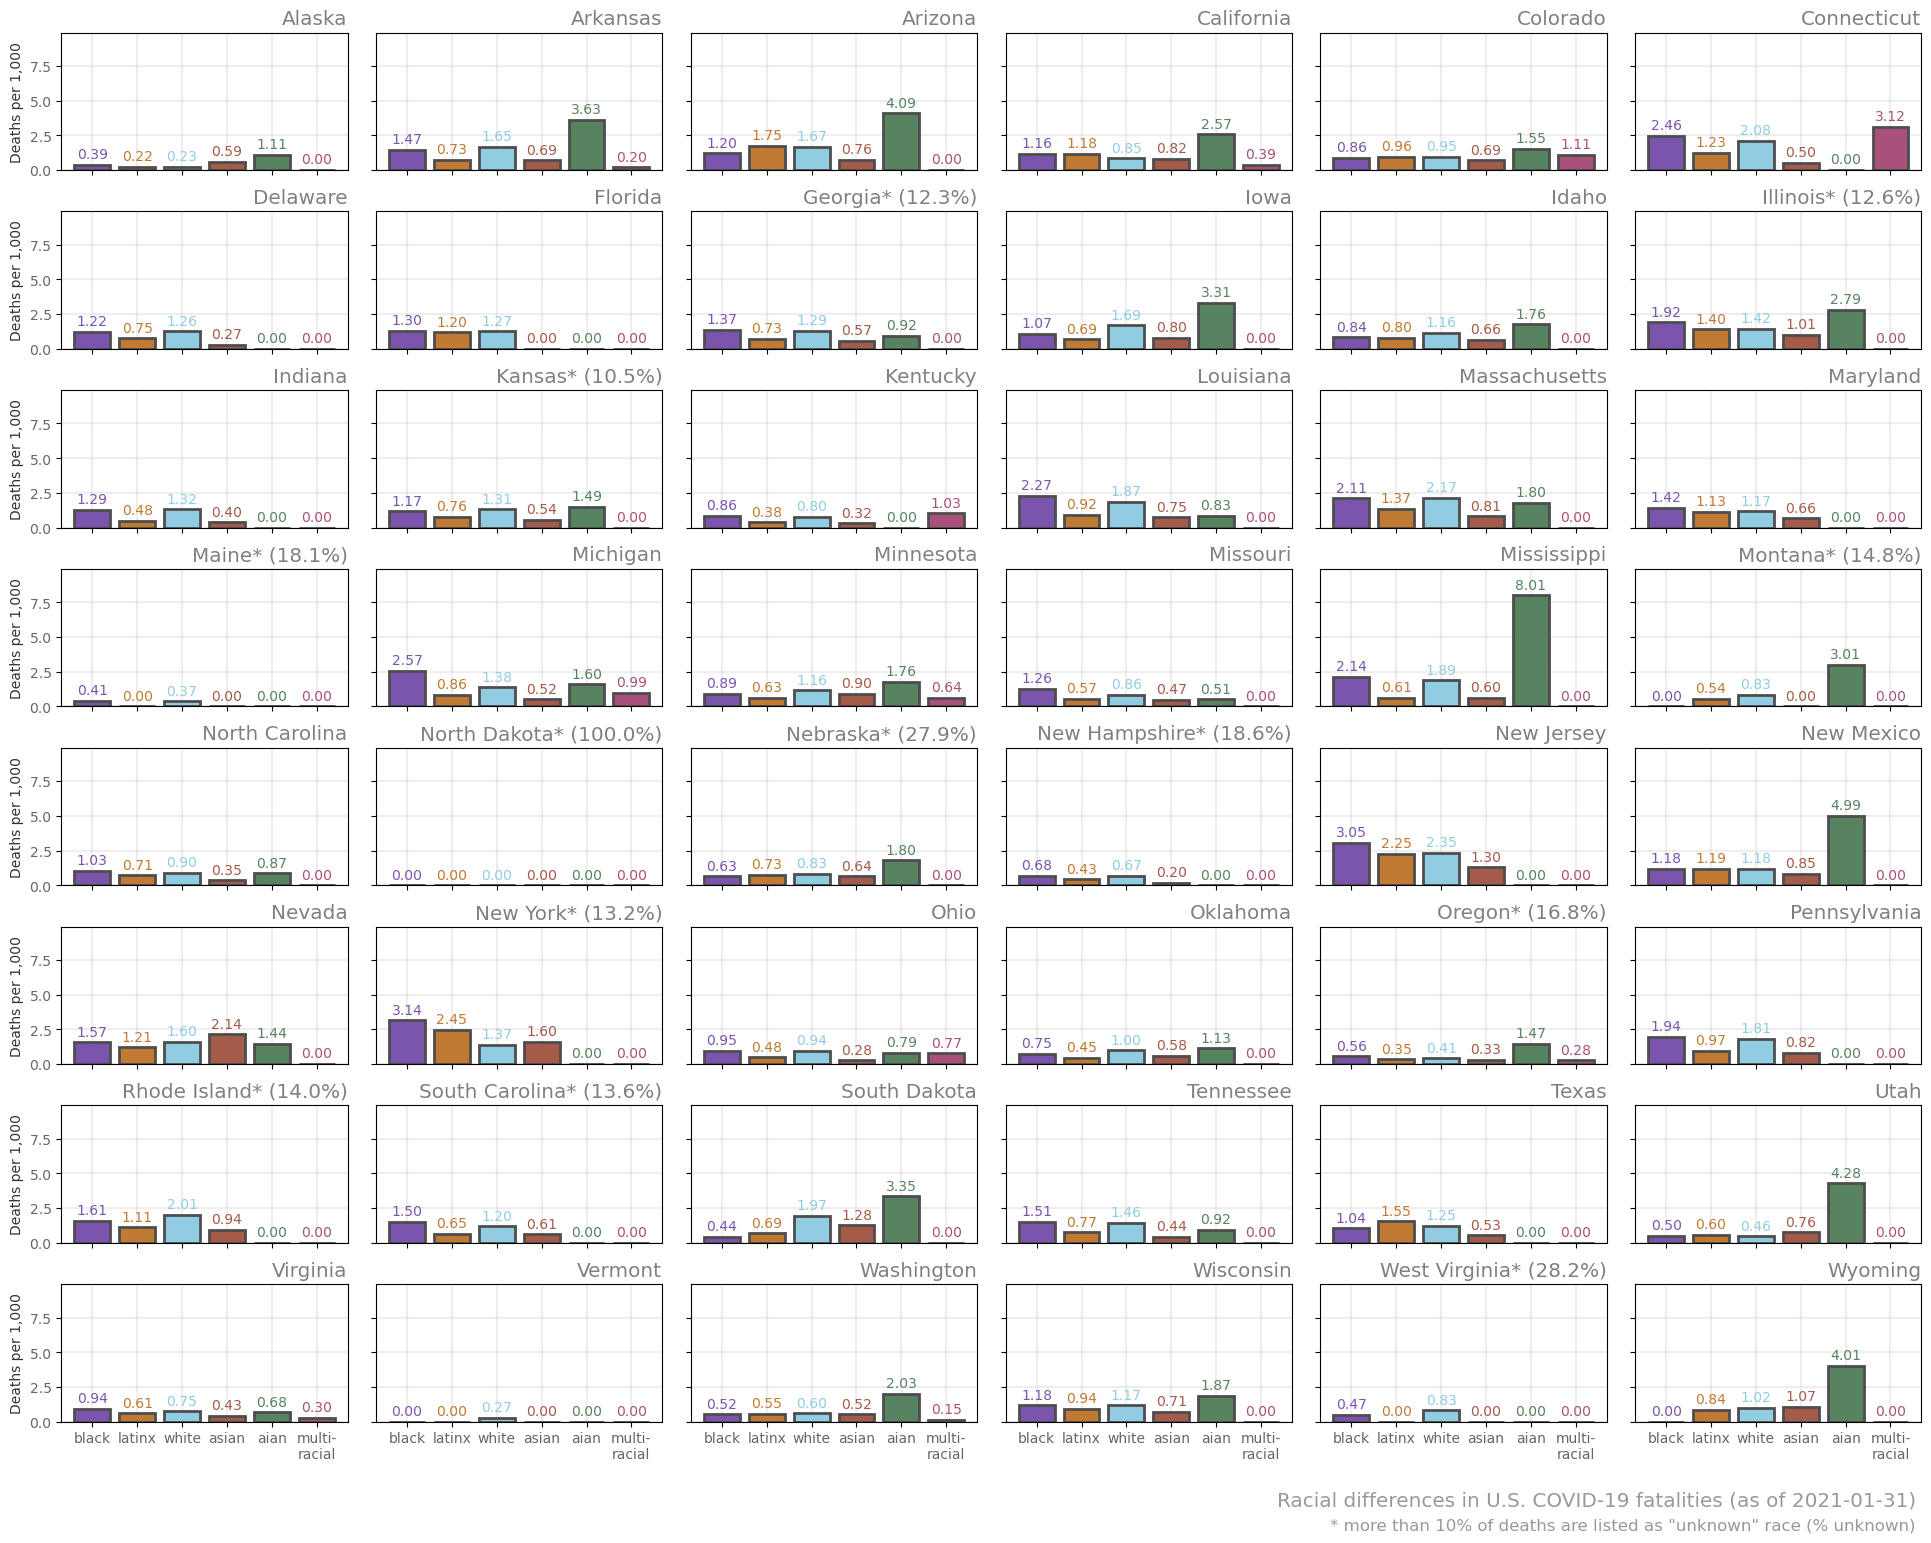

In [33]:
w = 4.0; h = 2.3
ncols = 6; nrows = 8
tups = list(it.product(range(nrows), range(ncols)))
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100, sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.1,hspace=0.3)

thresh = 0.1
rdf = race.loc[(race['date']==race['date'].max())&\
               (~race['state'].isin(['as','mp','vi','hi','dc','al','pr','gu']))].copy()

for ix,st in enumerate(sorted(rdf['state'].unique())):
    rac_i = rdf.loc[race['state']==st].copy()
    rc = []
    colr = []
    tit_st = all_state_names[st]
    if (rac_i['deaths_unknown']/rac_i['deaths_total']).values[0] > thresh:
        tit_st = tit_st + '* (%.1f%%)'%np.round((rac_i['deaths_unknown']/rac_i['deaths_total']).values[0]*100,1)
    for ci,c in enumerate([i for i in prace_cols if i not in ['unknown','other']]):
        tot_c_i = '%s_%s'%(m,c)
        pop_c_i = 'pop_%s'%c
        yvals_tot_c_i = np.nan_to_num(rac_i[tot_c_i].values[-1])
        yv = 0
        if yvals_tot_c_i > lims[m]:
            yv = yvals_tot_c_i/rac_i[pop_c_i].values[0]*1000
        rc.append(yv)
        colr.append(rcos[c])

    ax[tups[ix]].bar(list(range(len(rc))),rc,color=colr, ec='.3', lw=2)
    for r in range(len(rc)):
        ax[tups[ix]].text(r, rc[r]+0.25, "%.2f"%(rc[r]),
                          fontsize='medium', color=colr[r], ha='center', va='bottom')
    
    ax[tups[ix]].grid(linewidth=1.5, color='.75', alpha=0.25)
    ax[tups[ix]].tick_params(axis='both',labelcolor='.4')
    ax[tups[ix]].set_title(tit_st, x=1.0, ha='right', color='.5', fontsize='x-large')
    if tups[ix][0]==nrows-1:
        ax[tups[ix]].set_xticks(list(range(len(rc))))
        ax[tups[ix]].set_xticklabels(['black', 'latinx', 'white', 'asian', 'aian', 'multi-\nracial'])
    if tups[ix][1]==0:
        ax[tups[ix]].set_ylabel('Deaths per 1,000',color='.2')

    ax[tups[ix]].set_ylim(0,9.9)

ax[tups[-1]].text(0.98,-0.5,'Racial differences in U.S. COVID-19 fatalities (as of %s)'%rdf['date'].values[0],
                  ha='right',va='top',transform=ax[tups[-1]].transAxes, color='.6',fontsize='x-large')

ax[tups[-1]].text(0.98,-0.7,'* more than %i%% of deaths are listed as "unknown" race (%% unknown)'%(
                                                                        int(thresh*100)),
                  ha='right',va='top',transform=ax[tups[-1]].transAxes, color='.6',fontsize='large')

plt.savefig('../figs/pngs/race_deaths_total_states.png',dpi=425,bbox_inches='tight')
plt.show()

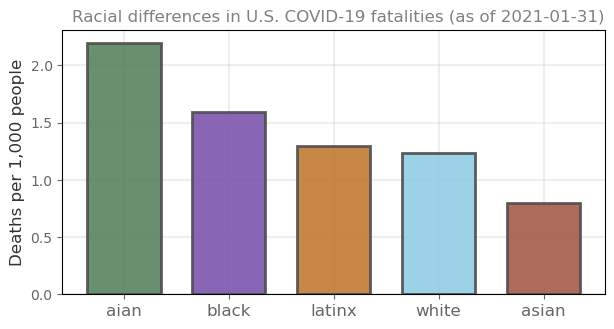

In [34]:
rdf = race.loc[(race['date']==race['date'].max())].copy()

death_cols_i = [i for i in death_cols if i not in ['deaths_unknown']]
sums = rdf[death_cols_i + [i.replace('deaths_','pop_') for i in death_cols_i]].sum(axis=0)
sum_dict = dict(zip(list(sums.index),sums.values))

out = {}
mm = 'deaths_'
pm = 'pop_'
for c in ['aian', 'black', 'latinx', 'white', 'asian']:
    out[c] = sum_dict[mm+c] / sum_dict[pm+c] * 1000


fig, ax = plt.subplots(1,1,figsize=(7,3.5),dpi=100)
ax.bar(list(range(len(out))), list(out.values()), color=[rcos[x] for x in out.keys()],
       width=0.7, alpha=0.9, ec='.3', lw=2)
ax.grid(linewidth=1.5, color='.75', alpha=0.25)
ax.tick_params(axis='both',labelcolor='.4',color='.4')
ax.set_title('Racial differences in U.S. COVID-19 fatalities (as of %s)'%rdf['date'].values[0],
             x=1.0, ha='right', color='.5', fontsize='large')

ax.set_ylabel('Deaths per 1,000 people',color='.2',fontsize='large')
ax.set_xticks(list(range(len(out))))
ax.set_xticklabels(list(out.keys()),fontsize='large')

plt.savefig('../figs/pngs/race_deaths_total.png',dpi=425,bbox_inches='tight')
plt.show()

/Users/brennan/anaconda3/envs/covid/lib/python3.7/site-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in true_divide


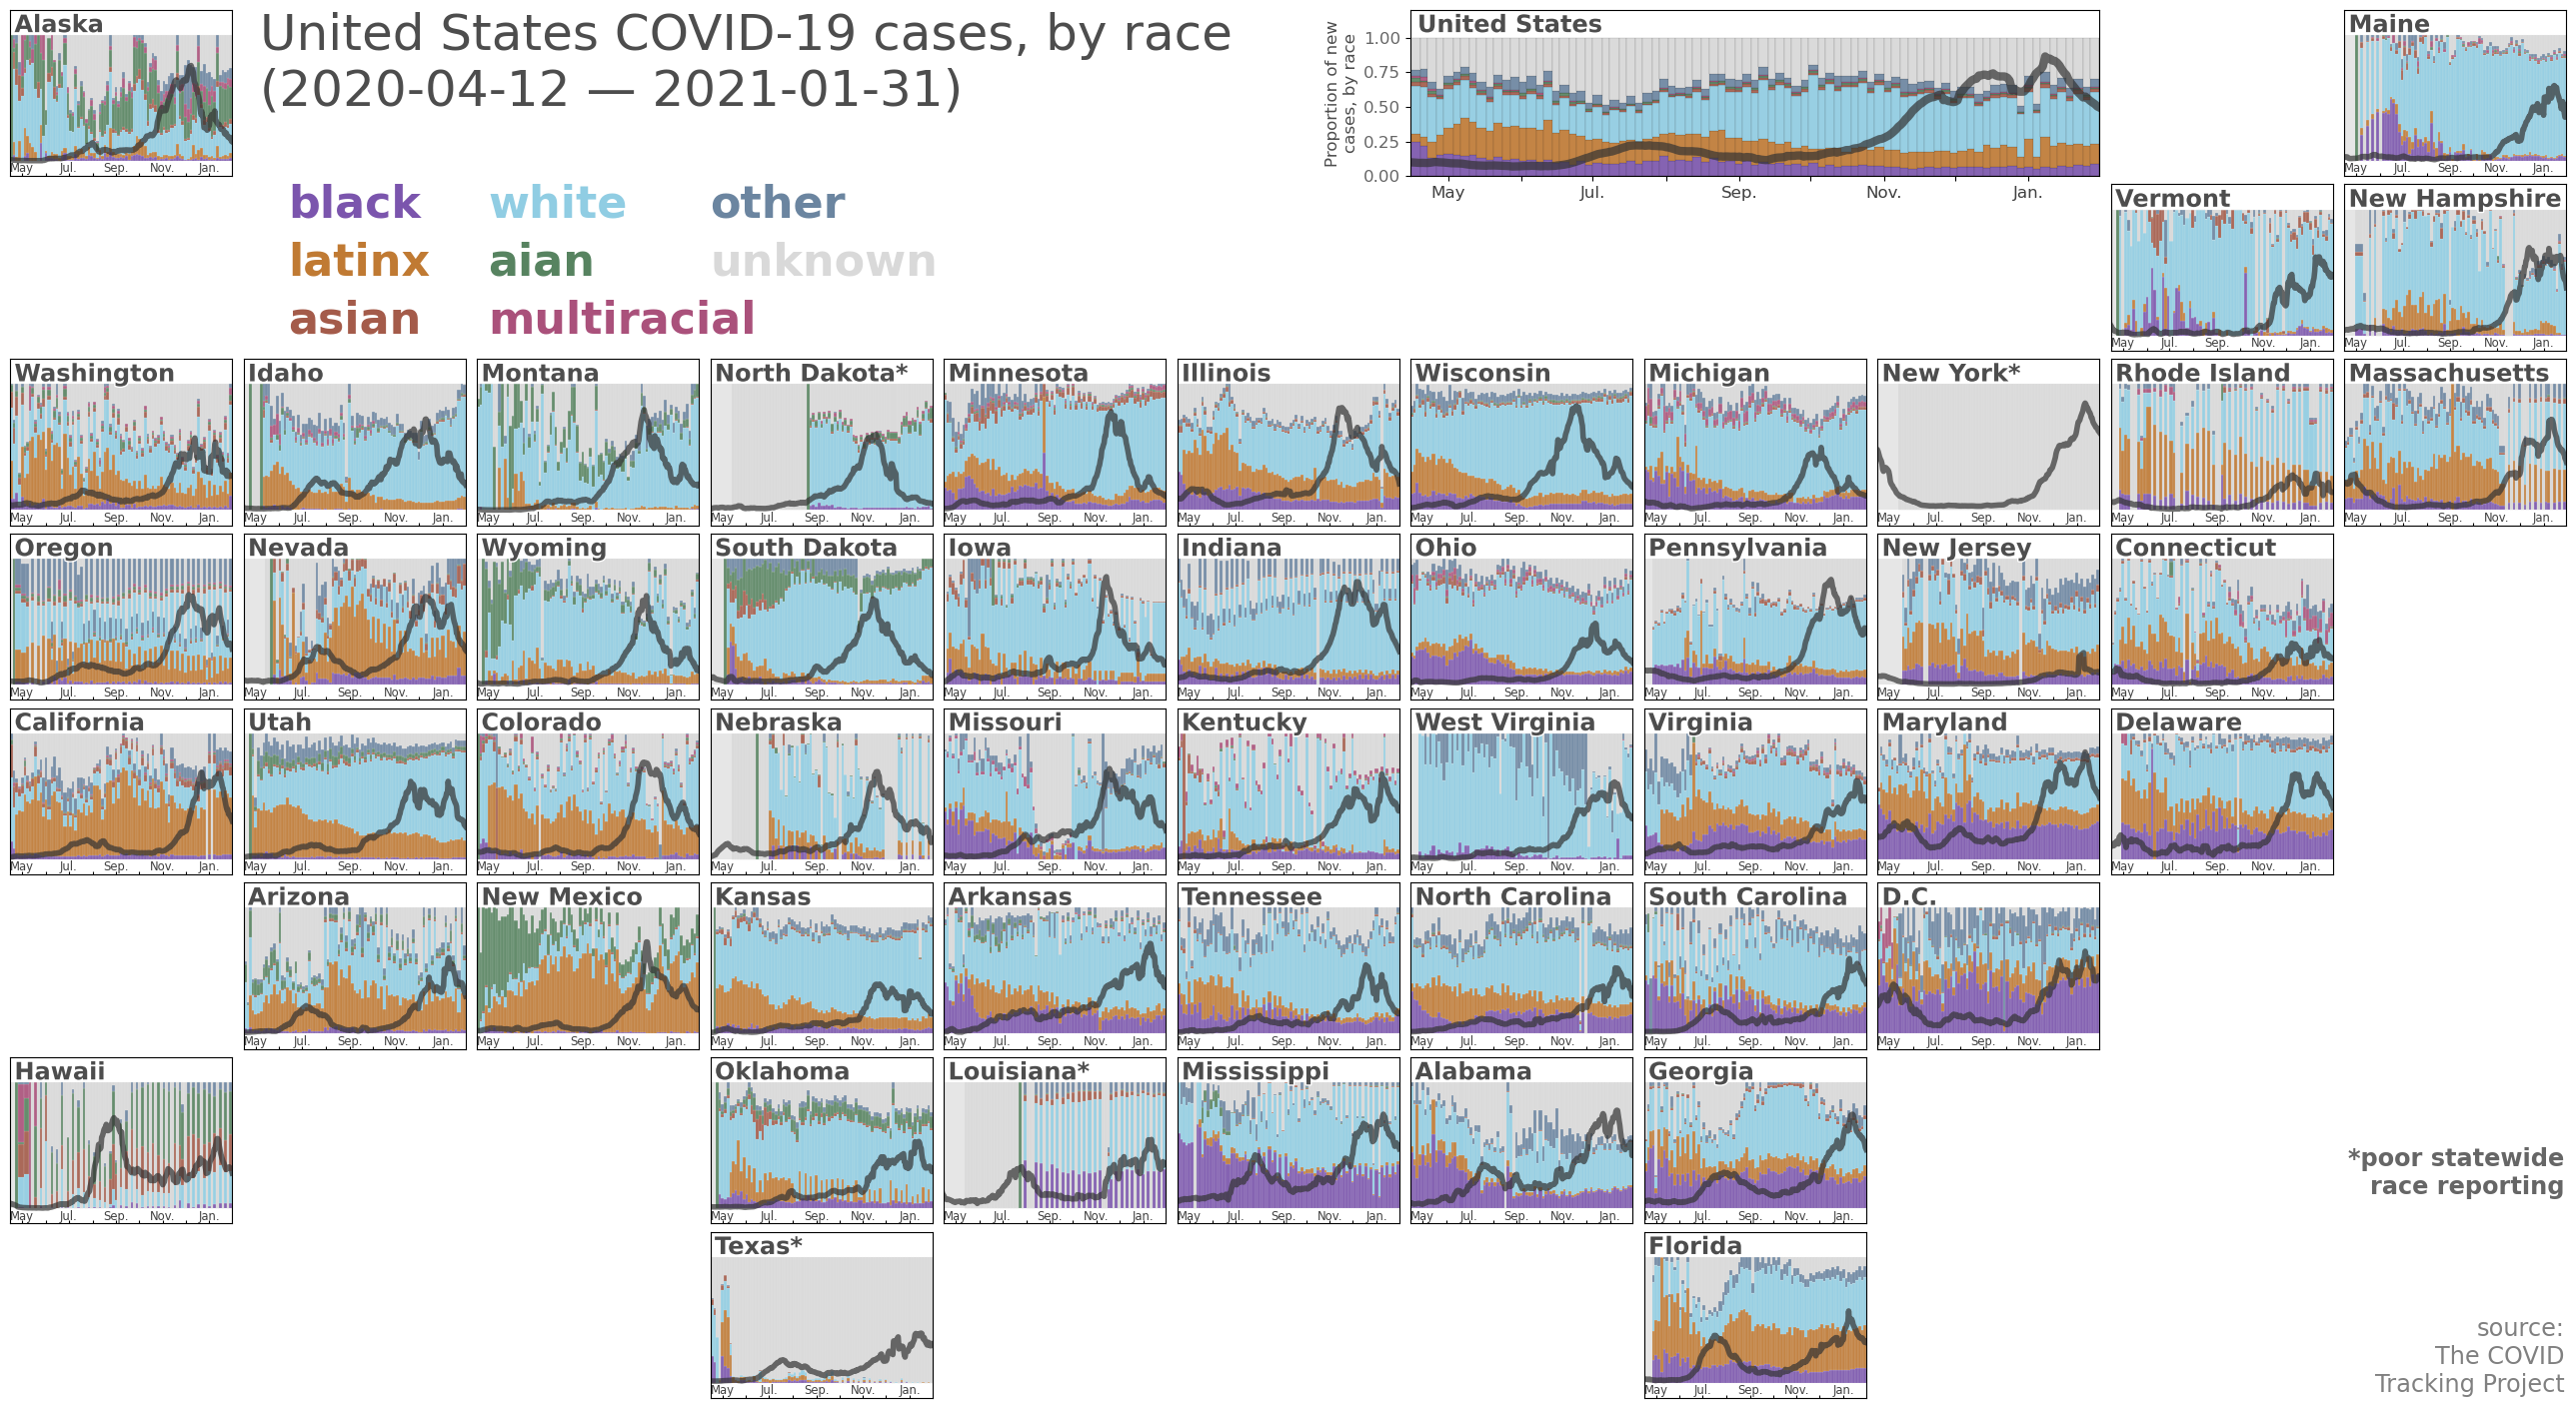

In [35]:
fdate = '2020-03-05'
days_since = 7
min_c = 10


xtx = ['2020-02-01','2020-03-01','2020-04-01','2020-05-01','2020-06-01','2020-07-01','2020-08-01',
       '2020-09-01','2020-10-01','2020-11-01','2020-12-01','2021-01-01','2021-02-01']
xtxl = ['','Mar.','','May','','Jul.','','Sep.','','Nov.','','Jan.','']


col_co = '.2'

rcos = dict(zip(['black','latinx','asian','white'],['rebeccapurple','mediumseagreen','steelblue','orange']))

w = 3.0; h = 2.3
ncols = 11; nrows = 8
tups = list(it.product(range(nrows), range(ncols)))
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100)#, sharex=True)
plt.subplots_adjust(wspace=0.05,hspace=0.05)

lw_i = 0.1
ec_i = '.1'
for st, po in state_posx.items():
    stlab = all_state_names[st]
    if st not in race['state'].unique().tolist() or st in ['gu','vi','mp','pr']:
        ax[po].set_axis_off()
        continue
    rr_df = race.loc[race['state']==st].copy()
    rr_df = rr_df.sort_values('date')
    rr_df['denom'] = rr_df[[i for i in rr_df.columns if 'new_cases_' in i
                            and 'new_cases_total' not in i]].sum(axis=1)
    rr_df = rr_df[[i for i in rr_df.columns if 'new_cases_' in i or 'denom' in i or 'date' in i]]
    rr_df = rr_df.loc[rr_df['denom']>0].copy()

#     prace_cols = ['unknown','black','latinx','white','asian','aian','multiracial','other']
#     ccc = ["#759743","#7b55ad","#c07a33","#90cde3","#a45b4a","#578360","#aa517b","#6b85a0"]
#     rcos = dict(zip(prace_cols,ccc))
#     rcos['unknown'] = '.7'
    prace_cols = ['black','latinx','white','asian','aian','multiracial','other','unknown']
    ccc = ["#7b55ad","#c07a33","#90cde3","#a45b4a","#578360","#aa517b","#6b85a0","#759743"]
    rcos = dict(zip(prace_cols,ccc))
    rcos['unknown'] = '.85'

    hei=0
    for ci,c in enumerate(prace_cols):
        cases_col_c = 'new_cases_'+c
        xvals = [date_dict[i] for i in rr_df['date'].values]
        yvals = rr_df[cases_col_c].values
        yvals = yvals / rr_df['denom'].values
        widts = list(np.diff(xvals))
        if widts[0]==3:
            widts = widts+[4]
        else:
            widts = widts+[3]
        
        ax[po].bar(xvals,yvals,bottom=hei,width=widts,
                ec='.95',lw=lw_i,fc=rcos[c],alpha=0.9,align='edge')
        hei = np.nan_to_num(yvals)+hei

    ll_st = ll.loc[(ll['fips']==all_ids_state[st])&(ll['date']>'2020-04-05')]
    xvals = np.array([date_dict[i] for i in ll_st['date'].values])
    yvals = ll_st['new_cases'].rolling(window=7).mean()/np.nanmax(ll_st['new_cases'])
    widts = list(np.diff(xvals))
    widts = widts+[3] if widts[0]==3 else widts+[4]

    ax[po].bar(xvals,[1]*len(xvals),bottom=0,width=widts,ec=ec_i,lw=0,
               fc='.9',alpha=1,align='edge',zorder=0)
    ax[po].plot(xvals, yvals, alpha=0.7,color='.2',linewidth=4)

    if stlab == 'District of Columbia':
        stlab = 'D.C.'
    
    if stlab in ['New York','Louisiana','North Dakota','Texas']:
        stlab = stlab + '*'
    ax[po].text(0.02,0.98,stlab,fontsize='xx-large',va='top',ha='left',
                color='.3',fontweight='bold',transform=ax[po].transAxes, zorder=6,
                path_effects=[path_effects.Stroke(linewidth=2, foreground='w'),
                              path_effects.Normal()])
    
    ax[po].set_xticks([date_dict[i] for i in xtx])
    ax[po].set_xticklabels(xtxl,fontsize='small',color='.25')
    ax[po].set_yticks([])
    ax[po].set_yticklabels(['']*len(ytx))
    ax[po].tick_params(axis="x",direction="in", pad=-10, length=2)
    ax[po].tick_params(axis="y",direction="in", pad=-5, length=0)

    ylim_st = ax[po].get_ylim()
    xlim_st = ax[po].get_xlim()
    ydiff = ylim_st[1]-ylim_st[0]
    
    ax[po].set_ylim(-0.12,1.2)
    ax[po].set_xlim(date_dict['2020-04-15'],xvals[-1])

for tup in tups:
    if tup not in state_posx.values():
        ax[tup].set_axis_off()


col_co = '.1'
stlab = 'United States'
columns_usa = [i for i in race.columns if 'new_cases_' in i and 'new_cases_total' not in i]
race_usa = race.groupby('date').agg({s:np.nansum for s in columns_usa}).reset_index()
race_usa['denom'] = race_usa[[i for i in race_usa.columns if 'new_cases_' in i
                              and 'new_cases_total' not in i]].sum(axis=1)

gs = ax[1, 8].get_gridspec()
for a in ax[0:1, 6:9].flatten():
    a.remove()
axbig = fig.add_subplot(gs[0:1, 6:9])

hei=0
for ci,c in enumerate(prace_cols):
    cases_col_c = 'new_cases_'+c
    xvals = [date_dict[i] for i in race_usa['date'].values]
    yvals = race_usa[cases_col_c].values
    yvals = yvals / race_usa['denom'].values
    widts = list(np.diff(xvals))
    if widts[0]==3:
        widts = widts+[4]
    else:
        widts = widts+[3]

    axbig.bar(xvals,yvals,bottom=hei,width=widts,
            ec=ec_i,lw=lw_i,fc=rcos[c],alpha=0.9,align='edge')
    hei = np.nan_to_num(yvals)+hei

race_usa = ll.loc[(ll['state']==stlab)&(ll['date']>'2020-04-05')].copy()

xvals = np.array([date_dict[i] for i in race_usa['date'].values])
yvals = race_usa['new_cases'].rolling(window=7).mean()/np.nanmax(race_usa['new_cases'])
widts = list(np.diff(xvals))
widts = widts+[3] if widts[0]==3 else widts+[4]

axbig.bar(xvals,[1]*len(xvals),bottom=0,width=widts,ec='.95',lw=0,
           fc='.9',align='edge',zorder=0)
axbig.plot(xvals, yvals, alpha=0.7,color='.2',linewidth=6)

axbig.text(0.01,0.98,stlab,fontsize='xx-large',va='top',ha='left',
           color='.3',fontweight='bold',transform=axbig.transAxes, zorder=6,
           path_effects=[path_effects.Stroke(linewidth=2, foreground='w'),
                         path_effects.Normal()])

axbig.set_xticks([date_dict[i] for i in xtx])
axbig.set_xticklabels(xtxl,fontsize='large',color='.25')
axbig.set_yticks([0,0.25,0.5,0.75,1.0])
axbig.set_yticklabels(['0.00','0.25','0.50','0.75','1.00'],fontsize='large',color='.4')

ylim_st = axbig.get_ylim()
xlim_st = axbig.get_xlim()
ydiff = ylim_st[1]-ylim_st[0]

axbig.set_ylim(0.0,1.2)
axbig.set_xlim(date_dict['2020-04-15'],xvals[-1])
axbig.set_ylabel('Proportion of new\ncases, by race',fontsize='large',color='.3')

ax[tups[-1]].text(0.99,0.01,'source:\nThe COVID\nTracking Project',color='.5',fontsize='xx-large',
                va='bottom', ha='right', transform=ax[tups[-1]].transAxes)
ax[tups[-1]].text(0.99,1.2,'*poor statewide\nrace reporting',fontweight='bold',
                  color='.4',fontsize='xx-large', va='bottom', ha='right', transform=ax[tups[-1]].transAxes)
ax[(0,1)].text(0.075,0.99,'United States COVID-19 cases, by race\n(%s — %s)'%(race['date'].min(),
                                                                             race['date'].max()),
               color='.3', fontsize=36, va='top', ha='left', transform=ax[(0,1)].transAxes)


fs = 32
ax[(1,1)].text(0.2,0.75,'black',color=rcos['black'],fontsize=fs,
               va='bottom', ha='left', transform=ax[(1,1)].transAxes, fontweight='bold')
ax[(1,1)].text(0.2,0.40,'latinx',color=rcos['latinx'],fontsize=fs,
               va='bottom', ha='left', transform=ax[(1,1)].transAxes, fontweight='bold')
ax[(1,1)].text(0.2,0.05,'asian',color=rcos['asian'],fontsize=fs,
               va='bottom', ha='left', transform=ax[(1,1)].transAxes, fontweight='bold')
ax[(1,2)].text(0.05,0.75,'white',color=rcos['white'],fontsize=fs,
               va='bottom', ha='left', transform=ax[(1,2)].transAxes, fontweight='bold')
ax[(1,2)].text(0.05,0.40,'aian',color=rcos['aian'],fontsize=fs,
               va='bottom', ha='left', transform=ax[(1,2)].transAxes, fontweight='bold')
ax[(1,2)].text(0.05,0.05,'multiracial',color=rcos['multiracial'],fontsize=fs,
               va='bottom', ha='left', transform=ax[(1,2)].transAxes, fontweight='bold')
ax[(1,3)].text(0.0,0.75,'other',color=rcos['other'],fontsize=fs,
               va='bottom', ha='left', transform=ax[(1,3)].transAxes, fontweight='bold')
ax[(1,3)].text(0.0,0.40,'unknown',color=rcos['unknown'],fontsize=fs,
               va='bottom', ha='left', transform=ax[(1,3)].transAxes, fontweight='bold')

plt.savefig('../figs/pngs/state_subplot_race_case_percapita.png', dpi=425, bbox_inches='tight')
plt.show()

/Users/brennan/anaconda3/envs/covid/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide
/Users/brennan/anaconda3/envs/covid/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide
/Users/brennan/anaconda3/envs/covid/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide
/Users/brennan/anaconda3/envs/covid/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide
/Users/brennan/anaconda3/envs/covid/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide
/Users/brennan/anaconda3/envs/covid/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide
/Users/brennan/anaconda3/envs/covid/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid valu

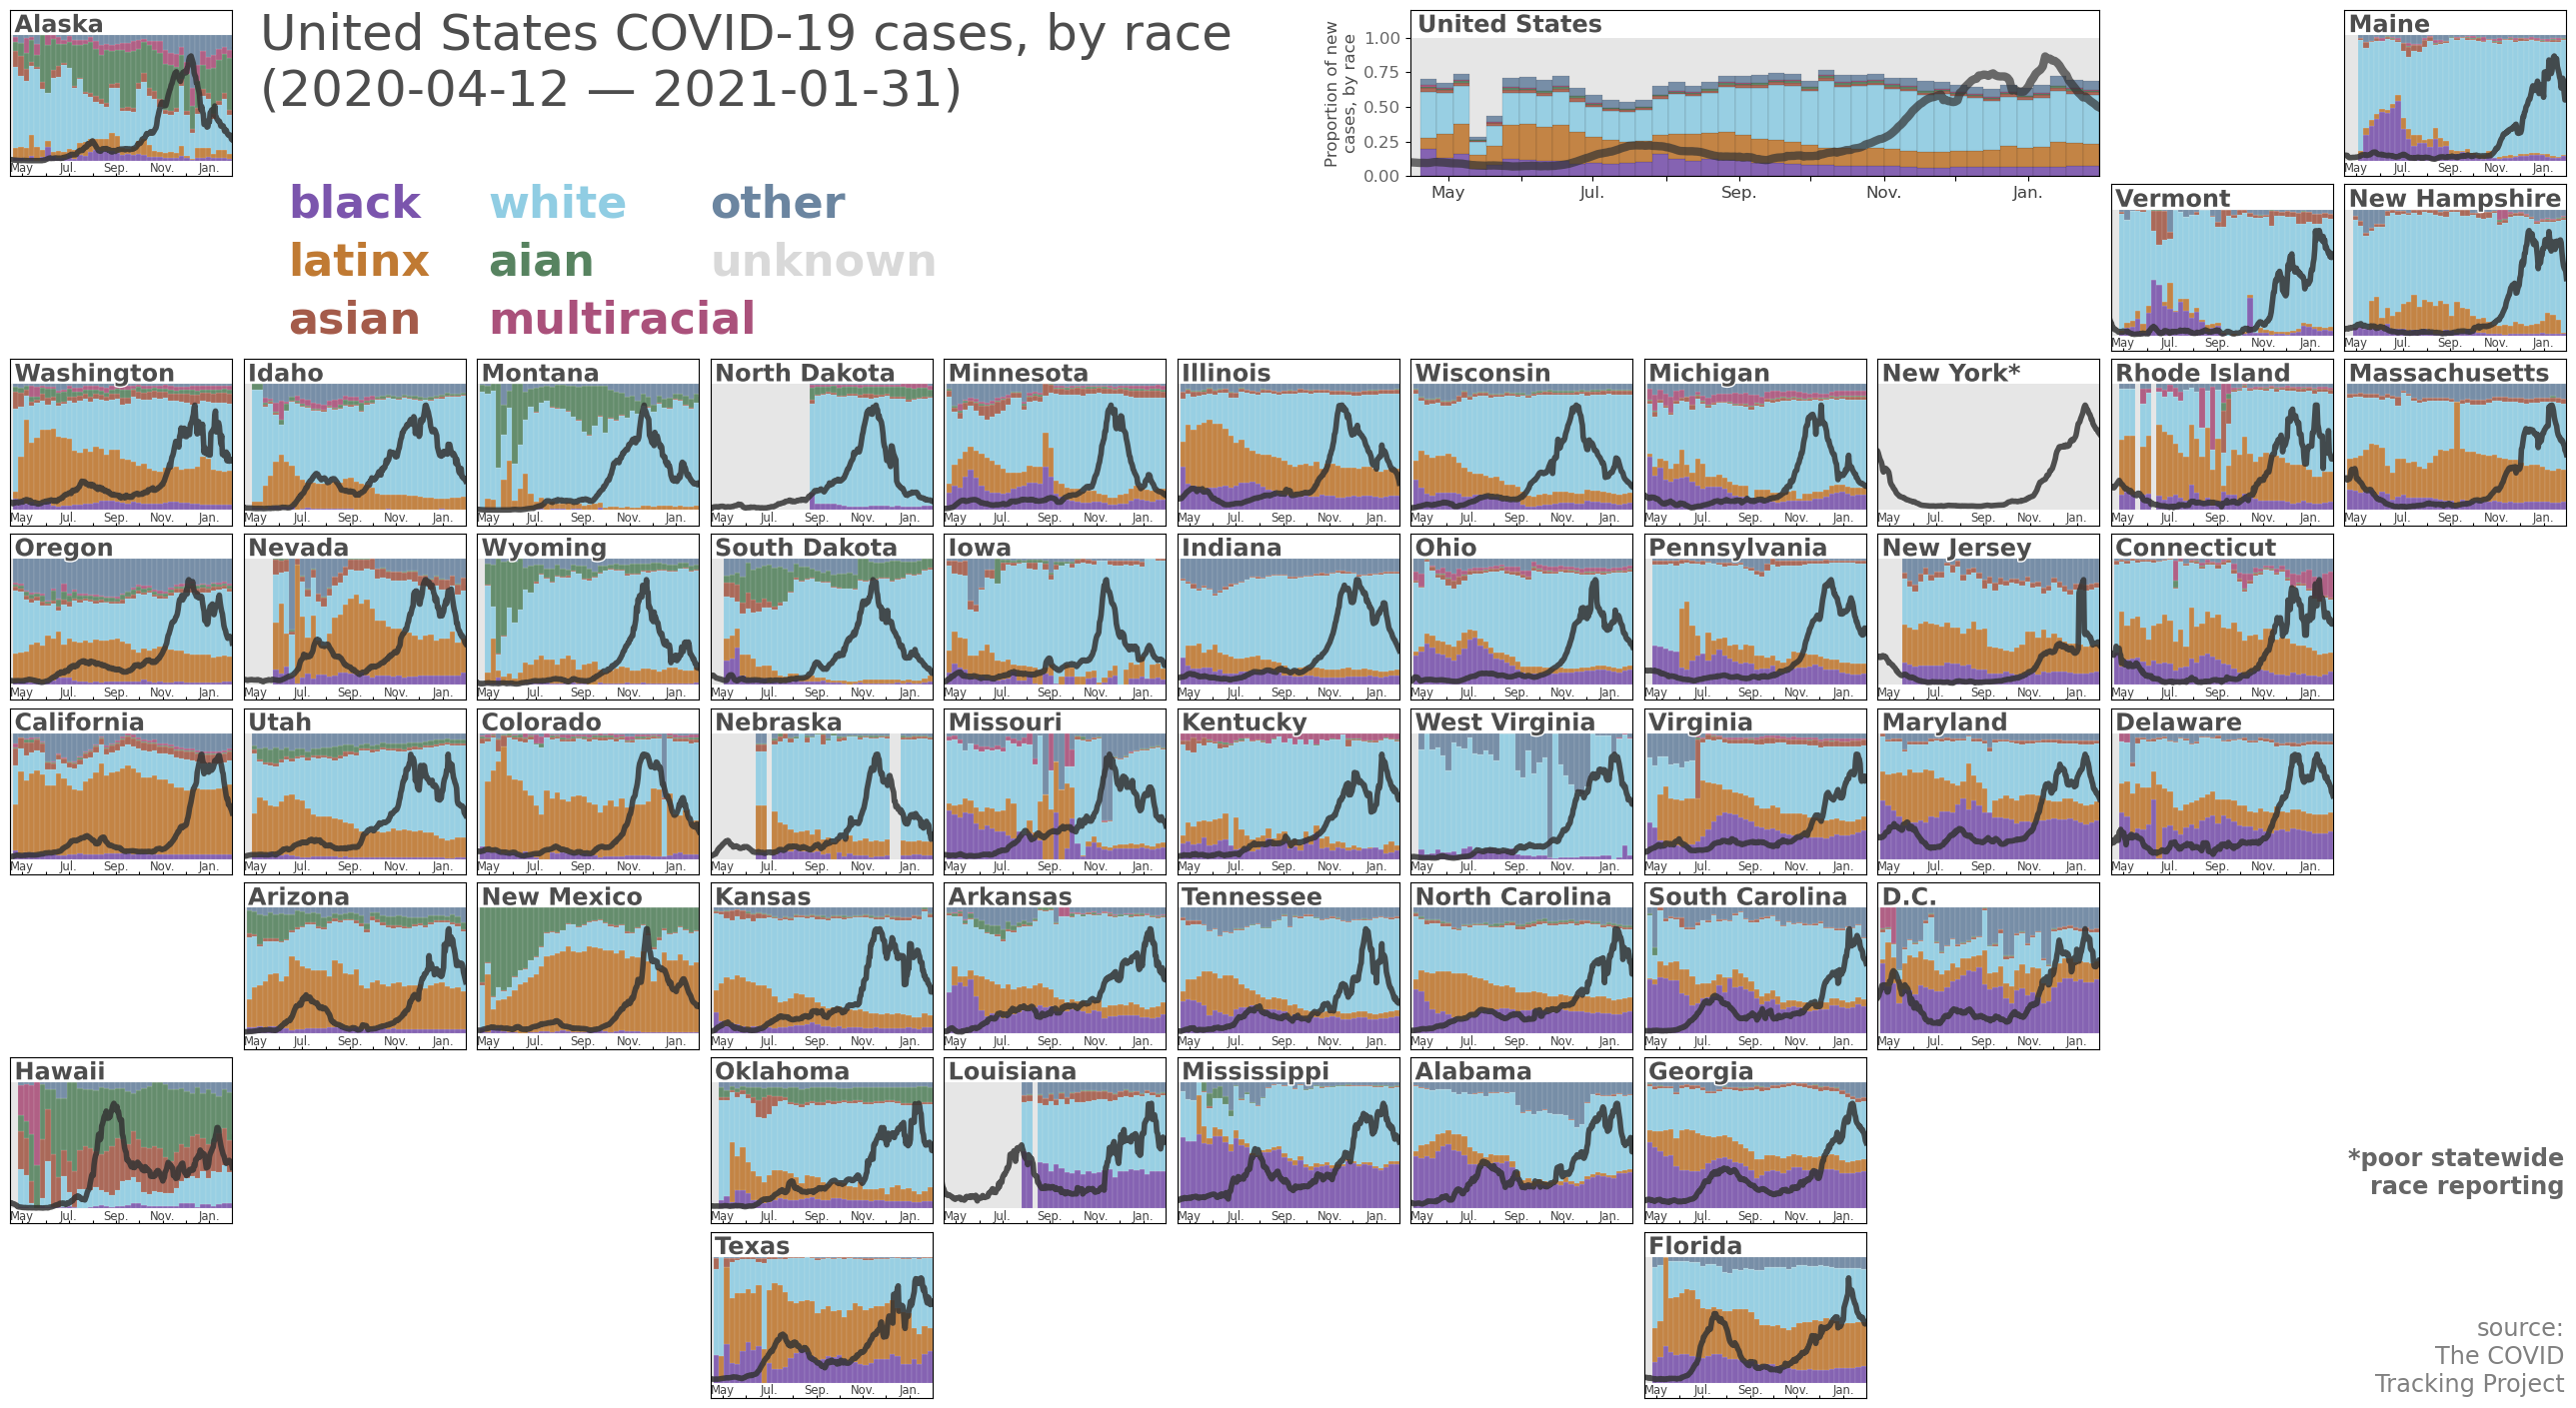

In [36]:
fdate = '2020-03-05'
days_since = 7
min_c = 10


xtx = ['2020-02-01','2020-03-01','2020-04-01','2020-05-01','2020-06-01','2020-07-01','2020-08-01',
       '2020-09-01','2020-10-01','2020-11-01','2020-12-01','2021-01-01','2021-02-01']
xtxl = ['','Mar.','','May','','Jul.','','Sep.','','Nov.','','Jan.','']


col_co = '.2'

rcos = dict(zip(['black','latinx','asian','white'],['rebeccapurple','mediumseagreen','steelblue','orange']))

w = 3.0; h = 2.3
ncols = 11; nrows = 8
tups = list(it.product(range(nrows), range(ncols)))
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100)#, sharex=True)
plt.subplots_adjust(wspace=0.05,hspace=0.05)

lw_i = 0.1
ec_i = '.1'
for st, po in state_posx.items():
    stlab = all_state_names[st]
    if st not in grace['state'].unique().tolist() or st in ['gu','vi','mp','pr']:
        ax[po].set_axis_off()
        continue

    rr_df = grace.loc[grace['state']==st].copy()
    rr_df = rr_df.loc[~rr_df['date'].isna()].copy()
    rr_df = rr_df.sort_values('date')
    rr_df['denom'] = rr_df[[i for i in rr_df.columns if 'new_cases_' in i
                            and 'new_cases_total' not in i]].sum(axis=1)
    rr_df = rr_df[[i for i in rr_df.columns if 'new_cases_' in i or 'denom' in i or 'date' in i]]
    rr_df = rr_df.loc[rr_df['denom']>0].copy()

    prace_cols = ['black','latinx','white','asian','aian','multiracial','other']#,'unknown']
    ccc = ["#7b55ad","#c07a33","#90cde3","#a45b4a","#578360","#aa517b","#6b85a0"]#,"#759743"]
    rcos = dict(zip(prace_cols,ccc))
    rcos['unknown'] = '.85'

    hei=0
    for ci,c in enumerate(prace_cols):
        cases_col_c = 'new_cases_'+c
        xvals = [date_dict[i] for i in rr_df['date'].values]
        yvals = rr_df[cases_col_c].values
        yvals = yvals / rr_df[['new_cases_'+c for c in prace_cols]].sum(axis=1).values

        widts = list(np.diff(xvals))
        if widts[0]==3:
            widts = widts+[4]
        else:
            widts = widts+[3]

        ax[po].bar(xvals,yvals,bottom=hei,width=widts,
                ec='.95',lw=lw_i,fc=rcos[c],alpha=0.9,align='edge')
        hei = np.nan_to_num(yvals)+hei

    ll_st = ll.loc[(ll['fips']==all_ids_state[st])&(ll['date']>'2020-04-05')]
    xvals = np.array([date_dict[i] for i in ll_st['date'].values])
    yvals = ll_st['new_cases'].rolling(window=7).mean()/\
            (np.nanmax(ll_st['new_cases'].rolling(window=7).mean())*1.2)
    widts = list(np.diff(xvals))
    widts = widts+[3] if widts[0]==3 else widts+[4]

    ax[po].bar(xvals,[1]*len(xvals),bottom=0,width=widts,ec=ec_i,lw=0,
               fc='.9',alpha=1,align='edge',zorder=0)
    ax[po].plot(xvals, yvals, alpha=0.85,color='.2',linewidth=4)

    if stlab == 'District of Columbia':
        stlab = 'D.C.'
    
    if stlab in ['New York']:
        stlab = stlab + '*'
    ax[po].text(0.02,0.98,stlab,fontsize='xx-large',va='top',ha='left',
                color='.3',fontweight='bold',transform=ax[po].transAxes, zorder=6,
                path_effects=[path_effects.Stroke(linewidth=2, foreground='w'),
                              path_effects.Normal()])
    
    ax[po].set_xticks([date_dict[i] for i in xtx])
    ax[po].set_xticklabels(xtxl,fontsize='small',color='.25')
    ax[po].set_yticks([])
    ax[po].set_yticklabels(['']*len(ytx))
    ax[po].tick_params(axis="x",direction="in", pad=-10, length=2)
    ax[po].tick_params(axis="y",direction="in", pad=-5, length=0)

    ylim_st = ax[po].get_ylim()
    xlim_st = ax[po].get_xlim()
    ydiff = ylim_st[1]-ylim_st[0]
    
    ax[po].set_ylim(-0.12,1.2)
    ax[po].set_xlim(date_dict['2020-04-15'],xvals[-1])

for tup in tups:
    if tup not in state_posx.values():
        ax[tup].set_axis_off()


col_co = '.1'
stlab = 'United States'
columns_usa = [i for i in grace.columns if 'new_cases_' in i and 'new_cases_total' not in i]
race_usa = grace.groupby('date').agg({s:np.nansum for s in columns_usa}).reset_index()
race_usa['denom'] = race_usa[[i for i in race_usa.columns if 'new_cases_' in i
                              and 'new_cases_total' not in i]].sum(axis=1)

gs = ax[1, 8].get_gridspec()
for a in ax[0:1, 6:9].flatten():
    a.remove()
axbig = fig.add_subplot(gs[0:1, 6:9])

hei=0
for ci,c in enumerate(prace_cols):
    cases_col_c = 'new_cases_'+c
    xvals = [date_dict[i] for i in race_usa['date'].values]
    yvals = race_usa[cases_col_c].values
    yvals = yvals / race_usa['denom'].values
    widts = list(np.diff(xvals))
    if widts[0]==3:
        widts = widts+[4]
    else:
        widts = widts+[3]

    axbig.bar(xvals,yvals,bottom=hei,width=widts,
            ec=ec_i,lw=lw_i,fc=rcos[c],alpha=0.9,align='edge')
    hei = np.nan_to_num(yvals)+hei

race_usa = ll.loc[(ll['state']==stlab)&(ll['date']>'2020-04-05')].copy()

xvals = np.array([date_dict[i] for i in race_usa['date'].values])
yvals = race_usa['new_cases'].rolling(window=7).mean()/np.nanmax(race_usa['new_cases'])
widts = list(np.diff(xvals))
widts = widts+[3] if widts[0]==3 else widts+[4]

axbig.bar(xvals,[1]*len(xvals),bottom=0,width=widts,ec='.95',lw=0,
           fc='.9',align='edge',zorder=0)
axbig.plot(xvals, yvals, alpha=0.7,color='.2',linewidth=6)

axbig.text(0.01,0.98,stlab,fontsize='xx-large',va='top',ha='left',
           color='.3',fontweight='bold',transform=axbig.transAxes, zorder=6,
           path_effects=[path_effects.Stroke(linewidth=2, foreground='w'),
                         path_effects.Normal()])

axbig.set_xticks([date_dict[i] for i in xtx])
axbig.set_xticklabels(xtxl,fontsize='large',color='.25')
axbig.set_yticks([0,0.25,0.5,0.75,1.0])
axbig.set_yticklabels(['0.00','0.25','0.50','0.75','1.00'],fontsize='large',color='.4')

ylim_st = axbig.get_ylim()
xlim_st = axbig.get_xlim()
ydiff = ylim_st[1]-ylim_st[0]

axbig.set_ylim(0.0,1.2)
axbig.set_xlim(date_dict['2020-04-15'],xvals[-1])
axbig.set_ylabel('Proportion of new\ncases, by race',fontsize='large',color='.3')

ax[tups[-1]].text(0.99,0.01,'source:\nThe COVID\nTracking Project',color='.5',fontsize='xx-large',
                va='bottom', ha='right', transform=ax[tups[-1]].transAxes)
ax[tups[-1]].text(0.99,1.2,'*poor statewide\nrace reporting',fontweight='bold',
                  color='.4',fontsize='xx-large', va='bottom', ha='right', transform=ax[tups[-1]].transAxes)
ax[(0,1)].text(0.075,0.99,'United States COVID-19 cases, by race\n(%s — %s)'%(race['date'].min(),
                                                                              race['date'].max()),
               color='.3', fontsize=36, va='top', ha='left', transform=ax[(0,1)].transAxes)

fs = 32
ax[(1,1)].text(0.2,0.75,'black',color=rcos['black'],fontsize=fs,
               va='bottom', ha='left', transform=ax[(1,1)].transAxes, fontweight='bold')
ax[(1,1)].text(0.2,0.40,'latinx',color=rcos['latinx'],fontsize=fs,
               va='bottom', ha='left', transform=ax[(1,1)].transAxes, fontweight='bold')
ax[(1,1)].text(0.2,0.05,'asian',color=rcos['asian'],fontsize=fs,
               va='bottom', ha='left', transform=ax[(1,1)].transAxes, fontweight='bold')
ax[(1,2)].text(0.05,0.75,'white',color=rcos['white'],fontsize=fs,
               va='bottom', ha='left', transform=ax[(1,2)].transAxes, fontweight='bold')
ax[(1,2)].text(0.05,0.40,'aian',color=rcos['aian'],fontsize=fs,
               va='bottom', ha='left', transform=ax[(1,2)].transAxes, fontweight='bold')
ax[(1,2)].text(0.05,0.05,'multiracial',color=rcos['multiracial'],fontsize=fs,
               va='bottom', ha='left', transform=ax[(1,2)].transAxes, fontweight='bold')
ax[(1,3)].text(0.0,0.75,'other',color=rcos['other'],fontsize=fs,
               va='bottom', ha='left', transform=ax[(1,3)].transAxes, fontweight='bold')
ax[(1,3)].text(0.0,0.40,'unknown',color=rcos['unknown'],fontsize=fs,
               va='bottom', ha='left', transform=ax[(1,3)].transAxes, fontweight='bold')

plt.savefig('../figs/pngs/state_subplot_race_case_percapitaX.png', dpi=425, bbox_inches='tight')
plt.show()

/Users/brennan/anaconda3/envs/covid/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


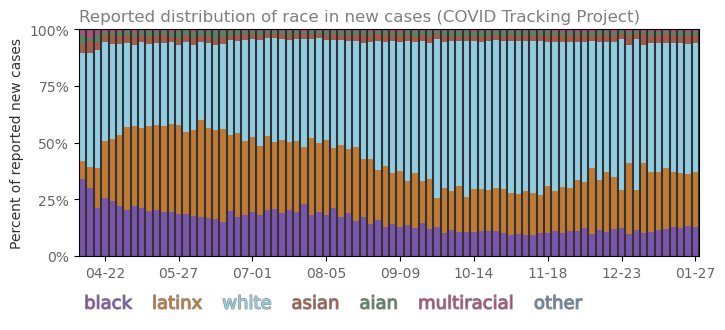

In [37]:
usa_race = race.groupby('date').agg({'new_cases_'+i:np.nansum for i in prace_cols}).reset_index()
usa_race['new_cases_total'] = usa_race[['new_cases_'+i for i in prace_cols[:-1]]].sum(axis=1)

prace_cols = ['black','latinx','white','asian','aian','multiracial','other']#,'unknown']
ccc = ["#7b55ad","#c07a33","#90cde3","#a45b4a","#578360","#aa517b","#6b85a0"]#,"#759743"]
rcos = dict(zip(prace_cols,ccc))
rcos['unknown'] = '.85'

fig, ax = plt.subplots(1,1,figsize=(8,3),dpi=100)

xx = [usa_race['new_cases_'+i].values/usa_race['new_cases_total'].values for i in prace_cols]
curr = np.zeros(len(xx[0]))
c = 0
for i in xx:
    ax.bar(list(range(len(i)-1)), height=i[1:], bottom=curr[1:], fc=rcos[prace_cols[c]], width=1.1)
#     plt.plot(list(range(len(i))), i)
    curr = curr + np.nan_to_num(i)
    c += 1

ax.vlines(np.linspace(0.5, len(usa_race['date'].values)-0.5, len(usa_race['date'].values)), 0, 1, color='.2')
ax.set_yticks([0,0.25,0.5,0.75,1.0])
ax.set_yticklabels(["0%","25%","50%",'75%',"100%"])
xtx = np.arange(3,len(usa_race['date'].values),10)
ax.set_xticks(xtx)
ax.set_xticklabels([i[5:] for i in usa_race['date'].values[xtx]])
ax.set_xlim(-0.5,len(usa_race['date'].values)-1.5)
ax.set_ylim(0,1)
ax.tick_params(labelcolor='.4')
ax.set_ylabel('Percent of reported new cases', color='.2')

rvs = np.linspace(0.1,1,len(prace_cols))
full = len(''.join(str(c) for c in prace_cols)) * 2
rvs = len(prace_cols[0]) / full
rvs = 0
for ri,r in enumerate(prace_cols):
    ax.scatter(list(range(len(prace_cols))),list(range(len(prace_cols))),marker='',label=r)

l = ax.legend(ncol=len(prace_cols),columnspacing=0, handletextpad=-0.9,bbox_to_anchor=[-0.05,-0.1],loc=2,
          framealpha=0, fontsize=13)

for text in l.get_texts():
    text.set_color(rcos[text.get_text()])
    text.set_path_effects([path_effects.Stroke(linewidth=1, foreground='.6'),
                       path_effects.Normal()])
    
ax.set_title('Reported distribution of race in new cases (COVID Tracking Project)',
          x=0, ha='left', fontsize='large',color='.5')

plt.savefig('../figs/pngs/usa_race_timeseries.png',dpi=425,bbox_inches='tight')
plt.show()

# Four panels

In [38]:
# stlab = 'United States'
# hosp['fips'] = [all_ids_state[i.lower()] for i in hosp['state'].values]
# usa_tots = hosp.groupby('date').agg({'hospitalizedCurrently':np.nansum,
#                                      'hospitalizedCumulative':np.nansum, 
#                                      'inIcuCurrently':np.nansum,
#                                      'inIcuCumulative':np.nansum,
#                                      'onVentilatorCurrently':np.nansum, 
#                                      'onVentilatorCumulative':np.nansum}).reset_index()

# usa_tots['fips'] = '00'
# hosp = pd.concat([hosp[usa_tots.columns],usa_tots])
# ll_df = ll.merge(hosp,how='left',on=['date','fips'])
# ll_df = ll_df.rename(columns={'hospitalizedCurrently':'hospitalized',
#                         'hospitalizedCumulative':'hospitalized_cumulative'})
# ll_df = ll_df[['date', 'state', 'fips', 'cases', 'deaths', 'population', 'new_deaths',
#                'new_cases', 'hospitalized', 'hospitalized_cumulative']]

# rt_df = rt_df.rename(columns={'mean':'mean_r0','lower_80':'lower_80_r0','upper_80':'upper_80_r0'})

In [39]:
# bad_states = []
# fdate = '2020-03-05'
# days_since = 14
# xtx = ['2020-02-01','2020-03-01','2020-04-01','2020-05-01','2020-06-01','2020-07-01','2020-08-01',
#        '2020-09-01','2020-10-01','2020-11-01','2020-12-01','2021-01-01','2021-02-01']
# xtxl = ['','Mar.','','May','','Jul.','','Sep.','','Nov.','','Jan.','']


# for stlab in sorted(ll['state'].unique(), reverse=True):
#     ll_st = ll_df.loc[ll_df['state']==stlab].copy()
#     ll_st = ll_st.merge(rt_df[['date','fips','mean_r0','lower_80_r0','upper_80_r0']],
#                         how='left',on=['date','fips'])

#     save_fn = "".join(stlab.split(' '))
#     save_fn = "".join(save_fn.split('?'))

#     w = 3.0; h = 2.0
#     ncols = 2; nrows = 2
#     tups = list(it.product(range(nrows), range(ncols)))
#     fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100)#, sharex=True)
#     plt.subplots_adjust(wspace=0.05,hspace=0.05)

#     to_plot = ['cases','hospitalized','deaths','mean_r0']
#     to_plot_new = ['new_cases','hospitalized_\ncurrently','new_deaths','mean_r0']
#     titles = ['Cases','Hospitalizations','Deaths',r'Estimated $R_t$']
#     cols_out = {}
#     for ix, pp in enumerate(to_plot):
#         tup = tups[ix]
#         xvals_st = [date_dict[i] for i in sorted(ll_st['date'].tolist())]
#         if ix == len(to_plot)-1:

#             if stlab == 'United States':
#                 curr_df = rt_df.loc[rt_df['date']==rt_df['date'].max()].sort_values('mean_r0')
#                 xvals = np.linspace(0.5,curr_df.shape[0]-0.5,curr_df.shape[0])
#                 yvals = curr_df['mean_r0'].values
#                 yvals_u = curr_df['upper_80_r0'].values
#                 yvals_l = curr_df['lower_80_r0'].values

#                 cols_co = [up_col if i>1 else down_col for i in yvals]
#                 ax[tup].scatter(xvals, yvals, c=cols_co, alpha=0.9, zorder=5,s=12,
#                                 marker='o',lw=0.7,edgecolors='w')
#                 ax[tup].vlines(xvals, yvals_l, yvals_u, color=cols_co, alpha=0.7, linewidth=0.7)
#                 ax[tup].hlines(1, -1, xvals[-1]+2, color='.4', linestyle='--', linewidth=2, alpha=9)

#                 ax[tup].set_xlim(-0.5,curr_df.shape[0]+0.5)
#                 ax[tup].set_ylim(0.425,1.825)
#                 ax[tup].set_xticks([])
#                 ax[tup].set_yticks([0.5,1.0,1.5])
#                 ax[tup].set_yticklabels(['0.50','','1.50'], color='.5', ha='left')
#                 ax[tup].tick_params(axis="y",direction="in", pad=-2, length=0)

#                 col_co = up_col
#                 cols_out[ix] = col_co
#                 text1 = ax[tup].text(0.02, 0.98, titles[ix],
#                                      fontsize='x-large', va='top', ha='left', color=col_co, fontweight='bold',
#                                      transform=ax[tup].transAxes, zorder=6)
#                 text2 = ax[tup].text(xvals[-1]+0.5, 0.985, r'$R_t=1$', zorder=6,
#                                      fontsize='medium', va='top', ha='right', color='.3')
#                 tws = [2.0,1.0]
#                 for ti,t in enumerate([text1,text2]):
#                     t.set_path_effects([path_effects.Stroke(linewidth=tws[ti],
#                                         foreground='w'), path_effects.Normal()])

#                 ax[tup].set_xlim(-0.5,curr_df.shape[0]+0.5)
#                 ax[tup].set_ylim(0.425,1.825)
#                 ax[tup].grid(linewidth=1, color='w', alpha=0.7, zorder=-299)

#             else:
#                 xvals = [date_dict[i]
#                          for i in sorted(ll_st[ll_st['date']<=rt_df['date'].max()]['date'].tolist())]
#                 yvals = ll_st[ll_st['date']<=rt_df['date'].max()][pp].values#[inds]
#                 yvals_u = ll_st[ll_st['date']<=rt_df['date'].max()]['upper_80_r0'].values#[inds]
#                 yvals_l = ll_st[ll_st['date']<=rt_df['date'].max()]['lower_80_r0'].values#[inds]

#                 if yvals[-1] < 1.0:
#                     col_co = down_col
#                 if yvals[-1] >= 1.0:
#                     col_co = up_col

#                 mind = 0
#                 if len(np.where(np.isnan(yvals))[0])>0:
#                     mind = max(np.where(np.isnan(yvals))[0])+1
#                 cols_co = [up_col if np.nan_to_num(i)>1 else down_col for i in yvals][mind:]

#                 ax[tup].scatter(xvals[mind:], yvals[mind:],
#                                 c=cols_co, lw=0, alpha=0.9, zorder=5, s=4)
#                 ax[tup].vlines( xvals[mind:], yvals_l[mind:], yvals_u[mind:],
#                                color=cols_co, alpha=0.9, linewidth=0.5)
#                 ax[tup].hlines(1, -1, xvals[-1]+2, color='.4', linestyle='--', linewidth=1, alpha=0.9)
#                 ax[tup].hlines(2, -1, xvals[-1]+2, color='.4', linestyle='--', linewidth=1, alpha=0.9)


#                 ylim_st = ax[tup].get_ylim()
#                 xlim_st = (-1,list(date_dict.values())[-1]+2)
#                 xdiff_df = xlim_st[1]-xlim_st[0]
#                 ydiff = ylim_st[1]-ylim_st[0]
#                 ylim_st = (0.01, 3.51)

#                 text1 = ax[tup].text(0.02, 0.98, titles[ix],
#                                      fontsize='x-large', va='top', ha='left', color=col_co, fontweight='bold',
#                                      transform=ax[tup].transAxes, zorder=6)
#                 text2 = ax[tup].text(0.02, 0.84, r'most recent $R_t\approx %.2f$'%(yvals[-1]),
#                                      fontsize='medium', va='top', ha='left', color='.3', fontweight='medium',
#                                      transform=ax[tup].transAxes, zorder=7)
#                 text3 = ax[tup].text(xdiff_df*0.02, 1.015, r'$R_t=1$', zorder=6,
#                                      fontsize='medium', va='bottom', ha='left', color='.3')
#                 text4 = ax[tup].text(xdiff_df*0.02, 2.015, r'$R_t=2$', zorder=6,
#                                      fontsize='medium', va='bottom', ha='left', color='.3')
#                 tws = [2.0,1.0,1.0,1.0]
#                 for ti,t in enumerate([text1,text2,text3,text4]):
#                     t.set_path_effects([path_effects.Stroke(linewidth=tws[ti],
#                                         foreground='w'), path_effects.Normal()])

#                 ax[tup].set_ylim(ylim_st[0], ylim_st[1])

#         else:
#             xvals_st = [date_dict[i] for i in sorted(ll_st['date'].tolist())]
#             if stlab not in bad_states and pp=='hospitalized':
#                 yvals_st = np.nan_to_num(np.array(ll_st[pp].rolling(window=7).mean().tolist()))
#                 yvals_st[yvals_st<0] = 0
#                 yvals_st_raw = np.nan_to_num(ll_st[pp].values)
#                 total_st = int(max(np.nan_to_num(ll_st[pp+'_cumulative'].values)))
#                 most_recent_st = int(yvals_st_raw[-1])
#             elif stlab in bad_states and pp=='hospitalized':
#                 yvals_st = np.nan_to_num(ll_st[pp+'_cumulative'].diff().rolling(window=7).mean().values)
#                 yvals_st[yvals_st<0] = 0
#                 yvals_st_raw = np.nan_to_num(np.array(ll_st[pp+'_cumulative'].diff().values))
#                 total_st = int(max(np.nan_to_num(ll_st[pp+'_cumulative'].values)))
#                 most_recent_st = int(yvals_st_raw[-1])
#             else:
#                 yvals_st = ll_st[to_plot_new[ix]].rolling(window=7).mean().tolist()
#                 yvals_st_raw = ll_st[to_plot_new[ix]].tolist()
#                 total_st = ll_st[pp].values[-1]
#                 most_recent_st = ll_st[to_plot_new[ix]].values[-1]

#             recent_average_curr = np.mean(yvals_st[(-days_since):])
#             recent_average_prev = np.mean(yvals_st[(-2*days_since):(-days_since)])

#             if recent_average_prev >= recent_average_curr:
#                 col_co = down_col
#             if recent_average_prev <= recent_average_curr:
#                 col_co = up_col
#             if recent_average_prev >= 2*recent_average_curr:
#                 col_co = vdown_col

#             ax[tup].plot(xvals_st, yvals_st,     color=col_co,
#                               linewidth=2.5, zorder=1, alpha=0.85)
#             ax[tup].bar( xvals_st, yvals_st_raw, color=col_co,
#                               linewidth=0.1, zorder=1, alpha=0.45, width=1, ec='w')
#             if pp == 'deaths':
#                 ylim_st = (0, np.nanmax(yvals_st)*1.3) if np.nanmax(yvals_st_raw) >= 16 else (-0.1, 16)
#             else:
#                 ylim_st = (0, np.nanmax(yvals_st)*1.3) if np.nanmax(yvals_st_raw) >= 110 else (-0.5, 110)
    
#             ax[tup].set_ylim(ylim_st[0],ylim_st[1])

#             casey = 0.715 if '\n' in stlab else 0.835

#             text1 = ax[tup].text(0.02, 0.98, titles[ix],
#                                  fontsize='x-large', va='top', ha='left', color=col_co, fontweight='bold',
#                                  transform=ax[tup].transAxes)
#             text2 = ax[tup].text(0.02,0.02,'%s\ntotal'%("{:,}".format(total_st)),
#                                  fontsize='medium', va='bottom', ha='left', color='.2', fontweight='bold',
#                                  transform=ax[tup].transAxes)

#             pplab = ' '.join(to_plot_new[ix].split('_'))
#             text3 = ax[tup].text(0.02,casey,'%s: %s\n%s'%(ld[:-6], "{:,}".format(most_recent_st), pplab),
#                                  fontsize='medium',va='top',ha='left', color='.2', fontweight='medium',
#                                  transform=ax[tup].transAxes)

#             tws = [2.0,1.0,1.0]
#             for ti,t in enumerate([text1,text2,text3]):
#                 t.set_path_effects([path_effects.Stroke(linewidth=tws[ti], foreground='w'),
#                                     path_effects.Normal()])

#         cols_out[ix] = col_co


#     for ai,a in enumerate(fig.axes):
#         if stlab == 'United States' and ai == len(to_plot)-1:
#             xlim_sta = a.get_xlim()
#             a.fill_between([-1, list(date_dict.values())[-1]+2],
#                            ylim_sta[0], ylim_sta[1], 
#                            color=cols_out[ai], alpha=0.08, zorder=-2)
#             a.fill_between([list(date_dict.values())[-1]-days_since,list(date_dict.values())[-1]+2],
#                            ylim_sta[0], ylim_sta[1], 
#                            color='.7', alpha=0.4, linewidth=0, zorder=-2)
#             a.set_xlim(xlim_sta[0],xlim_sta[1])
#             pass

#         else:
#             a.set_xticks([date_dict[i] for i in xtx])
#             a.set_xticklabels([i for i in xtxl],fontsize=7)
#             a.spines['bottom'].set_color('.3')
#             a.spines['top'].set_color('.3') 
#             a.spines['right'].set_color('.3')
#             a.spines['left'].set_color('.3')
#             a.tick_params(axis='x', colors='.3')
#             a.tick_params(axis='y', colors='.3')
#             a.tick_params(axis='both', which='major', zorder=300)
#             a.grid(linewidth=1, color='w', alpha=0.7, zorder=-299)
#             a.tick_params(axis="y",direction="in", pad=-5)

#             ylim_sta = a.get_ylim()
#             xlim_sta = a.get_xlim()
#             ydiffa = ylim_sta[1]-ylim_sta[0]

#             if ai < len(to_plot)-1:
#                 yticks_a = a.get_yticks()
#                 yticks_a = yticks_a[yticks_a>0]
#                 yticks_a = yticks_a[yticks_a<max(yticks_a)]
#                 if to_plot[ai] == 'deaths':
#                     ylim_sta = (0, ylim_sta[1]*1.05) if np.nanmax(ylim_sta[1]) >= 16 else (-0.1, 16)
#                 else:
#                     ylim_sta = (0, ylim_sta[1]*1.05) if np.nanmax(ylim_sta[1]) >= 110 else (-0.5, 110)
#                 a.set_yticks(yticks_a)
#                 a.set_yticklabels(yticks_a.astype(int), ha='right', color='.4',fontsize='small')
#                 if yticks_a[np.argmin(np.abs(ylim_sta[1]-yticks_a))] / ylim_sta[1] > 0.95:
#                     ylim_sta = (ylim_sta[0],ylim_sta[1]*1.1)
#                     if yticks_a[np.argmin(np.abs(ylim_sta[1]-yticks_a))] / ylim_sta[1] > 0.95:
#                         ylim_sta = (ylim_sta[0],ylim_sta[1]*1.125)

#             else:
#                 ytx = [0.5,1.0,1.5,2.0,2.5,3.0]
#                 a.set_yticks(ytx)
#                 a.set_yticklabels([""]*len(ytx), ha='right', color='.4')
#                 a.tick_params(axis="y",direction="in", pad=-5, length=0)

#             a.yaxis.tick_right()

#             a.fill_between([-1, list(date_dict.values())[-1]+2],
#                            ylim_sta[0], ylim_sta[1], 
#                            color=cols_out[ai], alpha=0.08, zorder=-2)
#             a.fill_between([list(date_dict.values())[-1]-days_since,list(date_dict.values())[-1]+2],
#                            ylim_sta[0], ylim_sta[1], 
#                            color='.7', alpha=0.4, linewidth=0, zorder=-2)

#             a.set_xlim(-1,list(date_dict.values())[-1]+2)
#             a.set_ylim(ylim_sta[0], ylim_sta[1])

#     stlab += ' (%s — %s)'%(sorted(ll_df['date'].tolist())[0],sorted(ll_df['date'].tolist())[-1])
#     plt.suptitle(stlab,fontsize='large',y=0.935,color='.5')

#     plt.savefig('../figs/pngs/state_cases_deaths/%s_full.png'%save_fn,dpi=425,bbox_inches='tight')
#     plt.close()

# Misc

In [40]:
from scipy.stats import entropy

stlab = 'United States'
usa_tots = ll.loc[ll['state']==stlab]
xvals_usa = np.array([date_dict[i] for i in sorted(usa_tots['date'].tolist())])
yvals_usa = np.nan_to_num(usa_tots['new_cases'].rolling(window=7).mean().values)
usa_dict = dict(zip(xvals_usa,yvals_usa/np.nansum(yvals_usa)))

ent_dict = {}
for st, po in state_posx.items():
    if st in ['gu','vi','mp','hi']:
        continue
    stlab = all_state_names[st]
    ll_st = ll.loc[ll['state']==stlab].copy()

    xvals_st = np.array([date_dict[i] for i in sorted(ll_st['date'].tolist())])
    yvals_st = np.nan_to_num(np.array(ll_st['new_cases'].rolling(window=7).mean().values))
    yvals_st[yvals_st<0] = 0
    st_dict = dict(zip(xvals_st, yvals_st))
    sta_dict = {i:st_dict[i]/np.nansum(yvals_st) if i in list(st_dict.keys()) else 0 for i in usa_dict.keys()}
    
    usa_vals = np.array(list(usa_dict.values()))
    sta_vals = np.array(list(sta_dict.values()))
    
    ent_dict[stlab] = entropy(sta_vals, usa_vals)
    
ent_dict = dict(sorted(ent_dict.items(), key=lambda x: x[1], reverse=True))

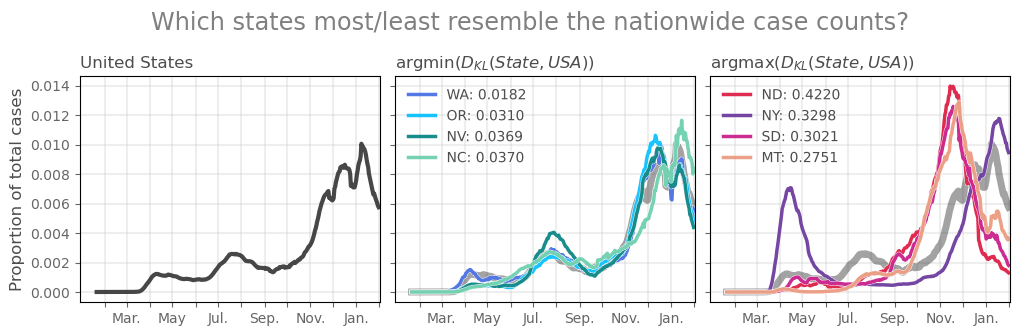

In [41]:
all_names_state = {j:i.upper() for i,j in all_state_names.items()}
n = 4

xtx = ['2020-02-01','2020-03-01','2020-04-01','2020-05-01','2020-06-01','2020-07-01','2020-08-01',
       '2020-09-01','2020-10-01','2020-11-01','2020-12-01','2021-01-01','2021-02-01']
xtxl = ['','Mar.','','May','','Jul.','','Sep.','','Nov.','','Jan.','']


fig,ax = plt.subplots(1,3,figsize=(12,3),dpi=100,sharey=True,sharex=True)
ax[0].plot(list(usa_dict.keys()), list(usa_dict.values()), linewidth=3, alpha=0.9, color='.2')

colset1 = ['royalblue','deepskyblue','teal','mediumaquamarine']
sim_states = list(ent_dict.keys())[-n:]
ax[1].plot(list(usa_dict.keys()), list(usa_dict.values()), linewidth=5, alpha=0.4, color='.1')
for si,stlab in enumerate(sim_states[::-1]):
    ll_st = ll.loc[ll['state']==stlab].copy()
    xvals_st = np.array([date_dict[i] for i in sorted(ll_st['date'].tolist())])
    yvals_st = np.nan_to_num(np.array(ll_st['new_cases'].rolling(window=14).mean().values))
    yvals_st[yvals_st<0] = 0
    st_dict = dict(zip(xvals_st, yvals_st))
    sta_dict = {i:st_dict[i]/np.nansum(yvals_st) if i in list(st_dict.keys()) else 0 for i in usa_dict.keys()}
    ax[1].plot(list(sta_dict.keys()), list(sta_dict.values()), linewidth=3.2, alpha=0.9,color='w')
    ax[1].plot(list(sta_dict.keys()), list(sta_dict.values()), linewidth=2.5, alpha=0.9,color=colset1[si],
               label="%s: %.4f"%(all_names_state[stlab], ent_dict[stlab]))

colset2 = ['crimson','rebeccapurple','mediumvioletred','darksalmon']
sim_states = list(ent_dict.keys())[:n]
ax[2].plot(list(usa_dict.keys()), list(usa_dict.values()), linewidth=5, alpha=0.4, color='.1')
for si,stlab in enumerate(sim_states):
    ll_st = ll.loc[ll['state']==stlab].copy()
    xvals_st = np.array([date_dict[i] for i in sorted(ll_st['date'].tolist())])
    yvals_st = np.nan_to_num(np.array(ll_st['new_cases'].rolling(window=14).mean().values))
    yvals_st[yvals_st<0] = 0
    st_dict = dict(zip(xvals_st, yvals_st))
    sta_dict = {i:st_dict[i]/np.nansum(yvals_st) if i in list(st_dict.keys()) else 0 for i in usa_dict.keys()}
    ax[2].plot(list(sta_dict.keys()), list(sta_dict.values()), linewidth=3.2, alpha=0.9,color='w')
    ax[2].plot(list(sta_dict.keys()), list(sta_dict.values()), linewidth=2.5, alpha=0.9,color=colset2[si],
               label="%s: %.4f"%(all_names_state[stlab], ent_dict[stlab]))
    

l = ax[1].legend(loc=2,ncol=1,framealpha=0,fontsize='medium')
for text in l.get_texts():
    text.set_color(".3")
    text.set_path_effects([path_effects.Stroke(linewidth=1.5, foreground='w'),
                           path_effects.Normal()])

l = ax[2].legend(loc=2,ncol=1,framealpha=0,fontsize='medium')
for text in l.get_texts():
    text.set_color(".3")
    text.set_path_effects([path_effects.Stroke(linewidth=1.5, foreground='w'),
                           path_effects.Normal()])

ax[0].set_ylabel('Proportion of total cases',color='.3',fontsize='large')
ax[0].set_title('United States',x=0,ha='left',color='.3')
ax[1].set_title(r'argmin($D_{KL}(State, USA)$)',x=0,ha='left',color='.3')
ax[2].set_title(r'argmax($D_{KL}(State, USA)$)',x=0,ha='left',color='.3')

plt.subplots_adjust(wspace=0.05)
for a in fig.axes:
    a.set_xlim(-2,list(sta_dict.keys())[-1]+2)
    a.set_xticks([date_dict[i] for i in xtx])
    a.set_xticklabels(xtxl)
    a.grid(color='.75',alpha=0.25,linewidth=1.5)
    a.tick_params(labelcolor='.4',color='.4')

plt.suptitle('Which states most/least resemble the nationwide case counts?',
             y=1.1, fontsize='xx-large',color='.5')

plt.savefig('../figs/pngs/dkl_state_usa.png',dpi=425,bbox_inches='tight')
plt.show()